In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
#smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
n_classes=12
n_epochs=500
pzflow_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{pzflow_suffix}"

dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)

In [4]:
dataset_bank_tns_df_resampled_train

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF19abvhaqq                   0.391695   
ZTF21aaswtkh                   0.356501   
ZTF18abscghc                   0.224128   
ZTF21abjpjcn                   0.392974   
ZTF21aarhzdh                   0.908470   
...                                 ...   
ZTFabc77186                    0.101906   
ZTFabc10713                    0.414561   
ZTFabc85164                    0.835908   
ZTFabc54040                    0.826514   
ZTFabc54861                    0.692236   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF19abvhaqq                                 0.368108   
ZTF21aaswtkh                                 0.355052   
ZTF18abscghc                                 0.290376   
ZTF21abjpjcn                                 0.806768   
ZTF21aarhzdh                                 0.317764   
...                                               ...   
ZTFabc77186                                  0.160637   
ZTFabc10713                                  0.466114   
ZTFabc85164                                  0.676877   
ZTFabc54040                                  1.207744   
ZTFabc54861                                  1.818829   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF19abvhaqq                      0.375000                     0.000000   
ZTF21aaswtkh                      0.300000                     0.000000   
ZTF18abscghc                      0.400000                     0.000000   
ZTF21abjpjcn                      0.142857                     0.142857   
ZTF21aarhzdh                      0.263158                     0.000000   
...                                    ...                          ...   
ZTFabc77186                       0.298445                     0.000067   
ZTFabc10713                       0.233716                     0.027543   
ZTFabc85164                       0.593535                     0.026752   
ZTFabc54040                       0.233404                     0.078337   
ZTFabc54861                       0.279659                     0.053930   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF19abvhaqq               0.395856                                 0.783390   
ZTF21aaswtkh               0.321765                                 0.713001   
ZTF18abscghc               0.345730                                 0.448256   
ZTF21abjpjcn               0.316430                                 0.785948   
ZTF21aarhzdh               0.397708                                 1.816940   
...                             ...                                      ...   
ZTFabc77186                0.367289                                 0.647583   
ZTFabc10713                0.249151                                 2.373863   
ZTFabc85164                0.476397                                 2.835504   
ZTFabc54040                0.335188                                 1.366412   
ZTFabc54861                0.364534                                 0.810974   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF19abvhaqq                                   0.723513   
ZTF21aaswtkh                                   0.551514   
ZTF18abscghc                                   0.448256   
ZTF21abjpjcn                                   0.671357   
ZTF21aarhzdh                                   1.555440   
...                                                 ...   
ZTFabc77186                                    0.473944   
ZTFabc10713                                    1.628539   
ZTFabc85164                                    1.778262   
ZTFabc54040                                    

In [5]:
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

In [6]:
n_estimators=500 #3500
max_depth=12 #35
random_state=10
max_features=12 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10

In [7]:
%%time
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, max_features=max_features)
clf.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

CPU times: user 2min 38s, sys: 365 ms, total: 2min 39s
Wall time: 2min 39s


RandomForestClassifier(max_depth=12, max_features=12, n_estimators=500,
                       random_state=10)

In [8]:
pickle.dump(clf, open(f'../pickles/pzflow_RFC_model_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}.pkl', 'wb'))

### Load pickle

In [9]:
with open(f'../pickles/pzflow_RFC_model_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}.pkl', 'rb') as f:
    clf = pickle.load(f)

In [10]:
# Predict Excluded Object
predicted_probability = 100 * clf.predict_proba(dataset_bank_tns_df_resampled_test.iloc[:, 0:120])

In [11]:
clf.classes_

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [12]:
# Predicted Probability to be ['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
#                              'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE']
predicted_probability

array([[33.77852391,  1.30541463,  2.06904809, ...,  3.29640199,
         4.48546125,  7.07342758],
       [14.03746635,  0.0541677 ,  9.28938552, ..., 20.12048735,
         2.13277587,  0.98564529],
       [40.1368562 ,  0.53014592,  7.71863963, ...,  1.21192674,
         1.84656475,  3.96753513],
       ...,
       [ 2.3294    ,  0.59408709,  3.47213658, ...,  7.56064519,
         0.87018443,  2.07364009],
       [ 5.24047294,  0.07015615,  3.99615728, ..., 17.80080673,
         3.64583319,  2.51250084],
       [12.47903073,  1.4273995 ,  1.85869361, ...,  4.8849806 ,
         6.95538521,  6.87815625]])

In [13]:
clf.classes_[1:]

array(['SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [14]:
predicted_probability.shape

(455, 12)

In [15]:
# Create a dataframe from the arrays
df = pd.DataFrame(predicted_probability, columns=clf.classes_)
df = df.set_index(dataset_bank_tns_df_resampled_test.index)

# Add a new column "RFC_best_cls" to the existing dataframe that contains the class label with the highest probability per row
# clf.classes_[1:] and row.values[1:] ignores the None class
df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[1:][np.argmax(row.values[1:])], axis=1)
df

None    SLSN-II     SN II     SN IIP     SN IIb    SN IIn  \
ztf_object_id                                                                   
ZTF21aazebgh   33.778524   1.305415  2.069048   2.696420   3.757222  3.696090   
ZTF21acgxypn   14.037466   0.054168  9.289386  19.061303   9.085485  4.915210   
ZTF19aapqqrb   40.136856   0.530146  7.718640  11.468094   1.034408  2.299106   
ZTF21aasbxng    4.957919   0.654760  2.920591   3.518715   6.205278  4.739045   
ZTF21aaglgcb   34.382835  20.939546  4.270666   0.302392   0.955028  3.514869   
...                  ...        ...       ...        ...        ...       ...   
ZTF21acdalyp    3.845985   0.605503  3.082348   0.710041   5.667995  5.555896   
ZTF21abdcauj   16.295678   3.623337  1.783684   1.056017   3.995809  3.459975   
ZTF21aaetnfe    2.329400   0.594087  3.472137   0.466348  11.095239  5.387238   
ZTF21acgzwsc    5.240473   0.070156  3.996157   3.043426  20.862343  5.899540   
ZTF21aatklhw   12.479031   1.427399  1.858694   1.821398   5.457468  3.392745   

                   SN Ia  SN Ia-91T-like      SN Ib      SN Ic   SN Ic-BL  \
ztf_object_id                                                               
ZTF21aazebgh   21.627365       10.149892   6.064734   3.296402   4.485461   
ZTF21acgxypn   10.608779        0.928425   8.780871  20.120487   2.132776   
ZTF19aapqqrb   20.945688        4.747676   4.093359   1.211927   1.846565   
ZTF21aasbxng   23.707533       25.345150   6.374692   4.985956  12.303188   
ZTF21aaglgcb   23.243004        4.471804   0.662026   0.505946   1.511385   
...                  ...             ...        ...        ...        ...   
ZTF21acdalyp   42.195889       13.914579   3.675319   9.100595   4.006076   
ZTF21abdcauj   26.077331       20.649966   7.402305   2.808927   5.036540   
ZTF21aaetnfe   59.942636        3.458820   2.749626   7.560645   0.870184   
ZTF21acgzwsc   19.259536        5.619211  12.050016  17.800807   3.645833   
ZTF21aatklhw   23.653852       26.652296   4.538595   4.884981   6.955385   

                    TDE    RFC_best_cls  
ztf_object_id                            
ZTF21aazebgh   7.073428           SN Ia  
ZTF21acgxypn   0.985645           SN Ic  
ZTF19aapqqrb   3.967535           SN Ia  
ZTF21aasbxng   4.287173  SN Ia-91T-like  
ZTF21aaglgcb   5.240499           SN Ia  
...                 ...             ...  
ZTF21acdalyp   7.639773           SN Ia  
ZTF21abdcauj   7.810429           SN Ia  
ZTF21aaetnfe   2.073640           SN Ia  
ZTF21acgzwsc   2.512501          SN IIb  
ZTF21aatklhw   6.878156  SN Ia-91T-like  

[455 rows x 13 columns]

In [16]:
df2 = pd.concat([dataset_bank_tns_df_resampled_test, df], axis=1)
df2

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

In [17]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(20, 14)):
    if kind == 'completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18})
    plt.title(title, fontsize=24)
    plt.ylabel('True class', fontsize=24)
    plt.xlabel('Predicted class', fontsize=24)
    #plt.show()

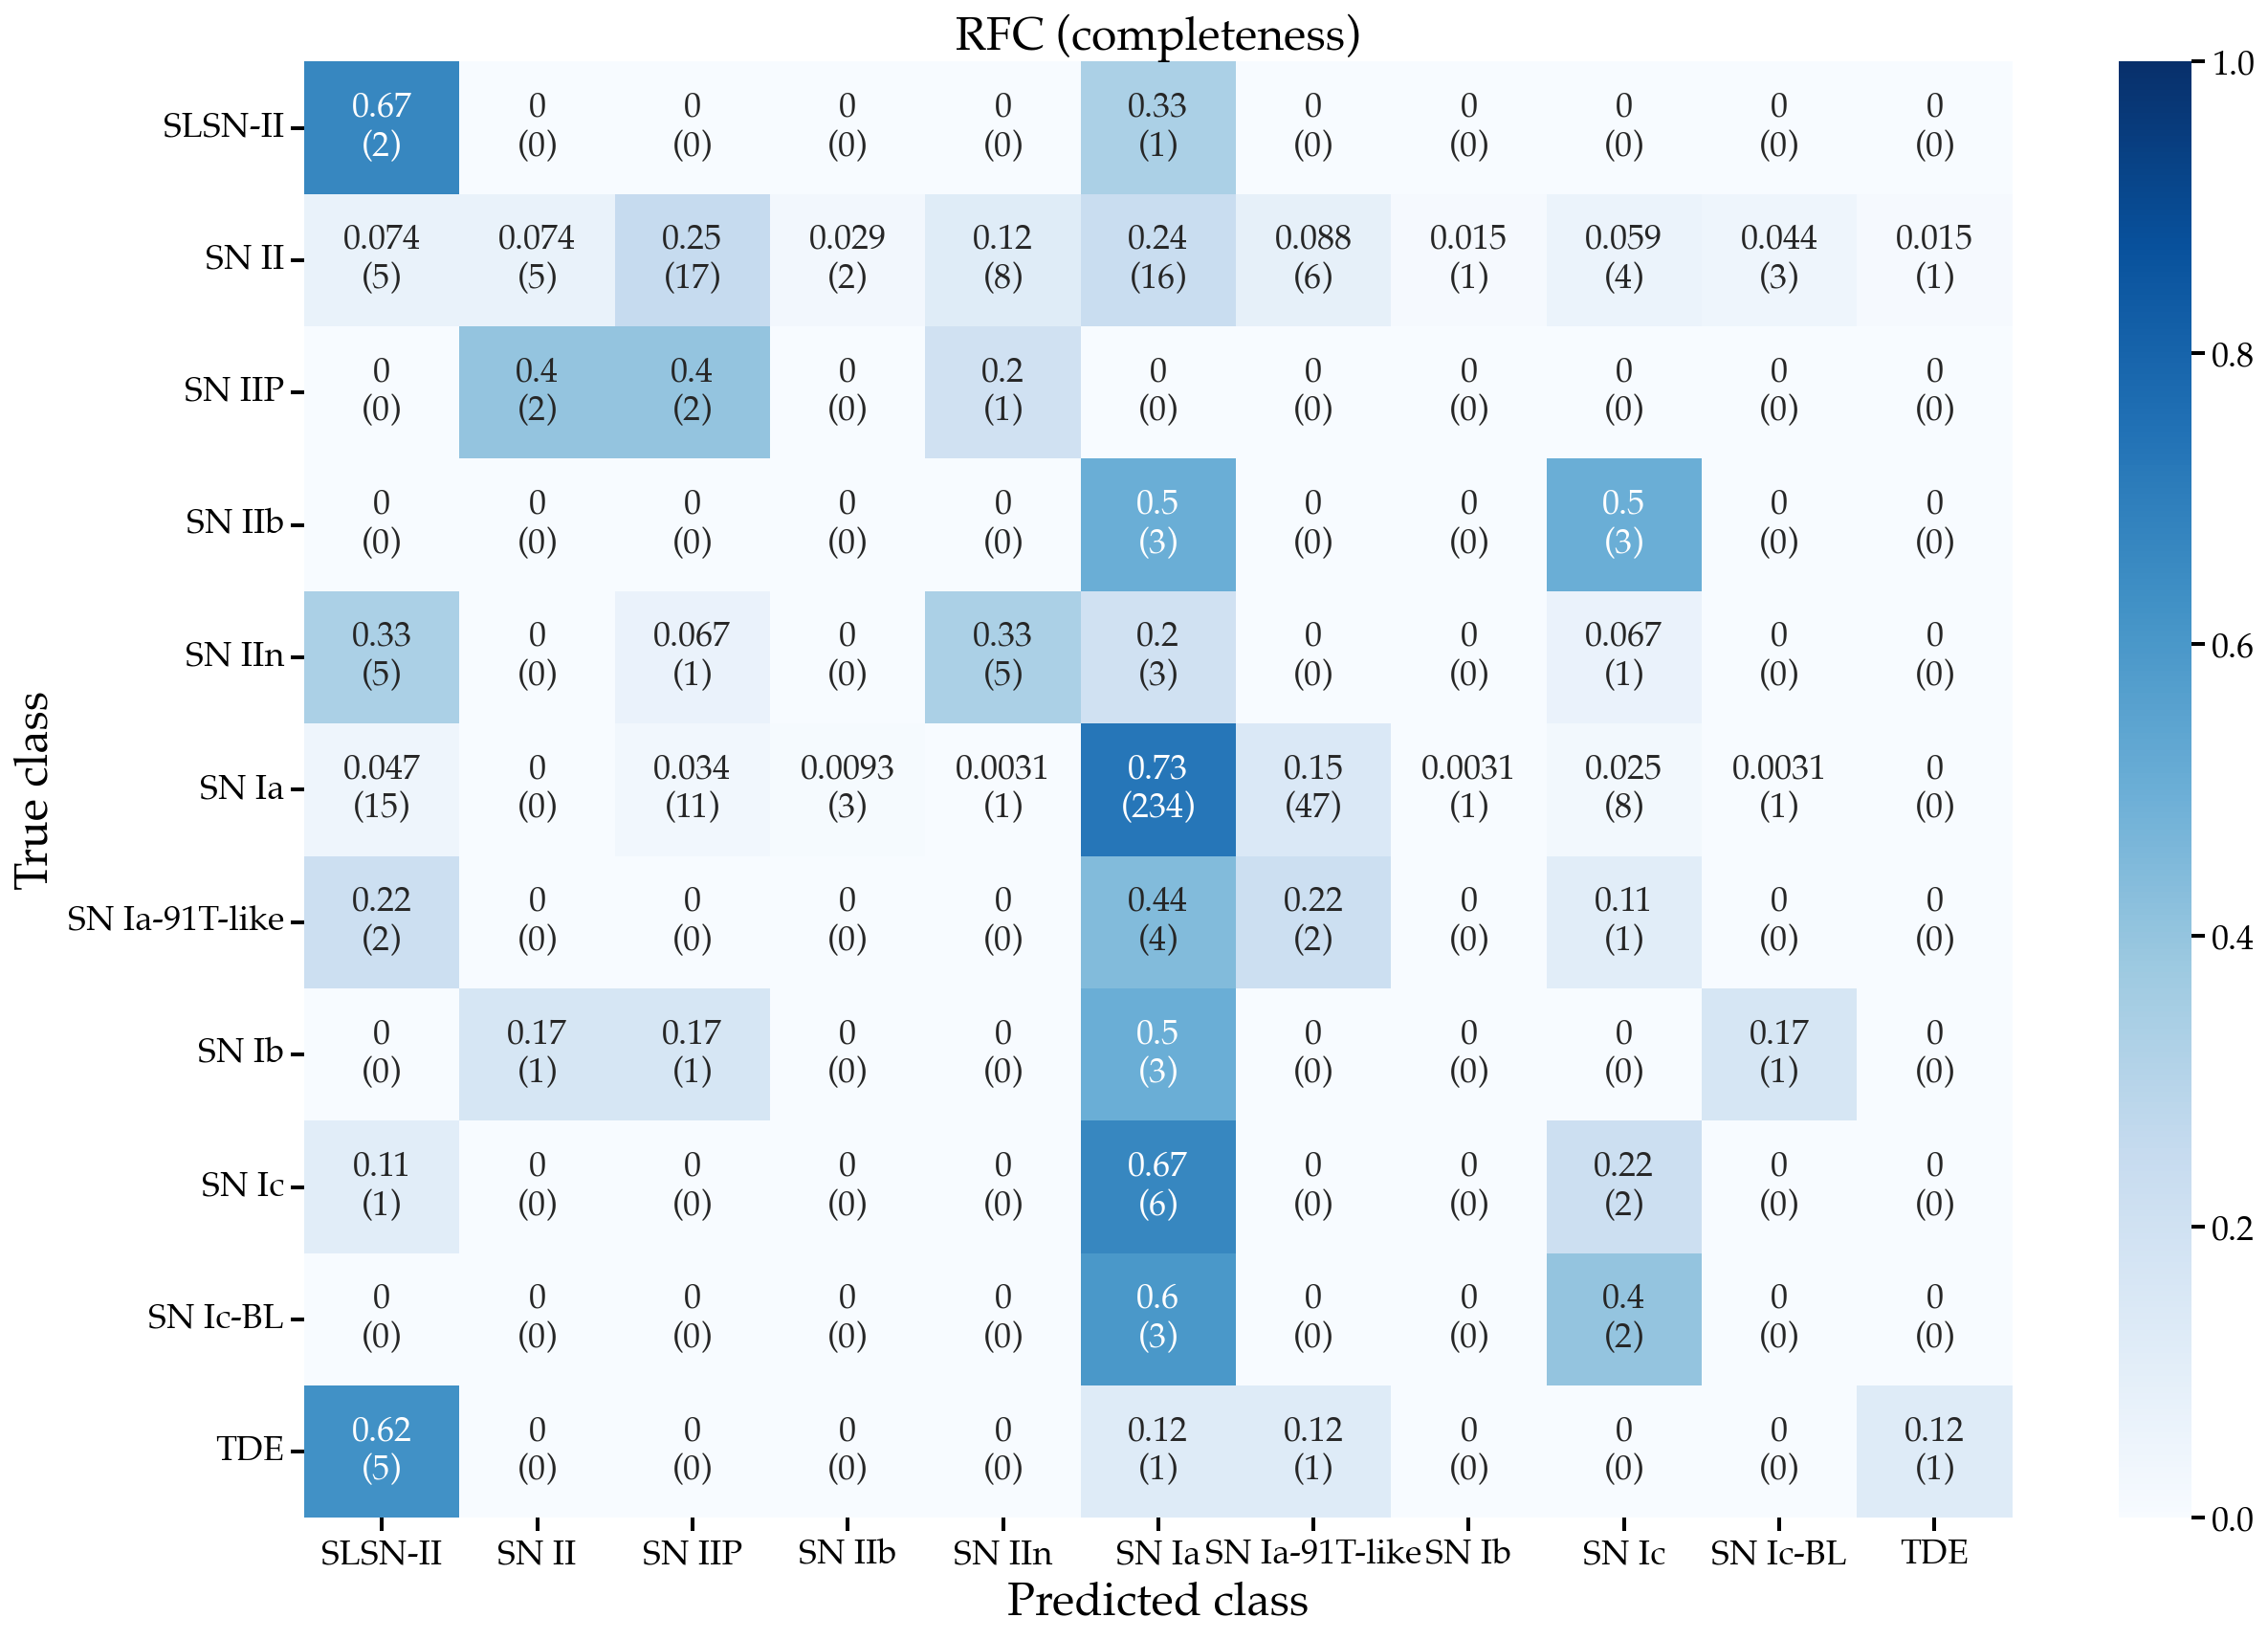

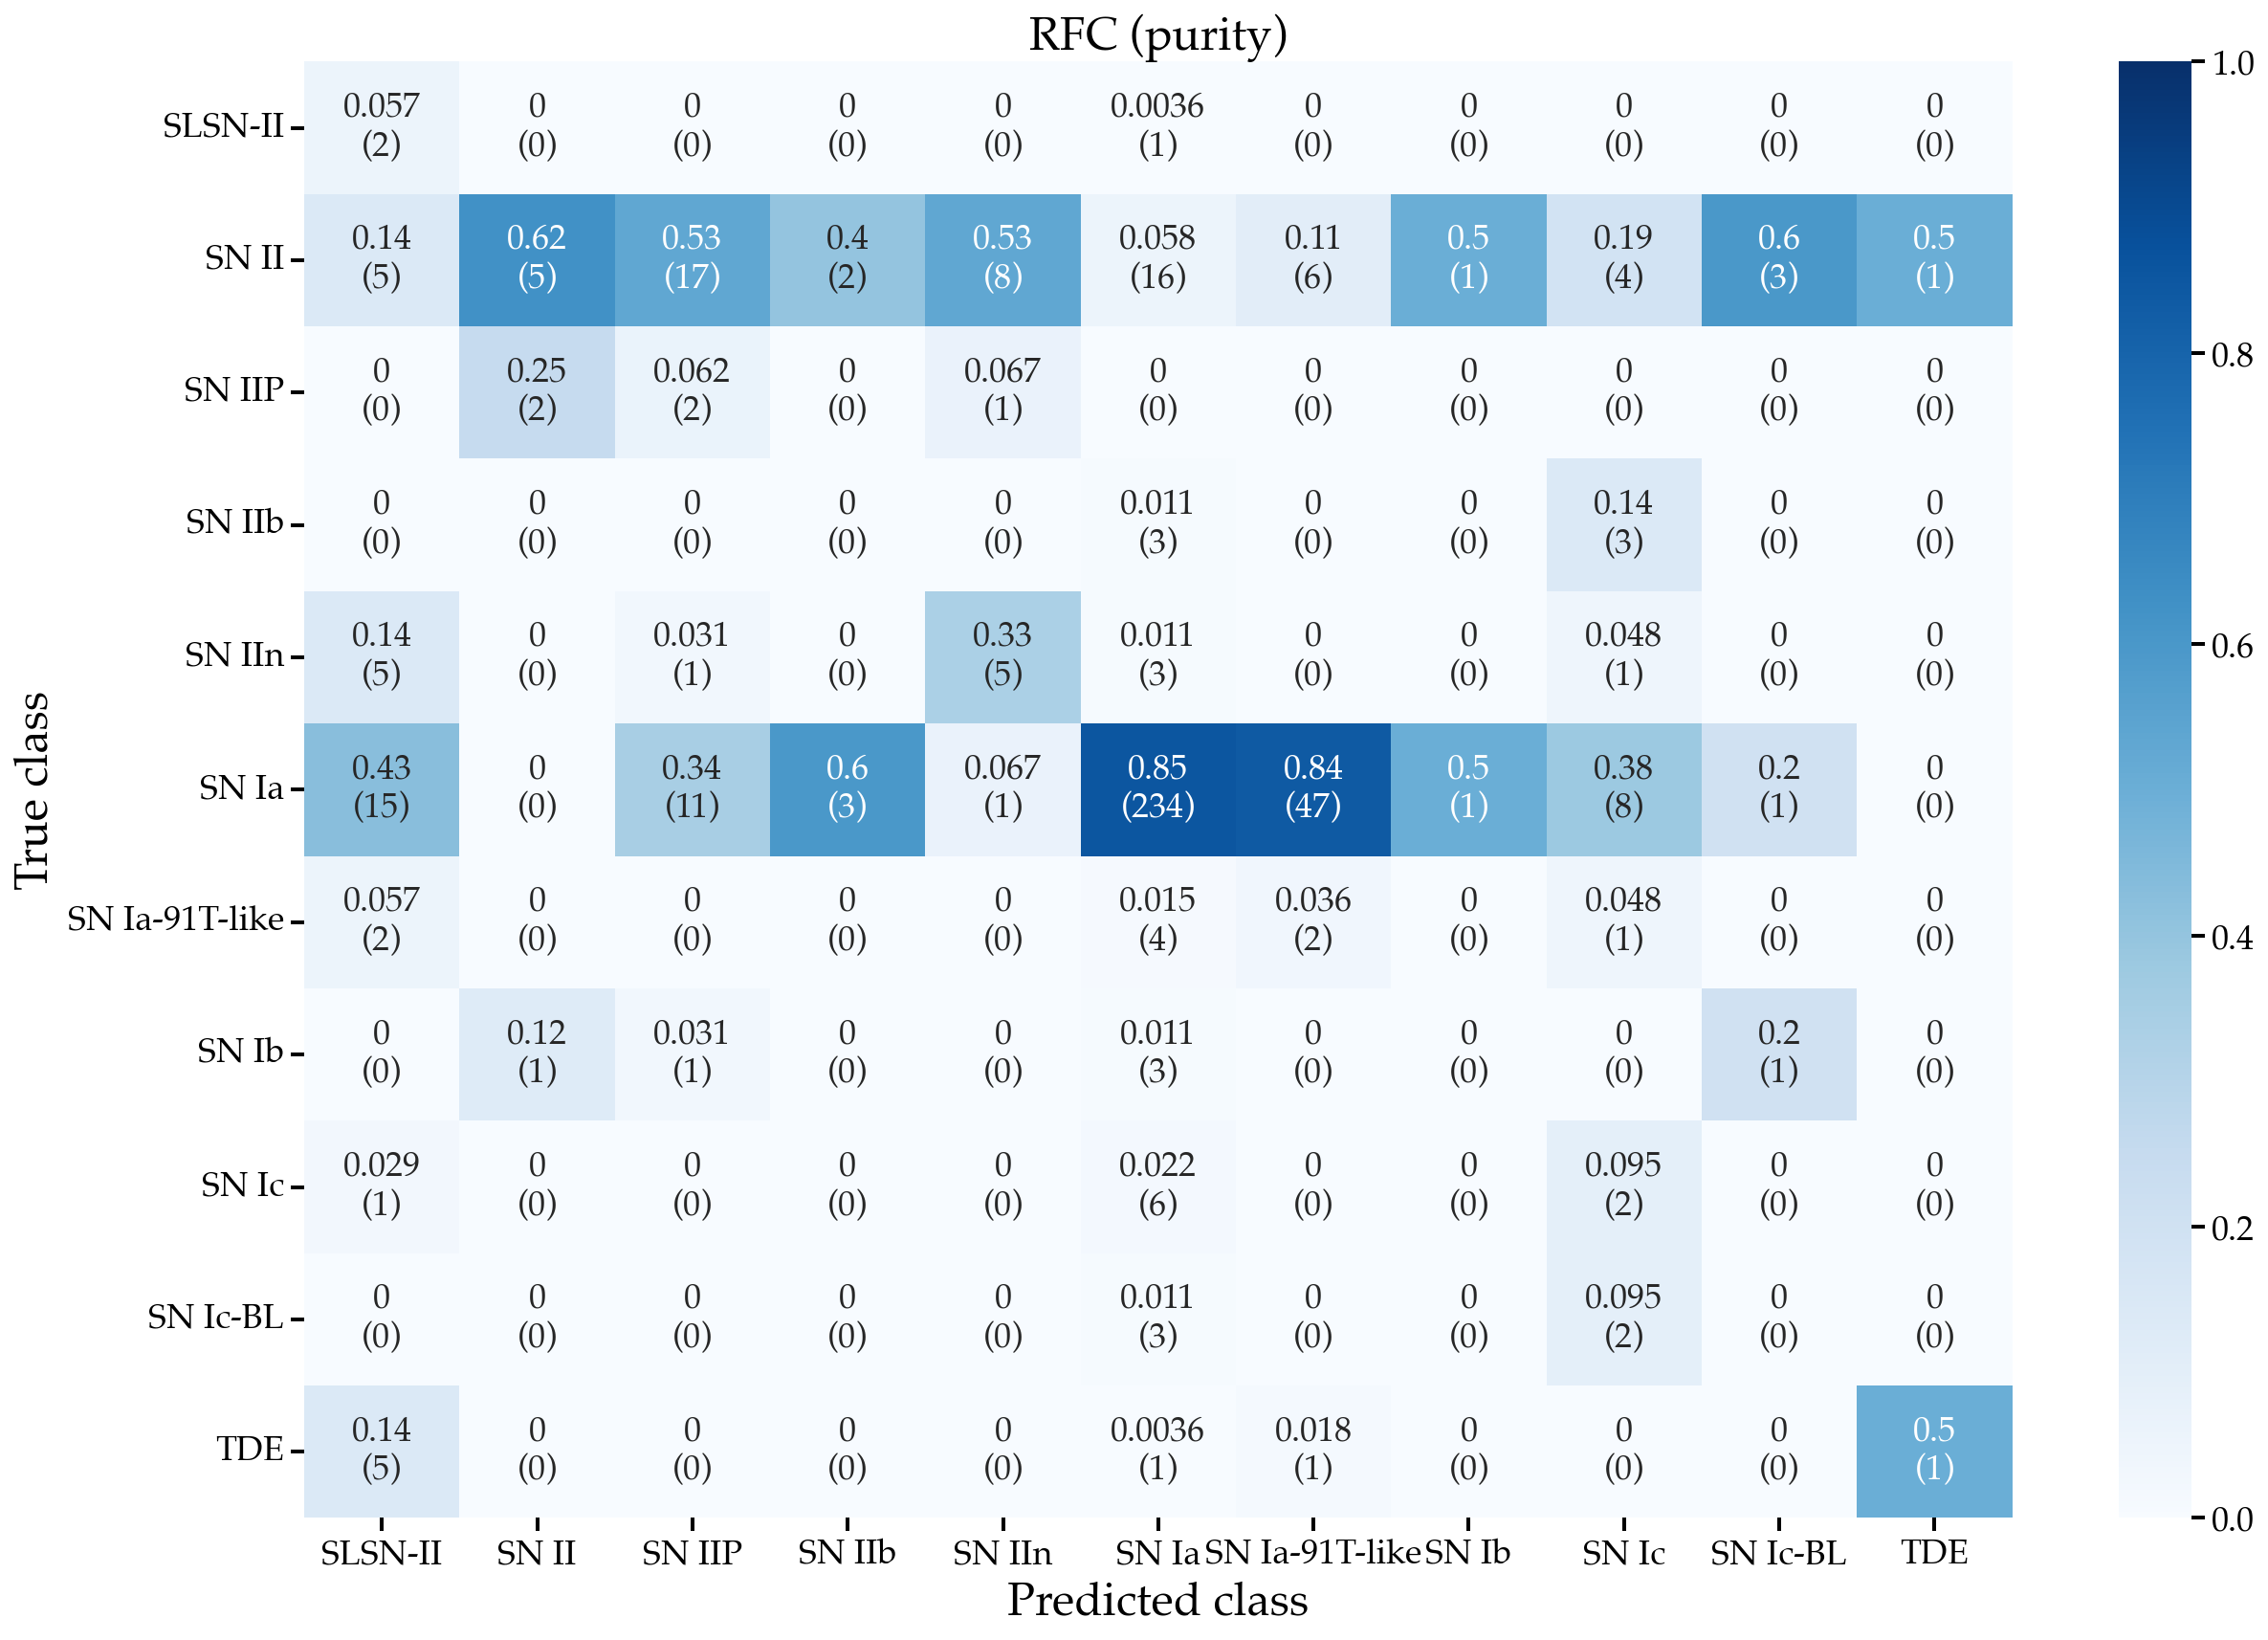

In [18]:
# Confusion matrices
title='RFC'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

folder_path = f"../figures/confusion_matrix/{suffix}/n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}__max_features={max_features}/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [19]:
sim_class_di = {'CV': 'CV', 
      'SLSN-I': 'SLSN', 
      'SLSN-II': 'SLSN', 
      'SN II': 'SN II', 
      'SN IIP': 'SN II', 
      'SN IIb': 'SN II', 
      'SN IIn': 'SN II',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN Ibc', 
      'SN Ib/c': 'SN Ibc',
      'SN Ibn': 'SN Ibc', 
      'SN Ic': 'SN Ibc',
      'SN Ic-BL': 'SN Ibc', 
      'TDE': 'TDE',
      'None': 'None',
      'SN': 'SN',
      'SN I': 'SN I',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_sim_class = df2.copy()
ann0_ann1_df_noNone_sim_class['tns_cls'] = ann0_ann1_df_noNone_sim_class['tns_cls'].map(sim_class_di)
ann0_ann1_df_noNone_sim_class['RFC_best_cls'] = ann0_ann1_df_noNone_sim_class['RFC_best_cls'].map(sim_class_di)
#ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'].map(sim_class_di)

In [20]:
ann0_ann1_df_noNone_sim_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

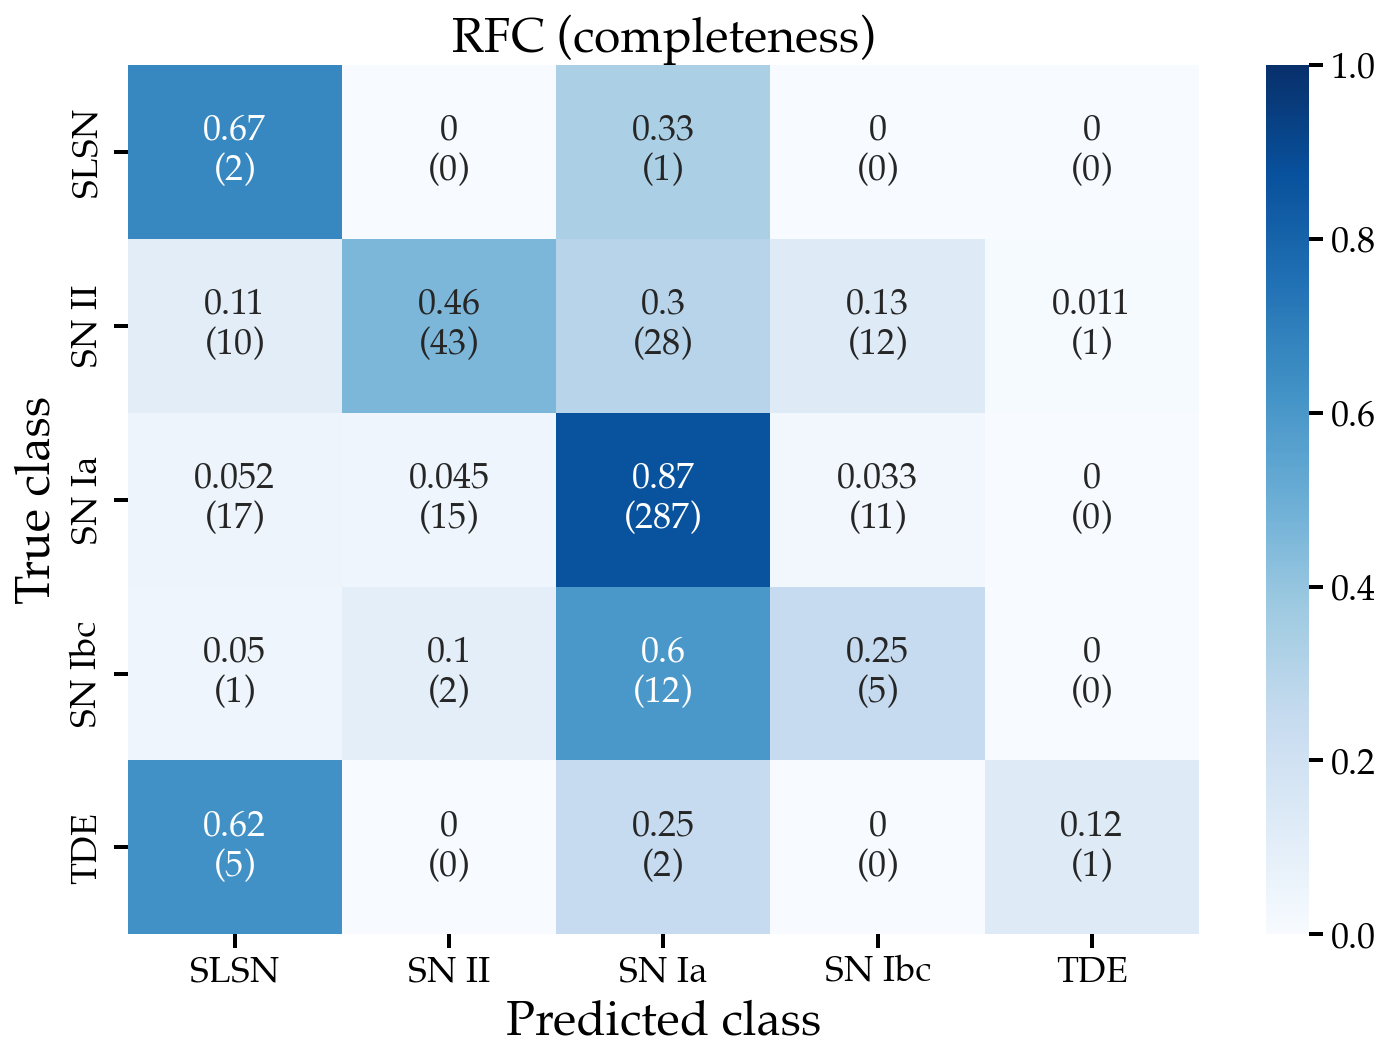

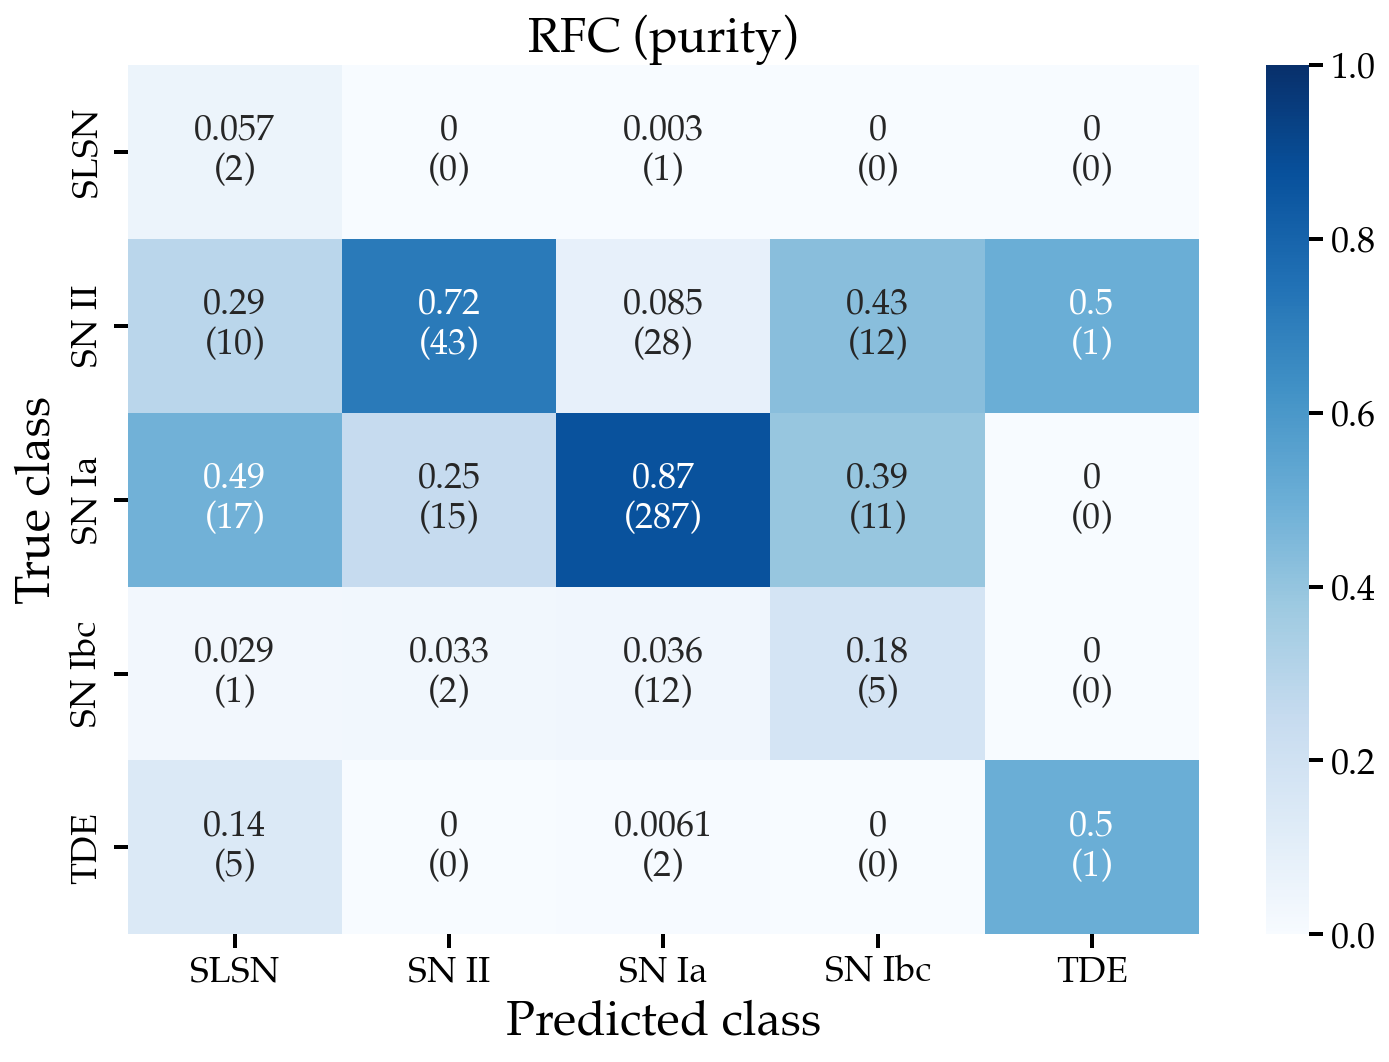

In [21]:
# Confusion matrices
df = ann0_ann1_df_noNone_sim_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(12, 8))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_similar_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [22]:
### CC vs Ia vs Exotic (TDE, SLSN)

bin_class_di = {'CV': 'CV', 
      'SLSN-I': 'Exotic', 
      'SLSN-II': 'Exotic', 
      'SN II': 'SN CC', 
      'SN IIP': 'SN CC', 
      'SN IIb': 'SN CC', 
      'SN IIn': 'SN CC',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN CC', 
      'SN Ib/c': 'SN CC',
      'SN Ibn': 'SN CC', 
      'SN Ic': 'SN CC',
      'SN Ic-BL': 'SN CC', 
      'TDE': 'Exotic',
      'None': 'None',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_bin_class = df2.copy()
ann0_ann1_df_noNone_bin_class['tns_cls'] = ann0_ann1_df_noNone_bin_class['tns_cls'].map(bin_class_di)
ann0_ann1_df_noNone_bin_class['RFC_best_cls'] = ann0_ann1_df_noNone_bin_class['RFC_best_cls'].map(bin_class_di)
#ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'].map(bin_class_di)

In [23]:
mask = (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'AGN') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'CV') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_bin_class = ann0_ann1_df_noNone_bin_class[mask]
ann0_ann1_df_noNone_bin_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

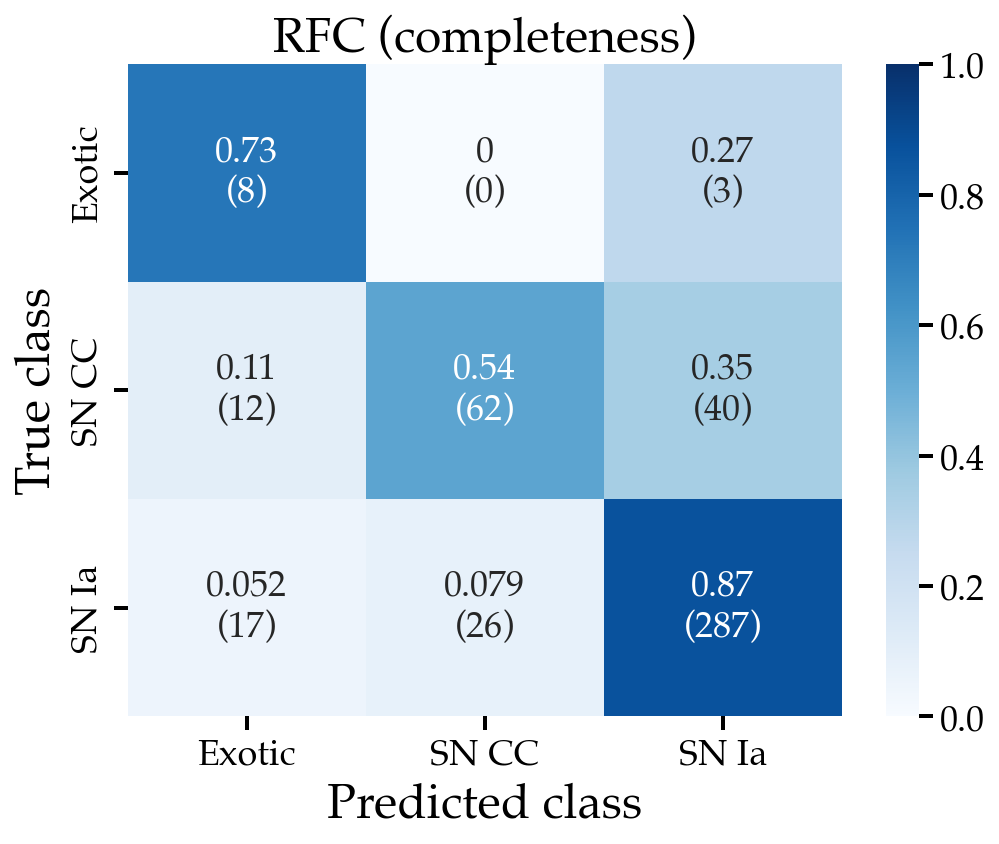

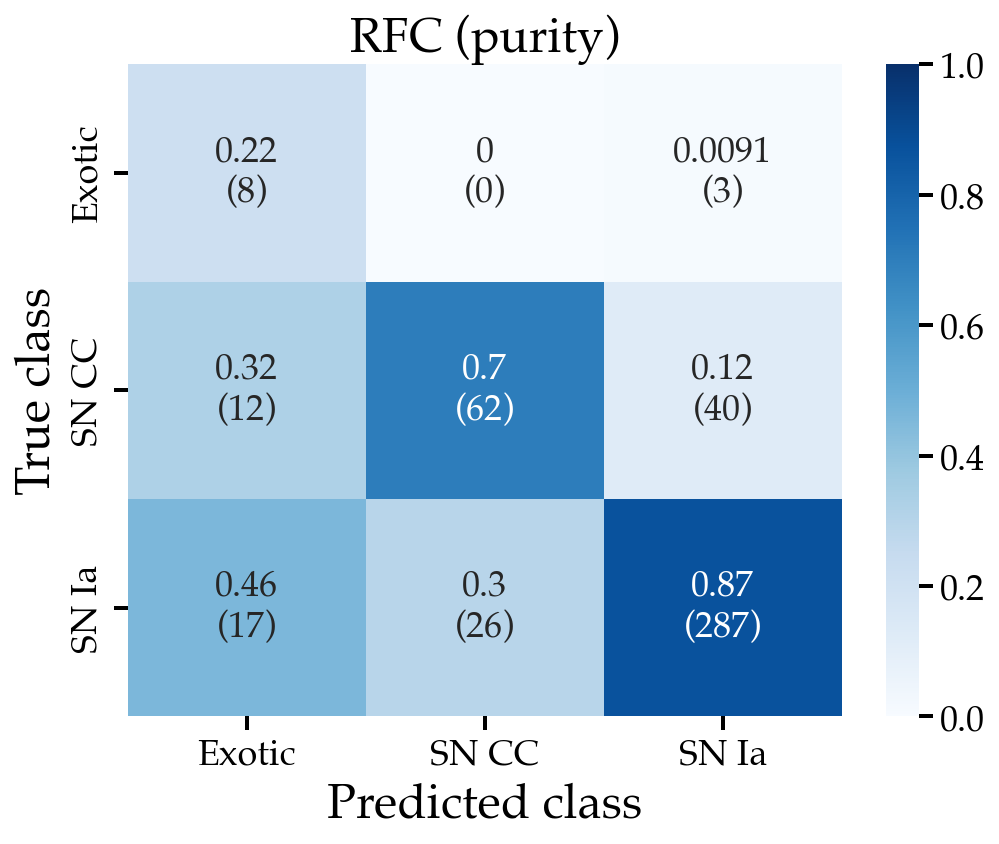

In [24]:
# Confusion matrices
df = ann0_ann1_df_noNone_bin_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(8, 6))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_binary_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Remember, the Ia here are Ia and rare Ia subtypes. Results w/o redshift too! And only 2 pbs

In [25]:
rare_v_not_class_di = {'CV': 'Not SN', 
      'SLSN-I': 'Rare', 
      'SLSN-II': 'Rare', 
      'SN II': 'Rare', 
      'SN IIP': 'Rare', 
      'SN IIb': 'Rare', 
      'SN IIn': 'Rare',
      'SN Ia': 'NOT Rare', 
      'SN Ia-91T-like': 'Rare', 
      'SN Ia-CSM': 'Rare',
      'SN Ia-91bg-like': 'Rare',
      'SN Ia-pec': 'Rare', 
      'SN Ib': 'Rare', 
      'SN Ib/c': 'Rare',
      'SN Ibn': 'Rare',
      'SN Ic': 'Rare',
      'SN Ic-BL': 'Rare', 
      'TDE': 'Rare',
      'None': 'NOT Rare',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'Not SN'}


ann0_ann1_df_noNone_rare_v_not_class = df2.copy()
ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] = ann0_ann1_df_noNone_rare_v_not_class['tns_cls'].map(rare_v_not_class_di)
ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'] = ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'].map(rare_v_not_class_di)
#ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'].map(rare_v_not_class_di)

In [26]:
mask = (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Not SN') & (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_rare_v_not_class = ann0_ann1_df_noNone_rare_v_not_class[mask]
ann0_ann1_df_noNone_rare_v_not_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

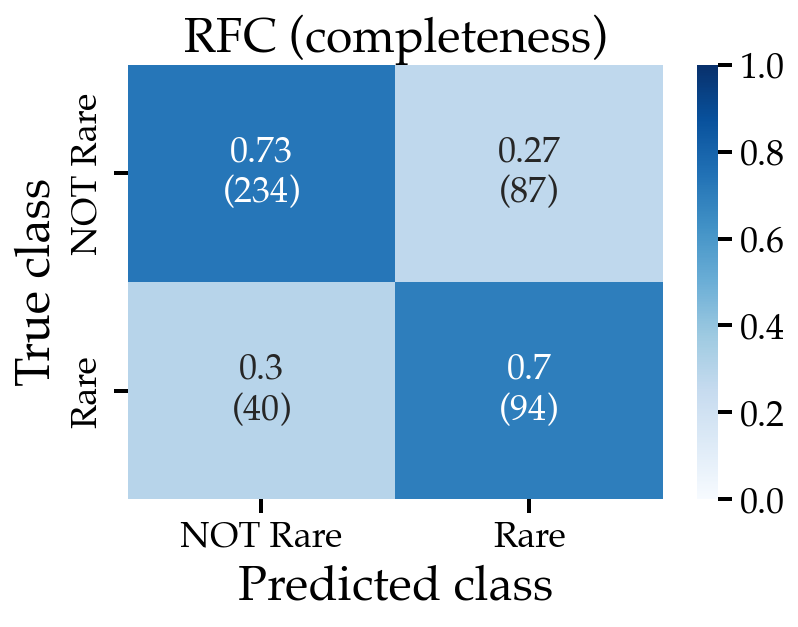

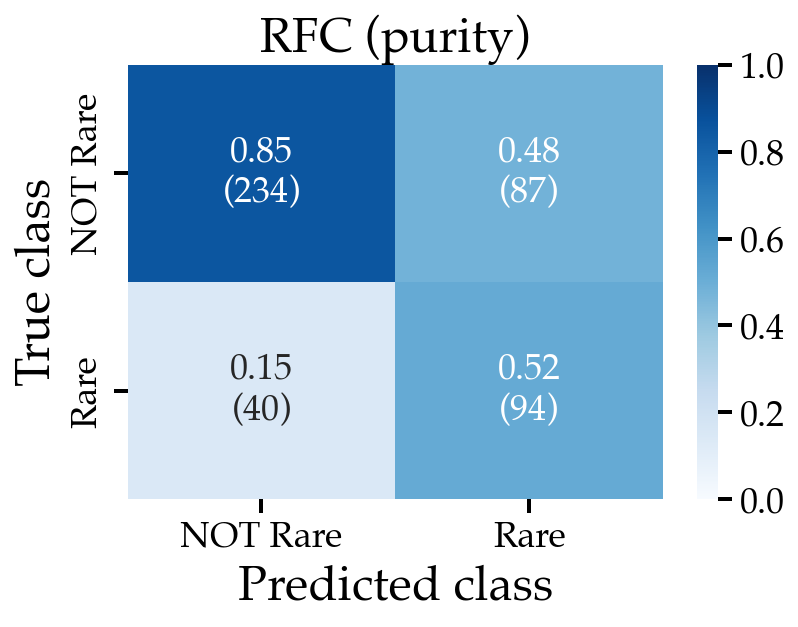

In [27]:
# Confusion matrices
df = ann0_ann1_df_noNone_rare_v_not_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls']) #np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(6, 4))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_rare_v_not_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Remember, the Ia here is Ia-norm ONLY. The rare Ia subtypes are in the "Rare" classification. Results w/o redshift too! And only 2 pbs

In [28]:
%%time 
# In summary, you train your Random Forest Classifier to classify your data, 
# and then use the Isolation Forest algorithm on the output probabilities of the Random Forest Classifier 
# to detect anomalies.

from sklearn.ensemble import IsolationForest

anomaly_scores = IsolationForest(n_estimators=500, random_state=10).fit(predicted_probability).decision_function(predicted_probability)

CPU times: user 776 ms, sys: 32.7 ms, total: 808 ms
Wall time: 663 ms


In [29]:
most_anomalous_indices = np.argsort(anomaly_scores)[:25]
most_anomalous_samples = df2.iloc[most_anomalous_indices]
most_anomalous_samples

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aabfwwl                   0.355211   
ZTF22aaaepao                   0.121577   
ZTF21abjamta                   0.254651   
ZTF21aavrvuj                   0.242250   
ZTF21aaquhqr                   0.295009   
ZTF21abccaue                   0.259191   
ZTF21aaxxoei                   0.464309   
ZTF20aciuftf                   0.199934   
ZTF21aautijg                   0.678457   
ZTF21aaagypx                   0.588448   
ZTF21aapkhsc                   1.413270   
ZTF18acvgjqv                   1.061049   
ZTF21aabygea                   1.121072   
ZTF21aakigqr                   0.339321   
ZTF22aaaedas                   0.267684   
ZTF21aaxtzzj                   0.228750   
ZTF18actuhrs                   1.878891   
ZTF21acqyqwu                   0.164925   
ZTF20acwofhd                   1.111611   
ZTF21aalydkl                   1.388270   
ZTF21aarjehy                   0.440838   
ZTF21abidxwo                   0.296384   
ZTF20acfvgdp                   0.969461   
ZTF20abrjmgi                   1.755694   
ZTF21abcmtev                   0.453838   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aabfwwl                                 3.085502   
ZTF22aaaepao                                 0.670996   
ZTF21abjamta                                 0.393335   
ZTF21aavrvuj                                 0.419557   
ZTF21aaquhqr                                 1.530906   
ZTF21abccaue                                 1.356116   
ZTF21aaxxoei                                 0.744258   
ZTF20aciuftf                                 0.226901   
ZTF21aautijg                                 2.020706   
ZTF21aaagypx                                 1.259935   
ZTF21aapkhsc                                 0.743122   
ZTF18acvgjqv                                 0.732289   
ZTF21aabygea                                 4.941580   
ZTF21aakigqr                                 0.262226   
ZTF22aaaedas                                 0.528615   
ZTF21aaxtzzj                                 0.283518   
ZTF18actuhrs                                 4.315469   
ZTF21acqyqwu                                 0.191106   
ZTF20acwofhd                                 1.231543   
ZTF21aalydkl                                 0.348052   
ZTF21aarjehy                                 0.417393   
ZTF21abidxwo                                 0.248318   
ZTF20acfvgdp                                 6.327722   
ZTF20abrjmgi                                 0.310299   
ZTF21abcmtev                                 0.294889   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aabfwwl                      0.264151                     0.056604   
ZTF22aaaepao                      0.250000                     0.000000   
ZTF21abjamta                      0.500000                     0.000000   
ZTF21aavrvuj                      0.421053                     0.000000   
ZTF21aaquhqr                      0.354167                     0.000000   
ZTF21abccaue                      0.125000                     0.125000   
ZTF21aaxxoei                      0.303030                     0.030303   
ZTF20aciuftf                      0.428571                     0.000000   
ZTF21aautijg                      0.171429                     0.057143   
ZTF21aaagypx                      0.236842                     0.039474   
ZTF21aapkhsc                      0.461538                     0.000000   
ZTF18acvgjqv                      0.375000                     0.031250   
ZTF21aabygea                      0.173913                     0.086957   
ZTF21aakigqr                      0.200000                     0.050000   
ZTF22aaaedas                      0.375000                     0.000000   
ZTF21aaxtzzj                      0.37

In [30]:
for obj, cls, rfc_cls in zip(most_anomalous_samples.index, most_anomalous_samples.tns_cls, most_anomalous_samples.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, rfc_cls)

https://alerce.online/object/ZTF21aabfwwl SN II SN II
https://alerce.online/object/ZTF22aaaepao SN II SN IIP
https://alerce.online/object/ZTF21abjamta SN II SN IIP
https://alerce.online/object/ZTF21aavrvuj SN II SN IIP
https://alerce.online/object/ZTF21aaquhqr SN II SN IIP
https://alerce.online/object/ZTF21abccaue SN Ib SN II
https://alerce.online/object/ZTF21aaxxoei SN II SN II
https://alerce.online/object/ZTF20aciuftf SN Ia SN Ia
https://alerce.online/object/ZTF21aautijg SN IIn SLSN-II
https://alerce.online/object/ZTF21aaagypx SN IIP SN II
https://alerce.online/object/ZTF21aapkhsc SN Ia SN Ia
https://alerce.online/object/ZTF18acvgjqv SN IIn SLSN-II
https://alerce.online/object/ZTF21aabygea SN II SN IIn
https://alerce.online/object/ZTF21aakigqr SN II SN IIP
https://alerce.online/object/ZTF22aaaedas TDE SLSN-II
https://alerce.online/object/ZTF21aaxtzzj SN II SN II
https://alerce.online/object/ZTF18actuhrs SN Ia SN IIn
https://alerce.online/object/ZTF21acqyqwu SN Ib SN IIP
https://alerc

In [31]:
# All long lived or big color difference

In [32]:
Counter(most_anomalous_samples['tns_cls'])

Counter({'SN II': 13,
         'SN Ib': 2,
         'SN Ia': 5,
         'SN IIn': 2,
         'SN IIP': 1,
         'TDE': 1,
         'SN Ic': 1})

In [33]:
Counter(most_anomalous_samples['RFC_best_cls'])

Counter({'SN II': 5,
         'SN IIP': 9,
         'SN Ia': 3,
         'SLSN-II': 3,
         'SN IIn': 2,
         'SN Ic': 1,
         'SN IIb': 1,
         'SN Ib': 1})

### Feature importance

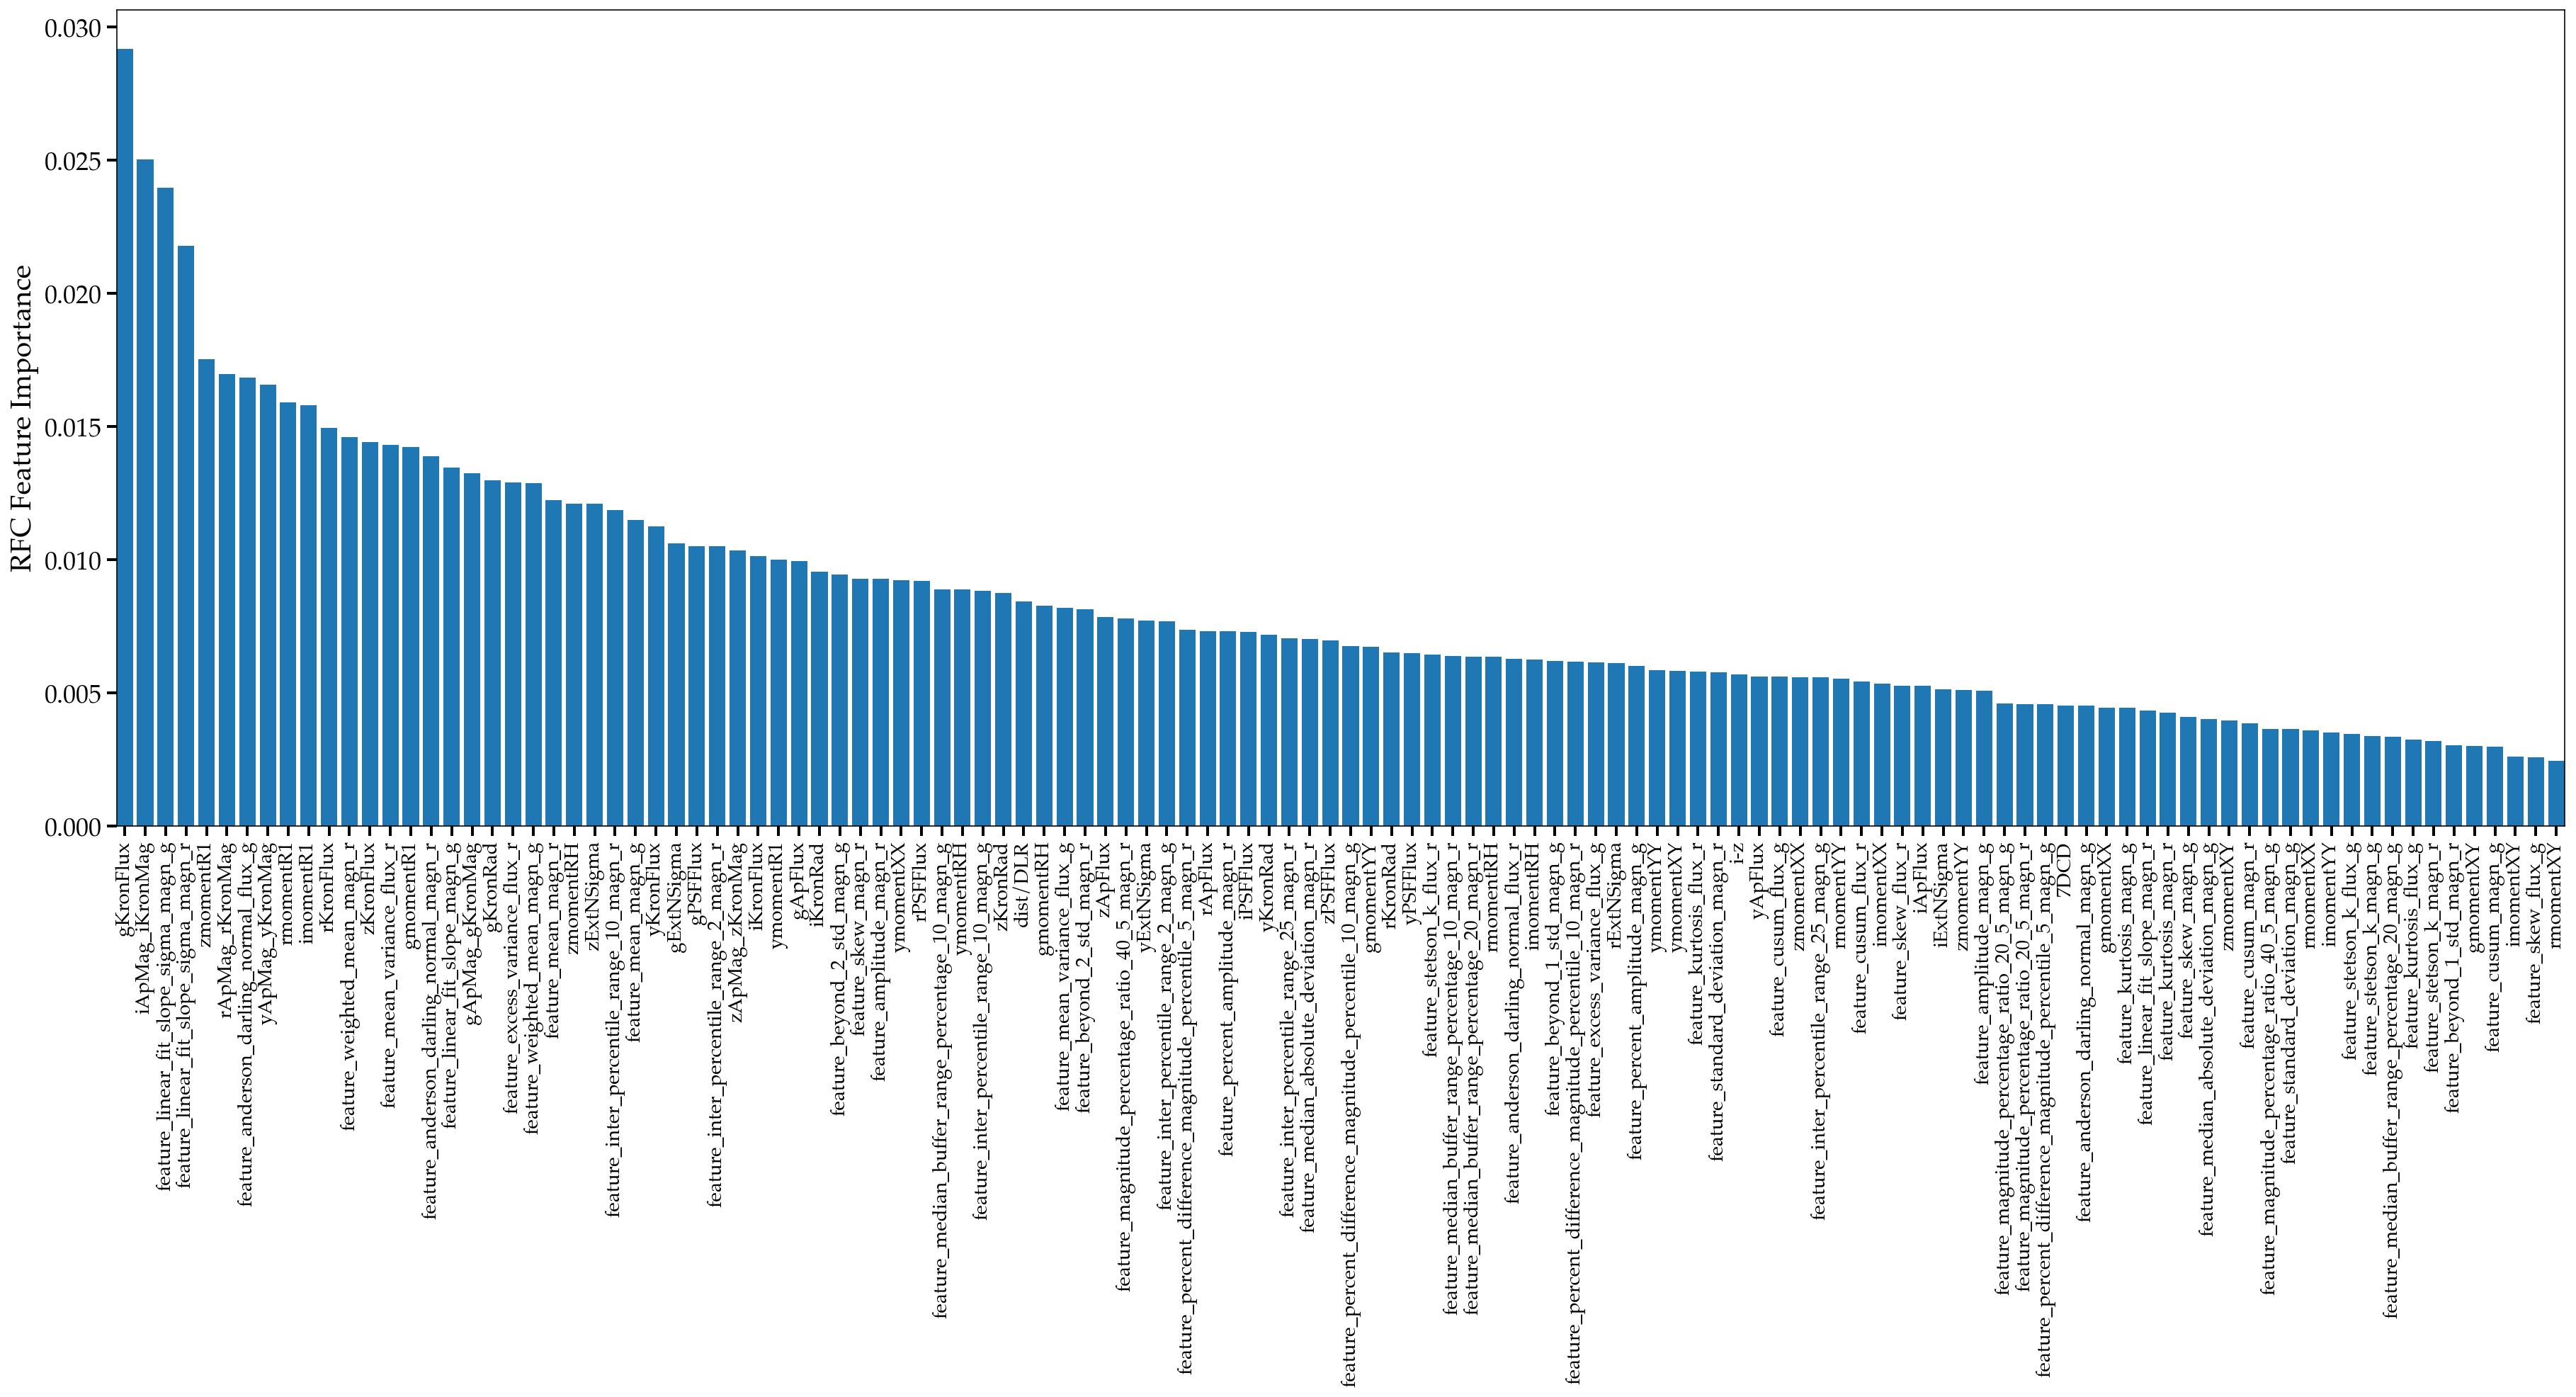

In [34]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

X_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]

fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(range(X_train.shape[1]), importances[indices])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90, fontsize=14)
plt.subplots_adjust(left=0.0, right=1, top=1.0, bottom=0)
ax.set_xlim(left=-0.40, right=119.4)
plt.ylabel('RFC Feature Importance')
plt.savefig(f'{folder_path}/RFC_feature_importance_horizontal.jpg', dpi=300, bbox_inches='tight')
plt.show()

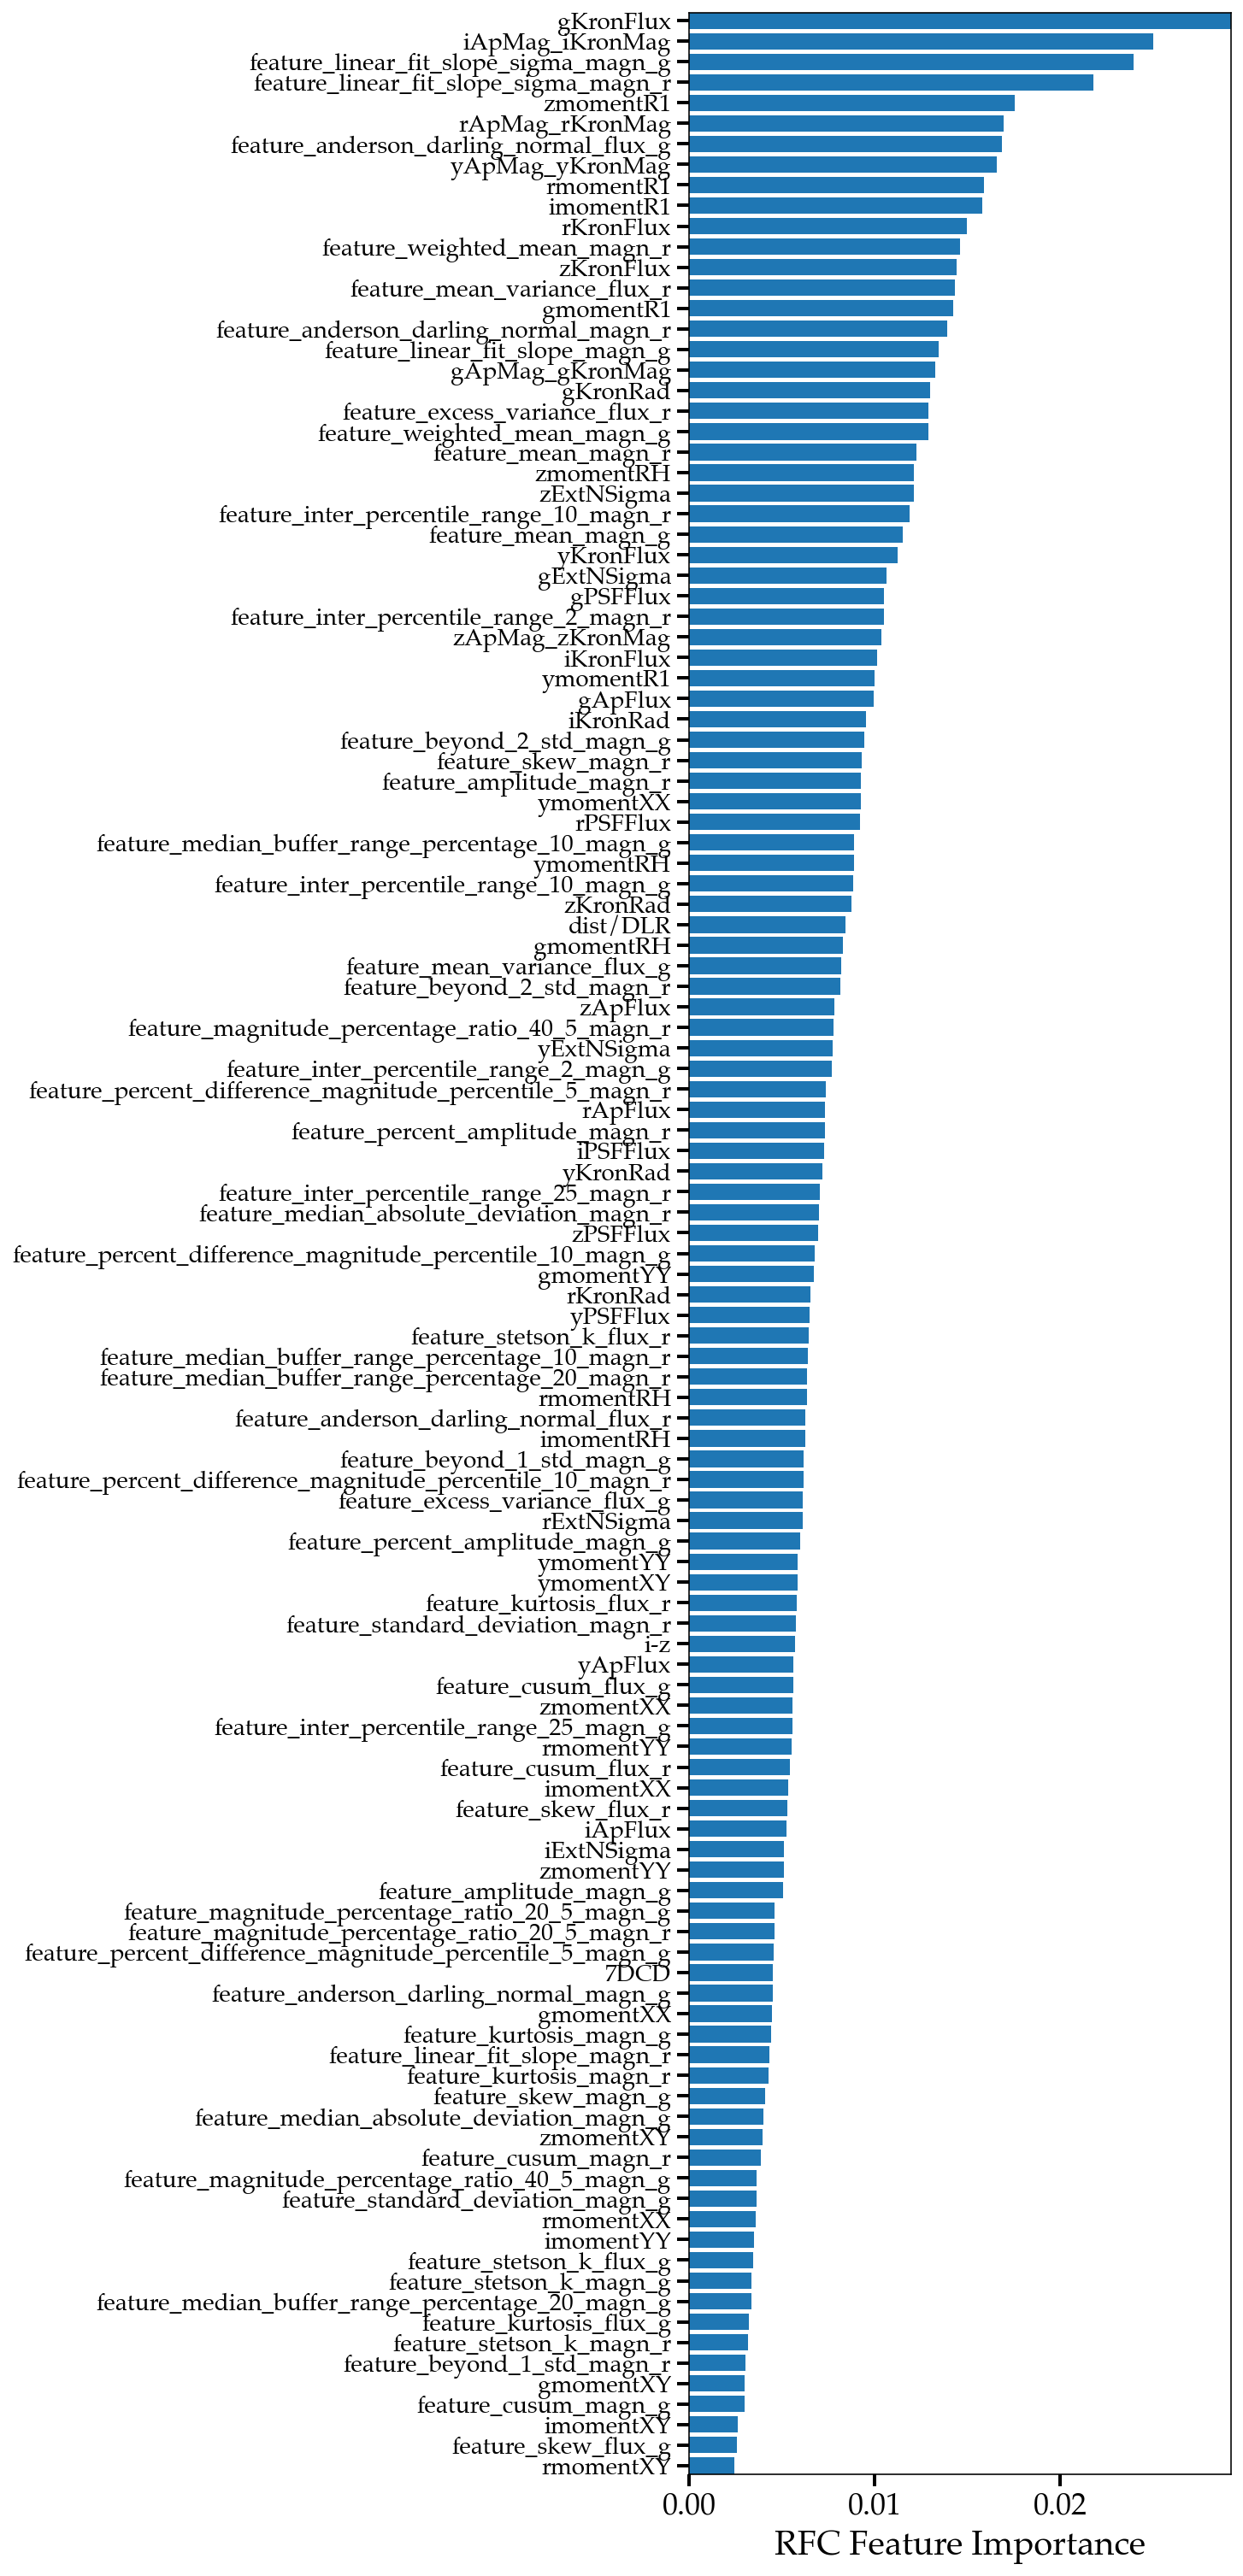

In [35]:
fig, ax = plt.subplots(figsize=(8, 20))
ax.barh(range(X_train.shape[1]), importances[indices][::-1])
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(X_train.columns[indices][::-1], fontsize=14)
plt.subplots_adjust(left=0.4, right=0.95, top=1.0, bottom=0)
ax.set_ylim(top=119.4, bottom=-0.40)
ax.set_xlim(right=np.max(importances[indices][::-1]))
plt.xlabel('RFC Feature Importance')
plt.savefig(f'{folder_path}/RFC_feature_importance_vertical.jpg', dpi=300, bbox_inches='tight')
plt.show()

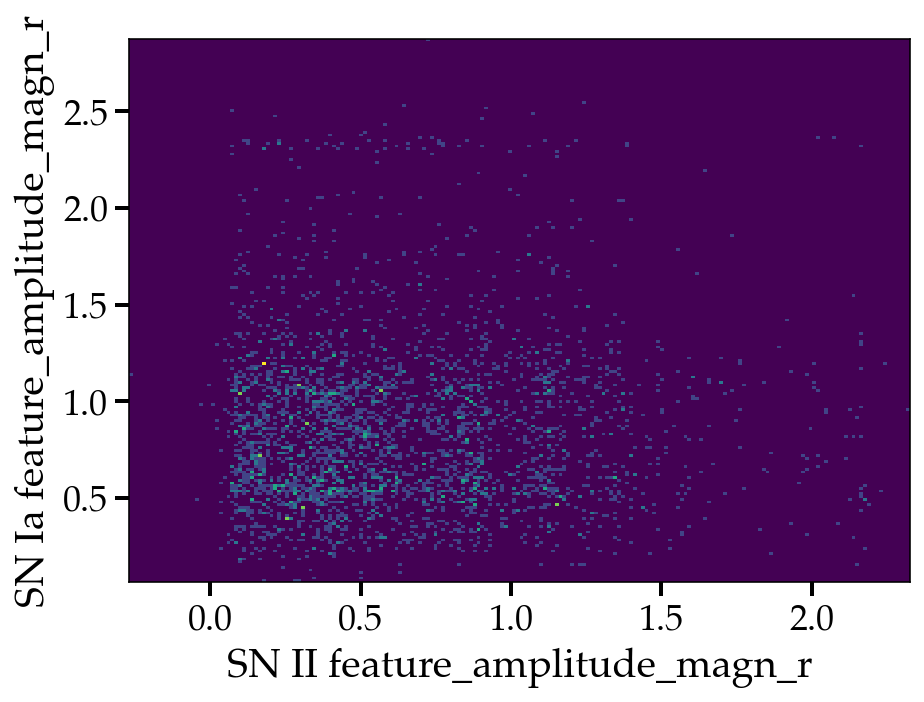

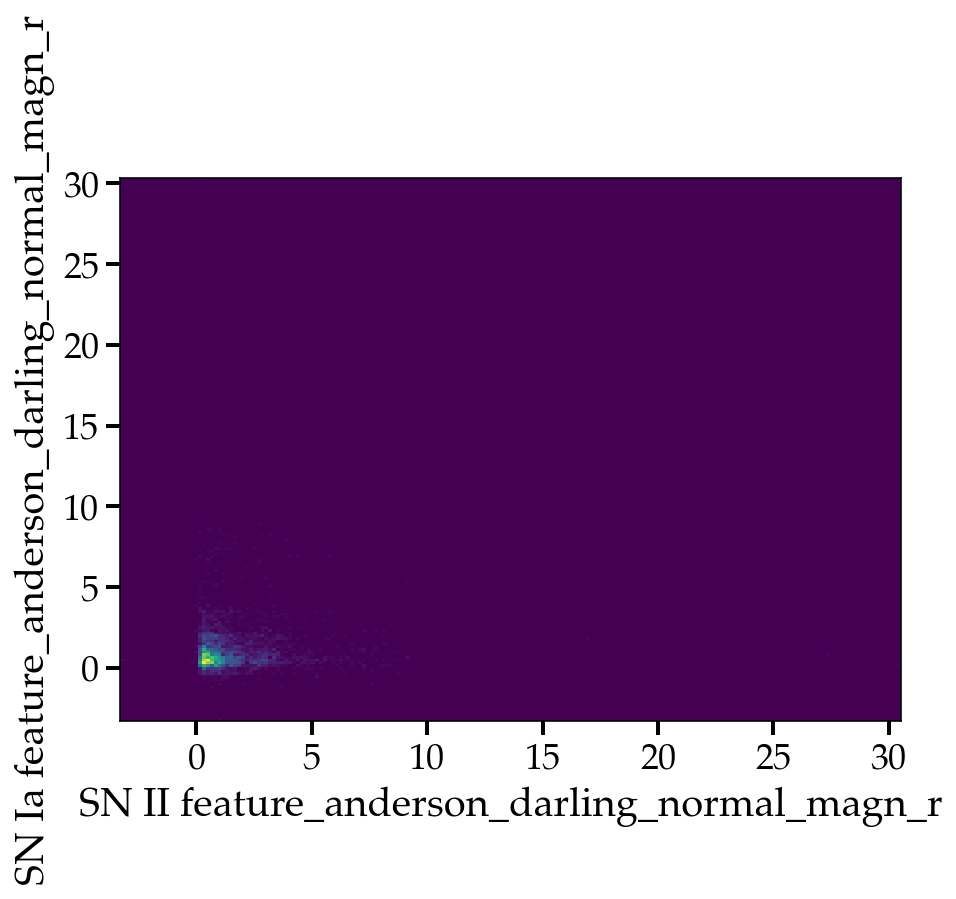

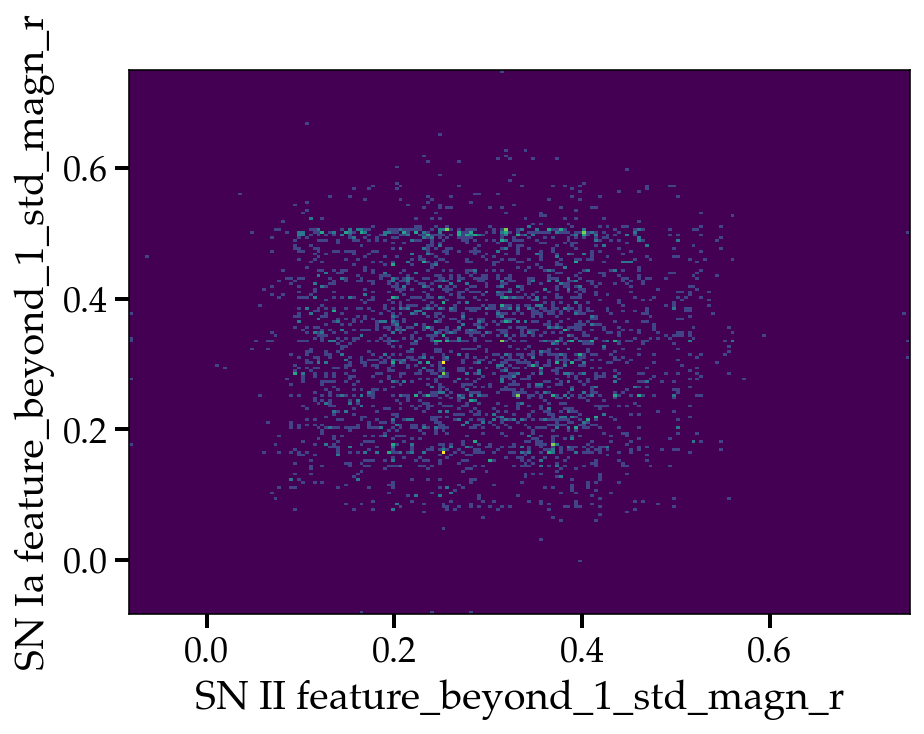

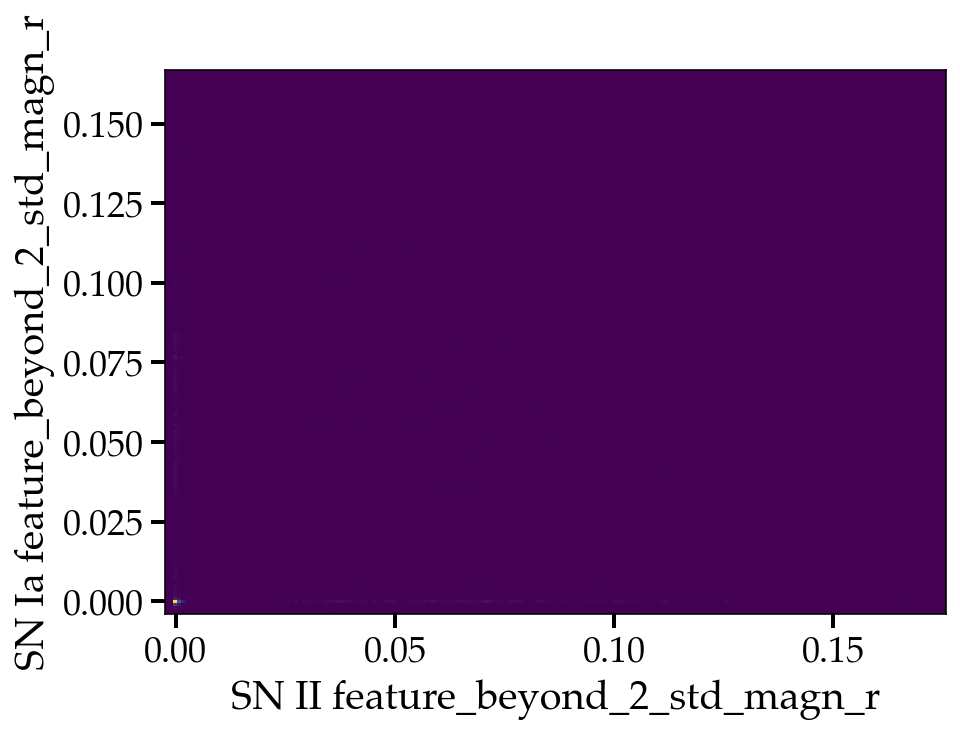

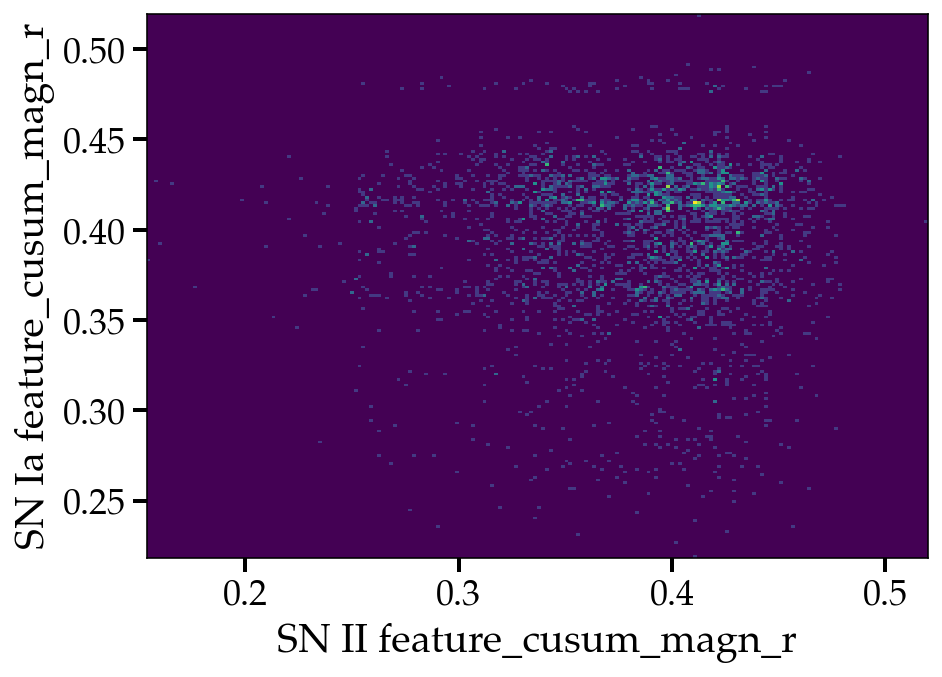

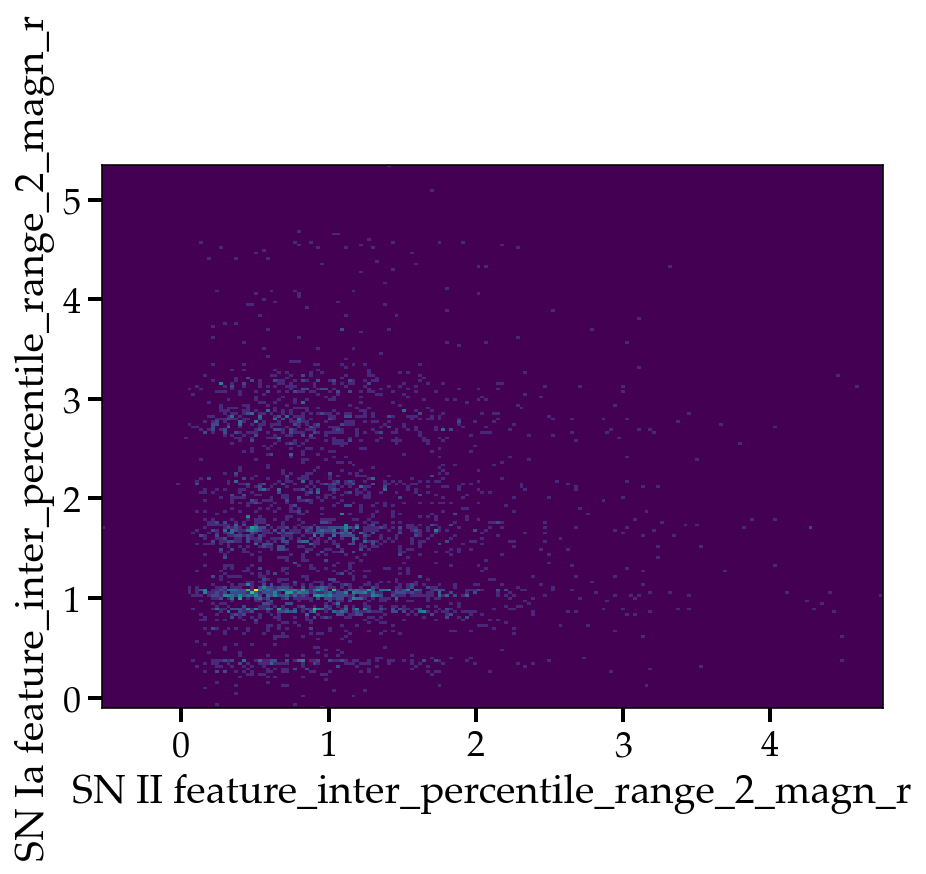

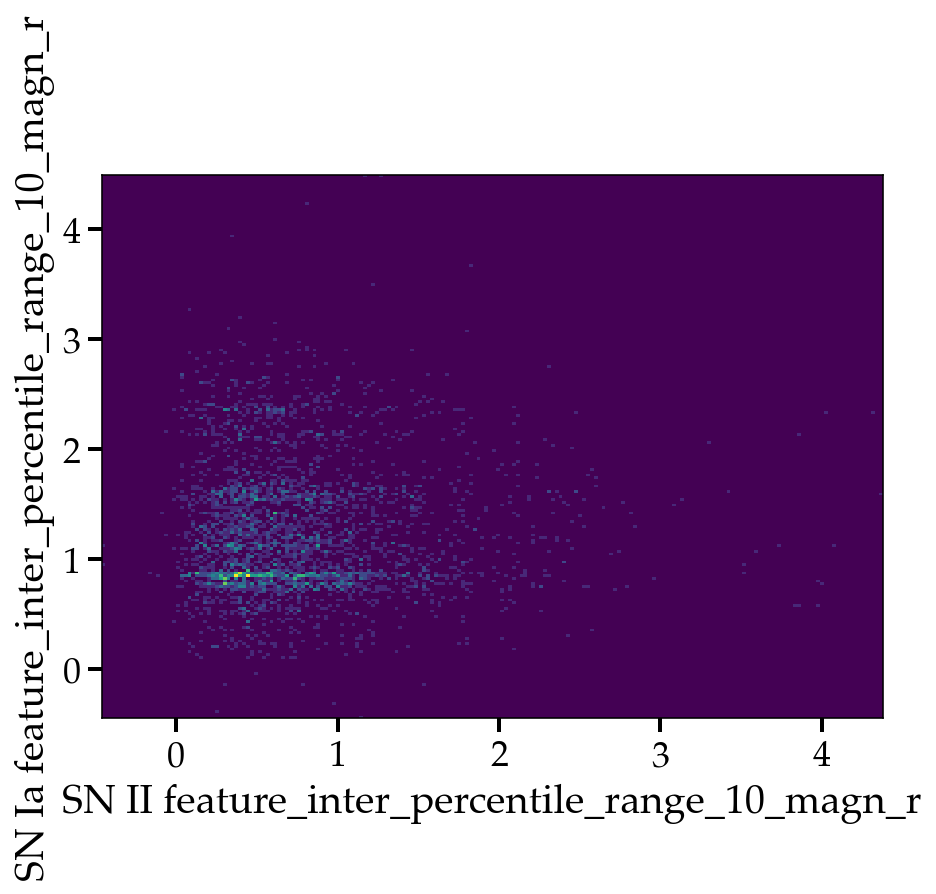

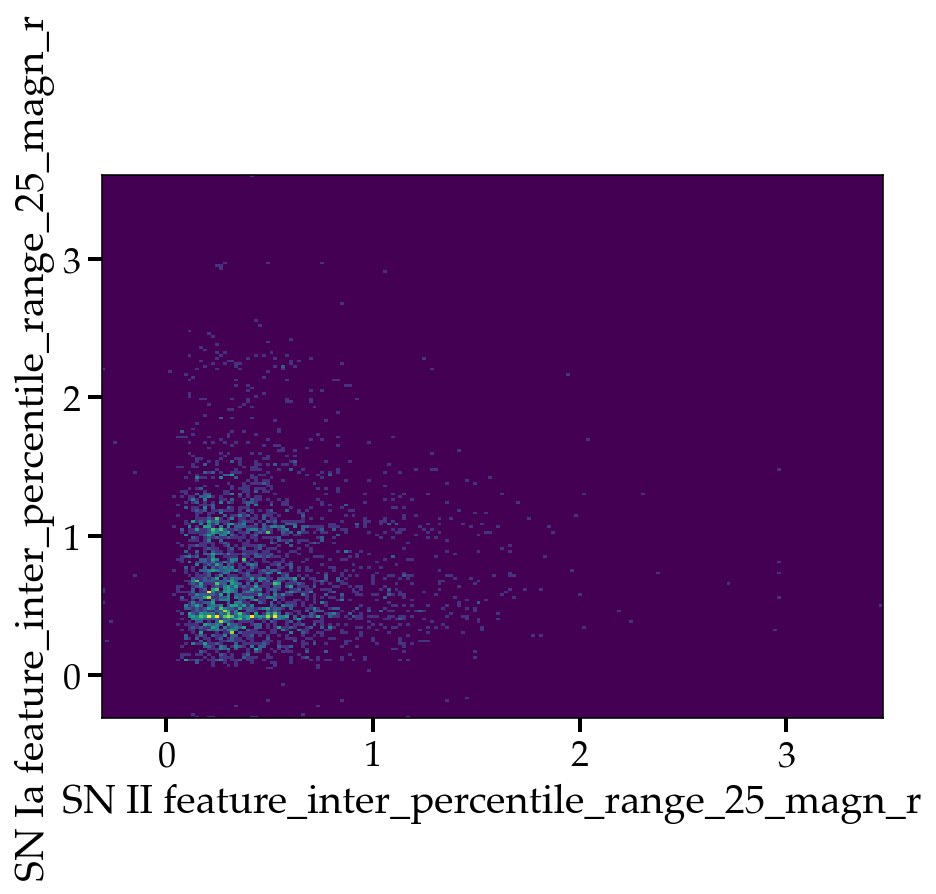

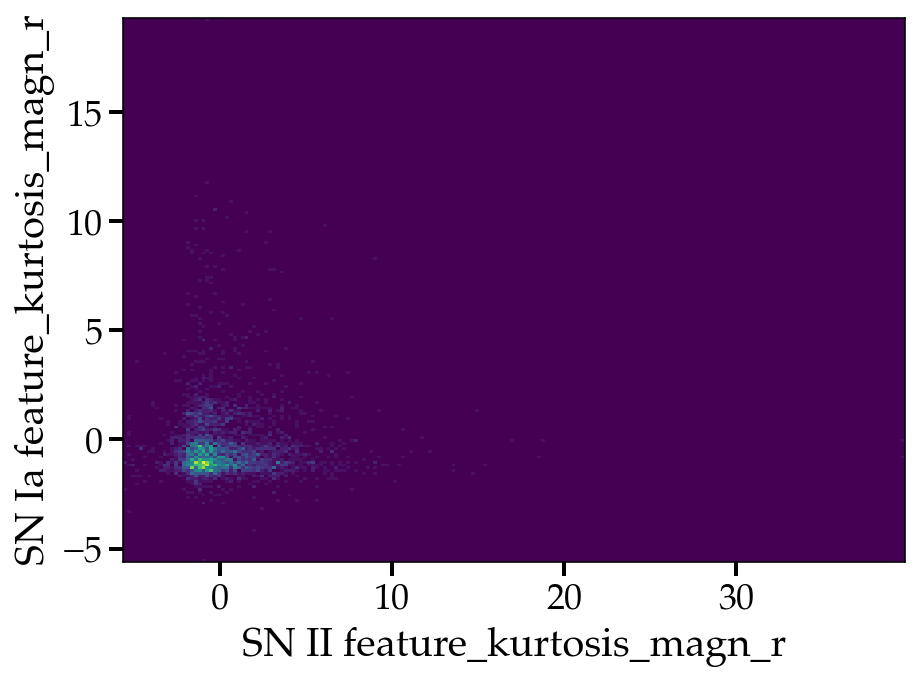

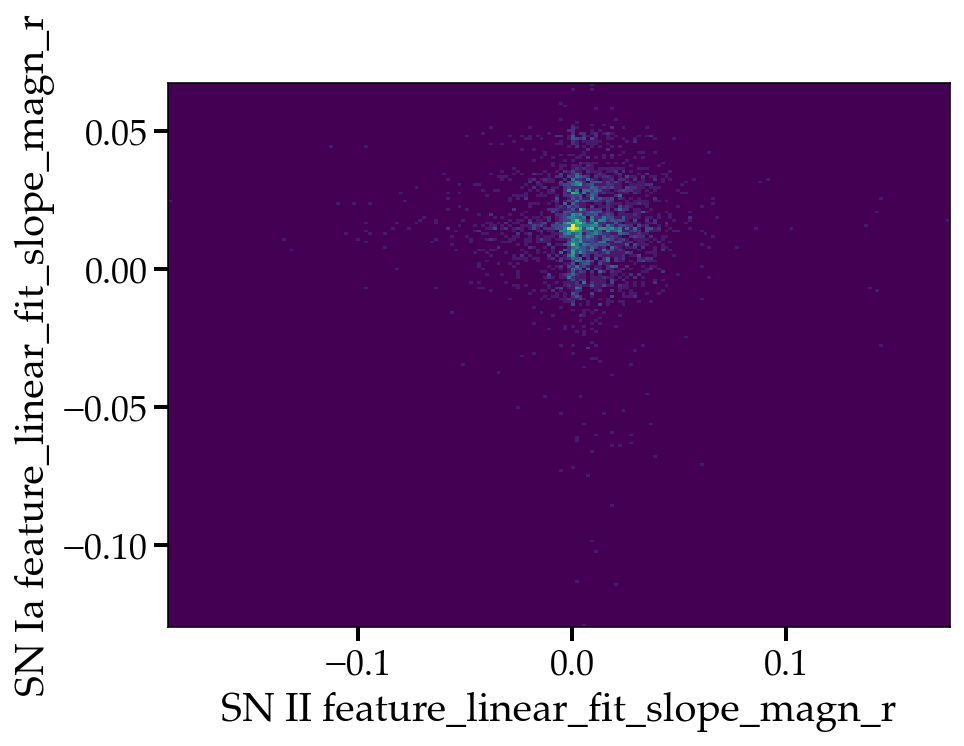

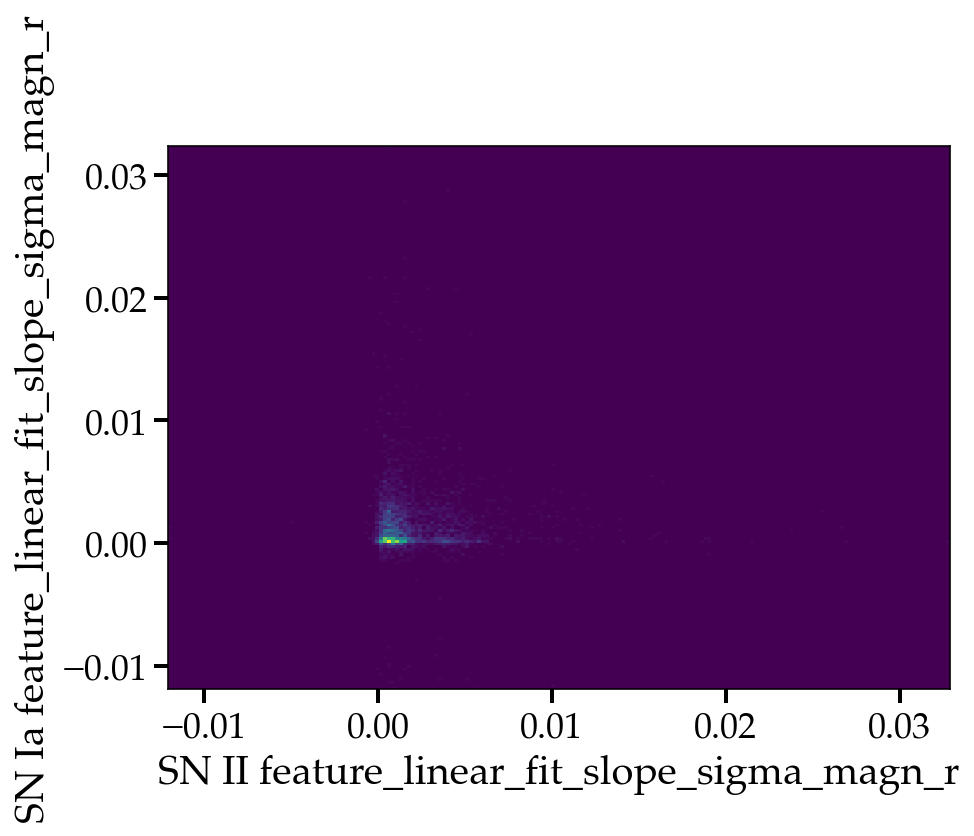

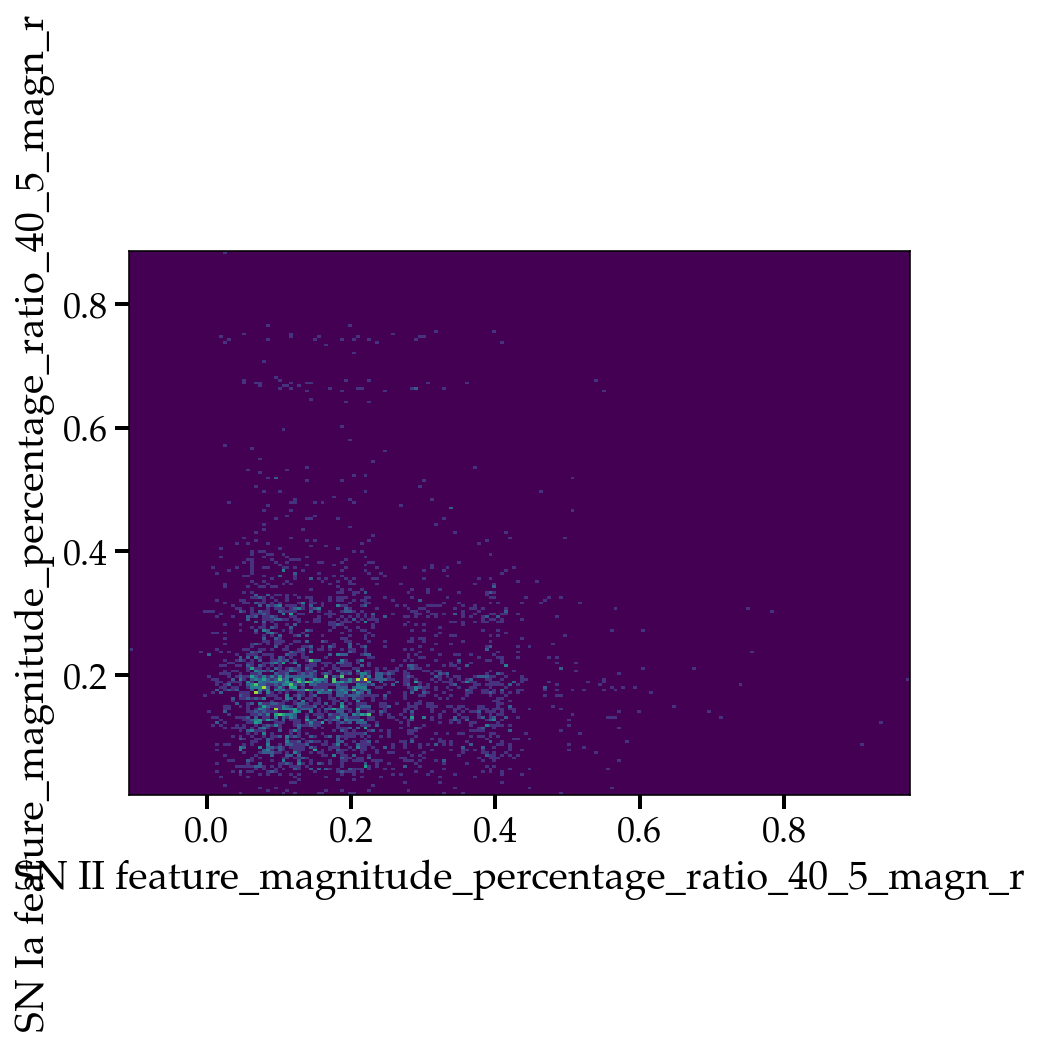

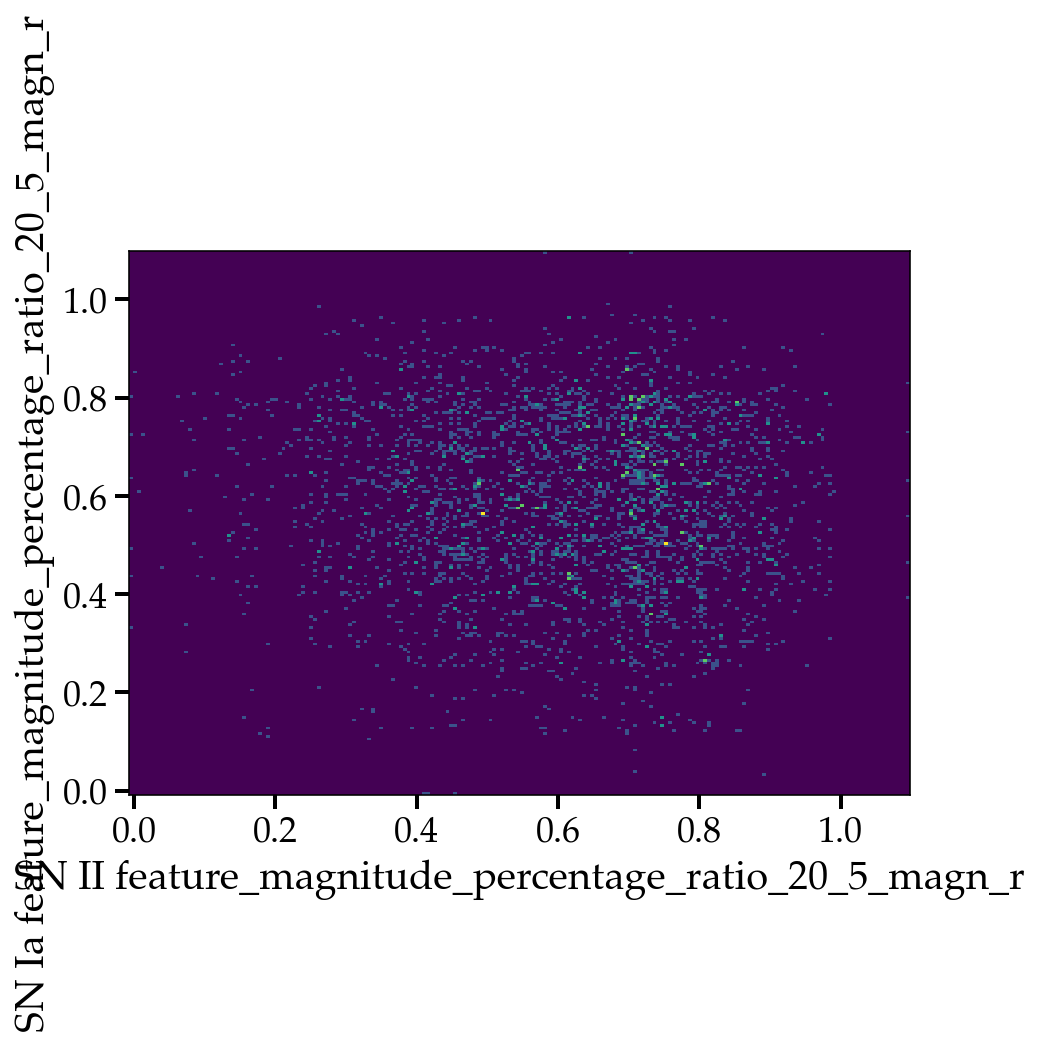

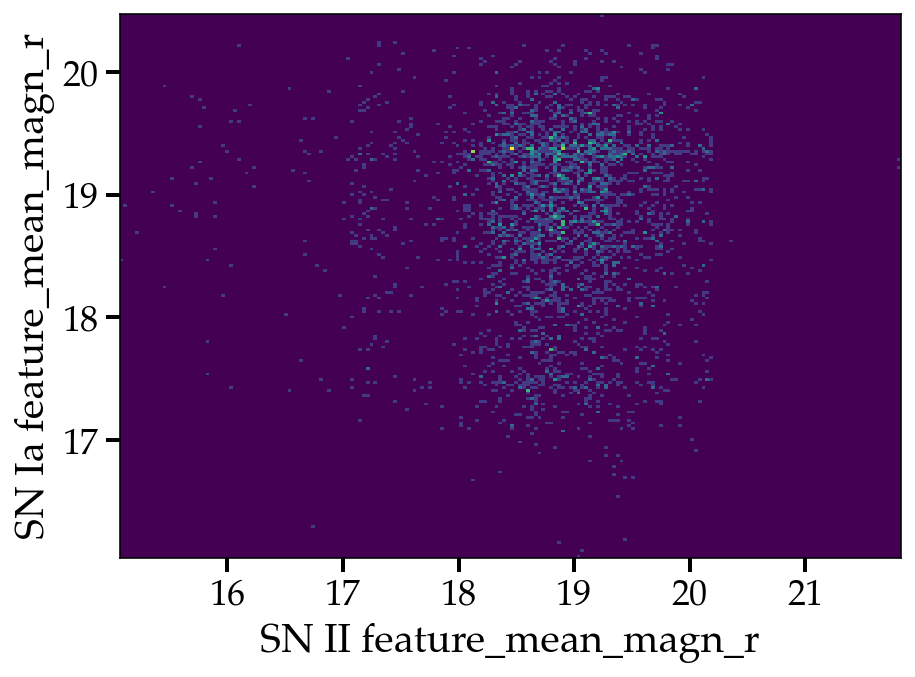

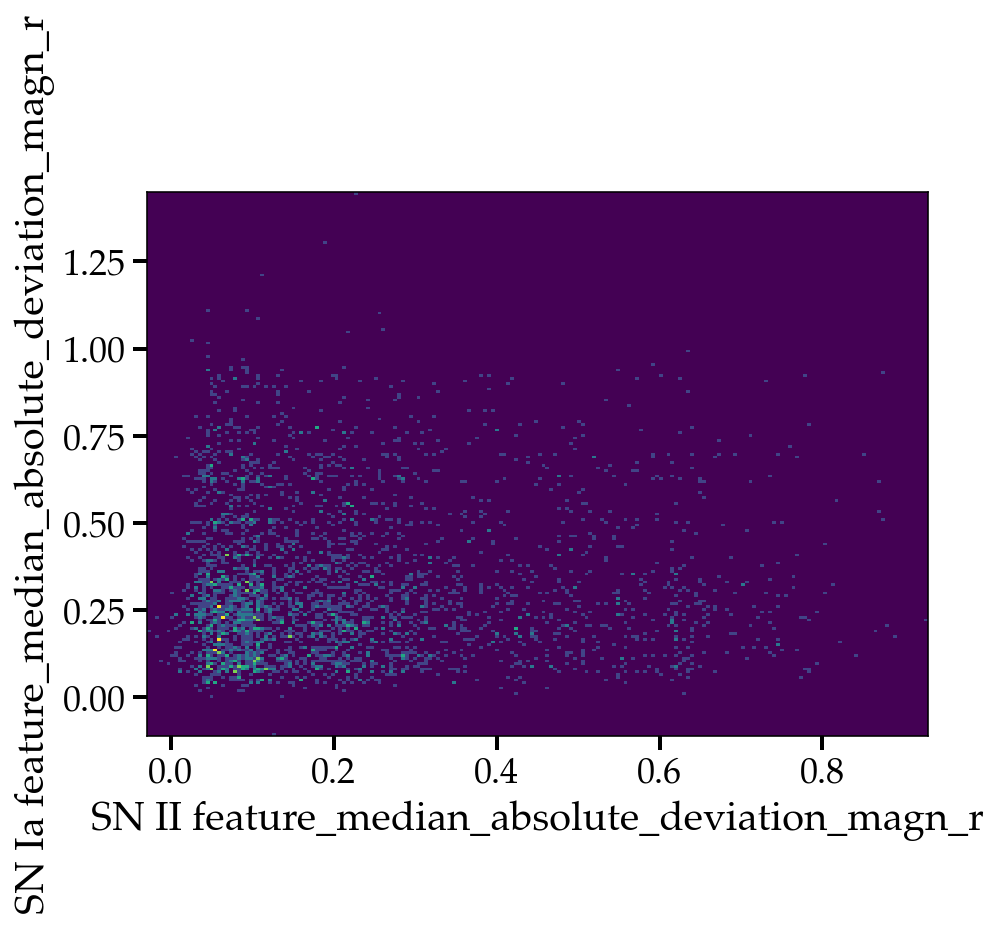

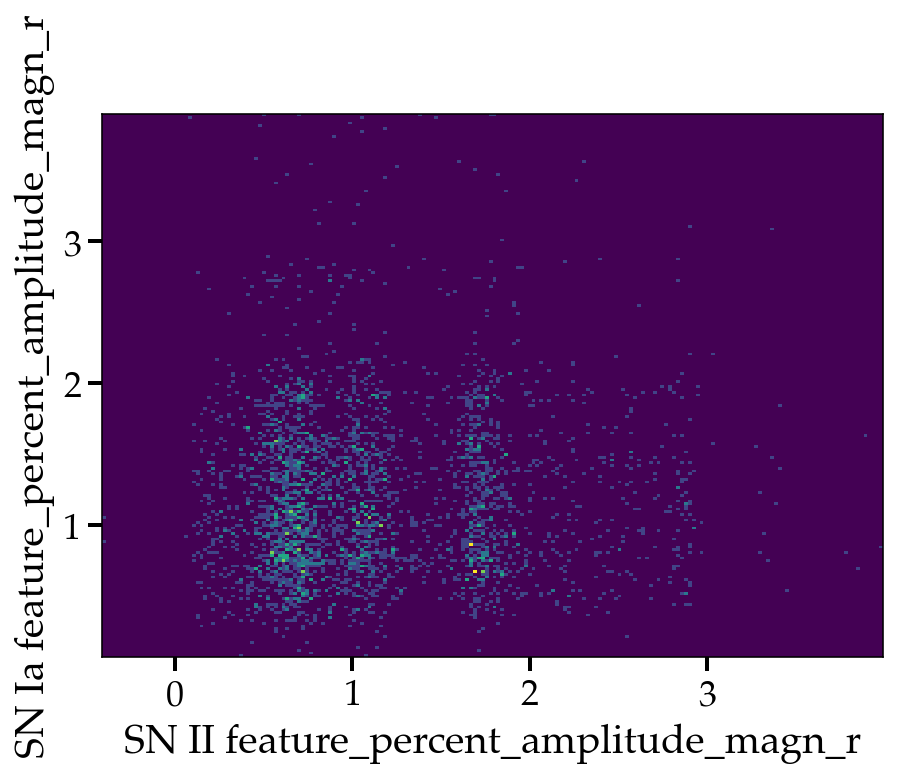

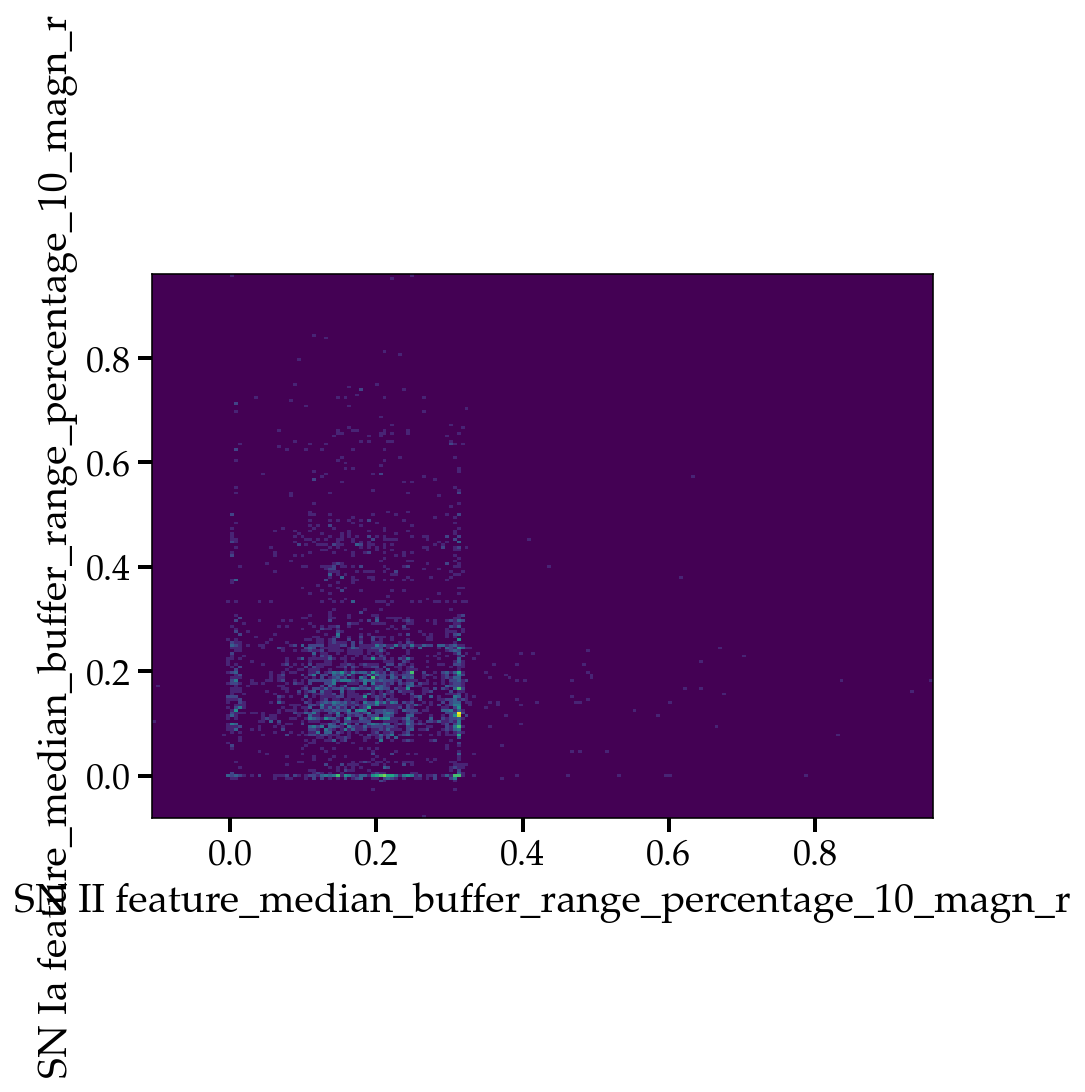

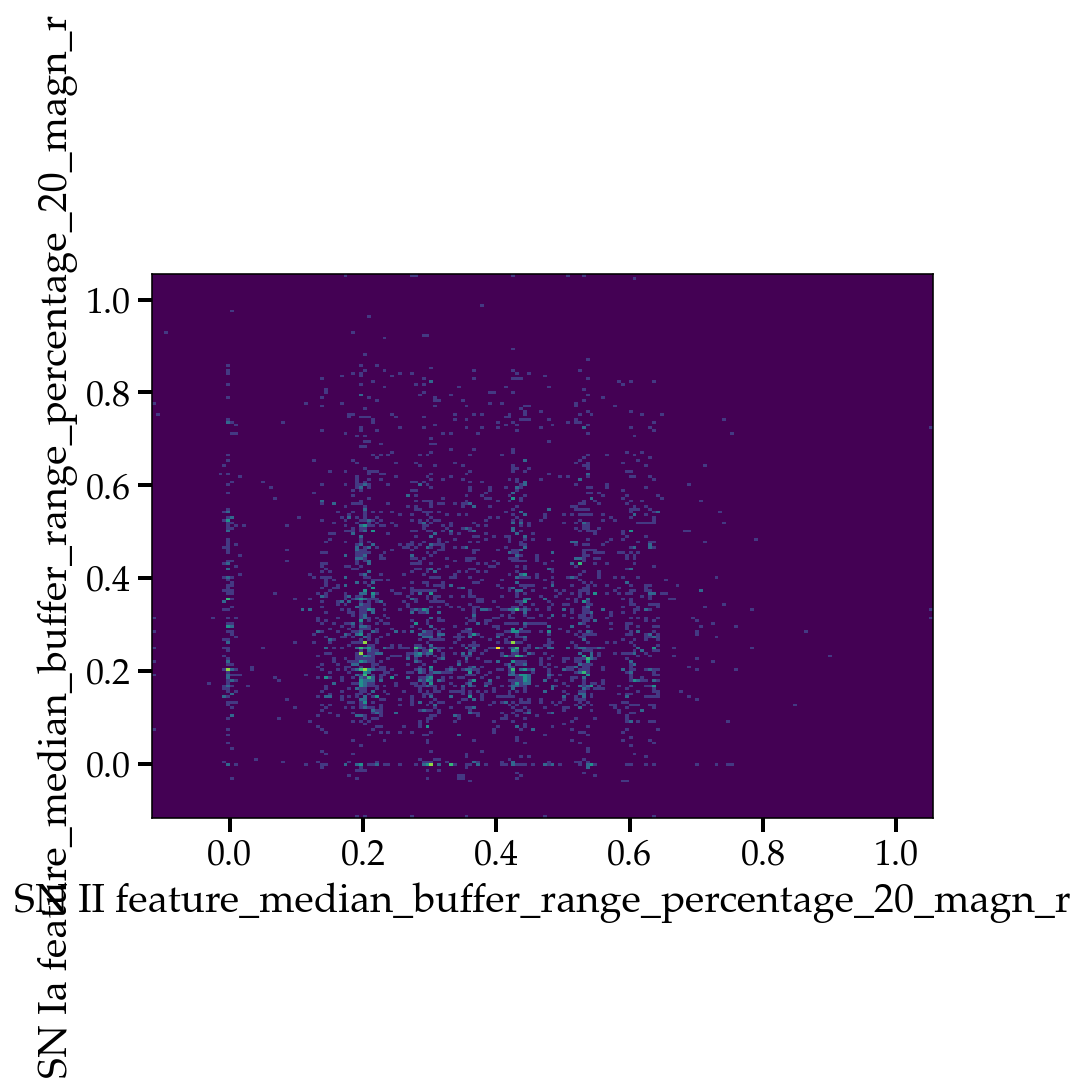

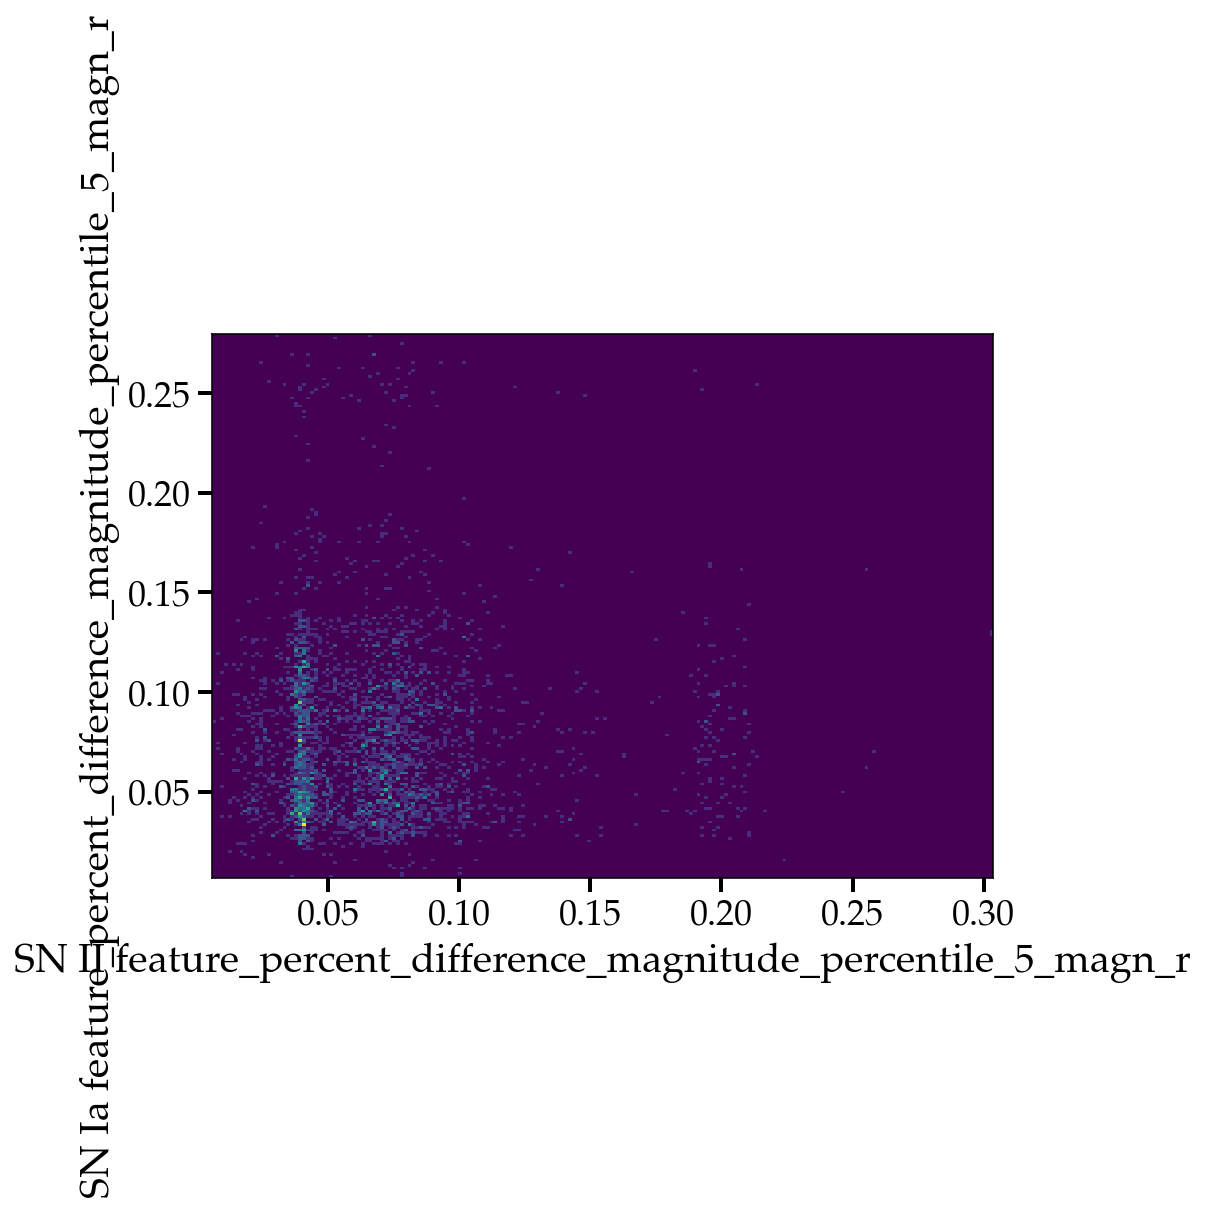

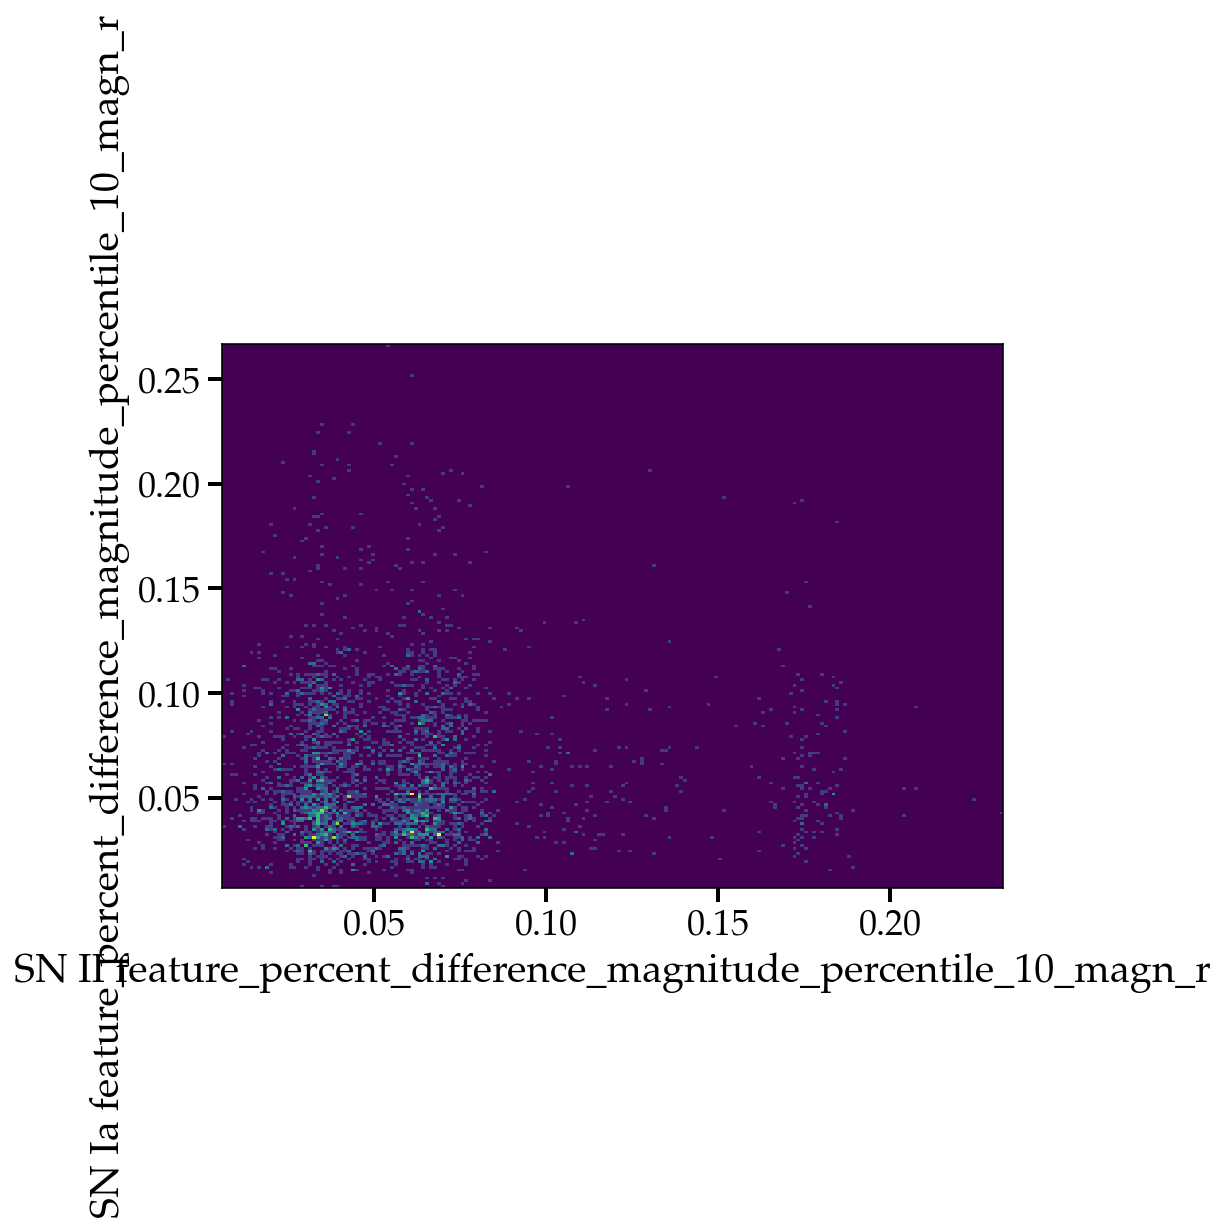

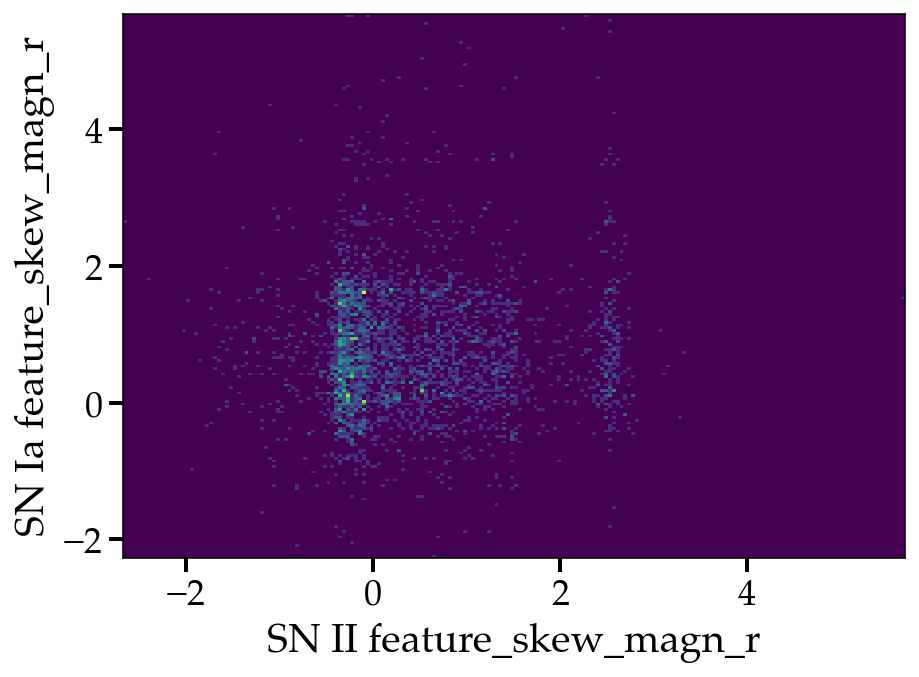

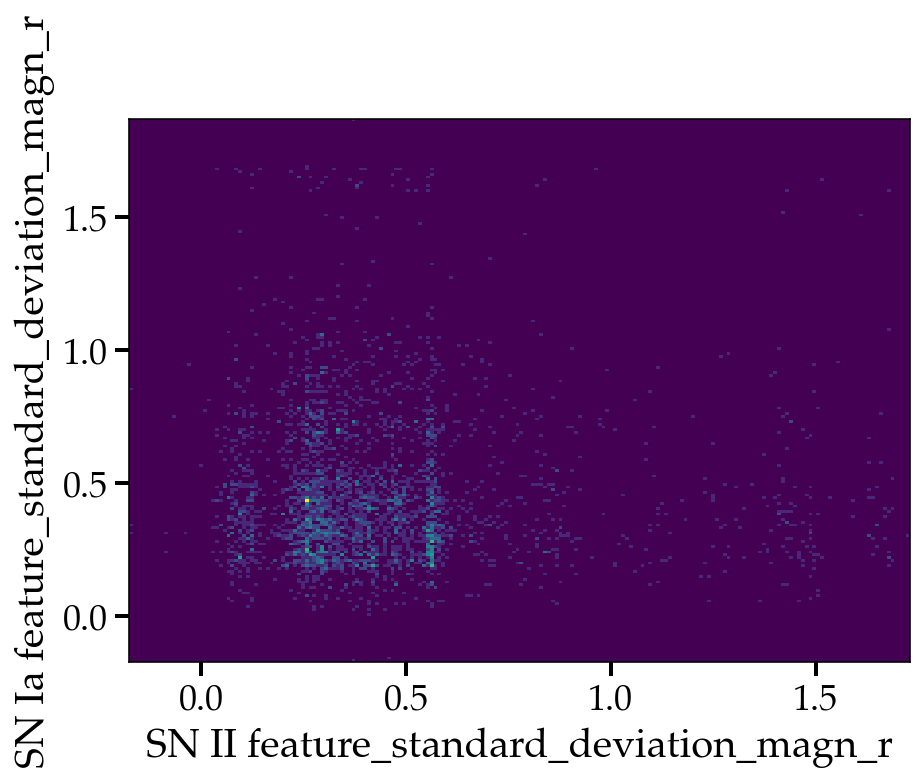

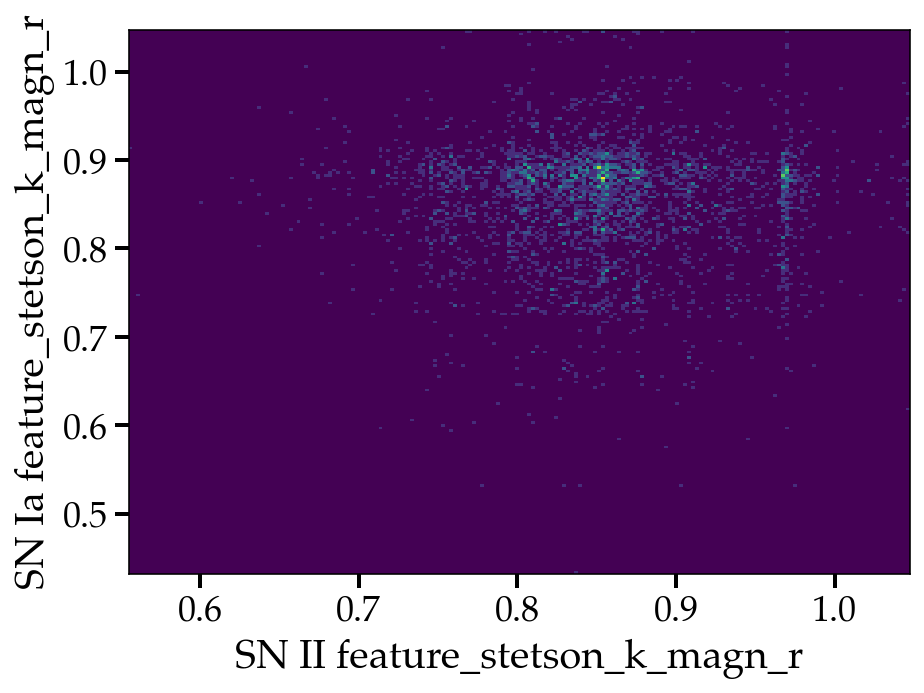

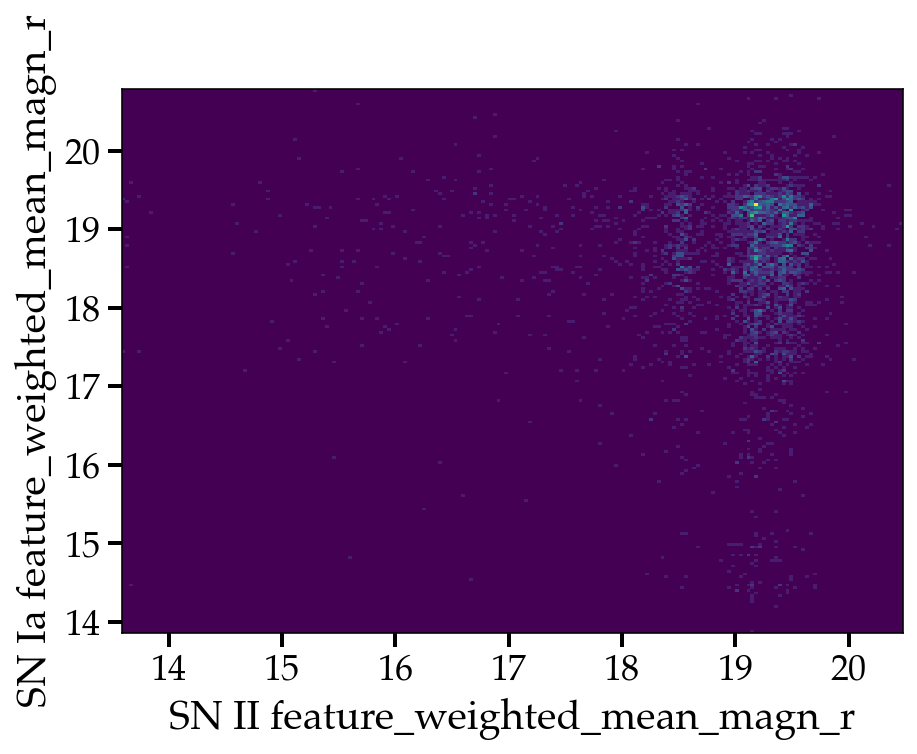

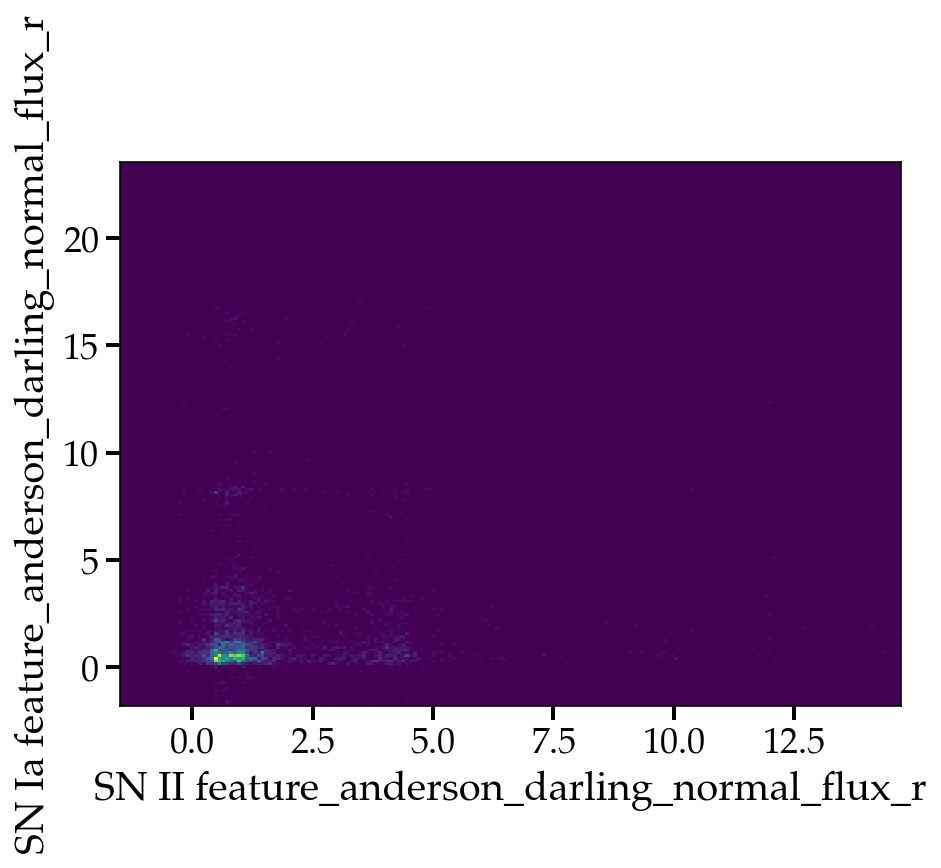

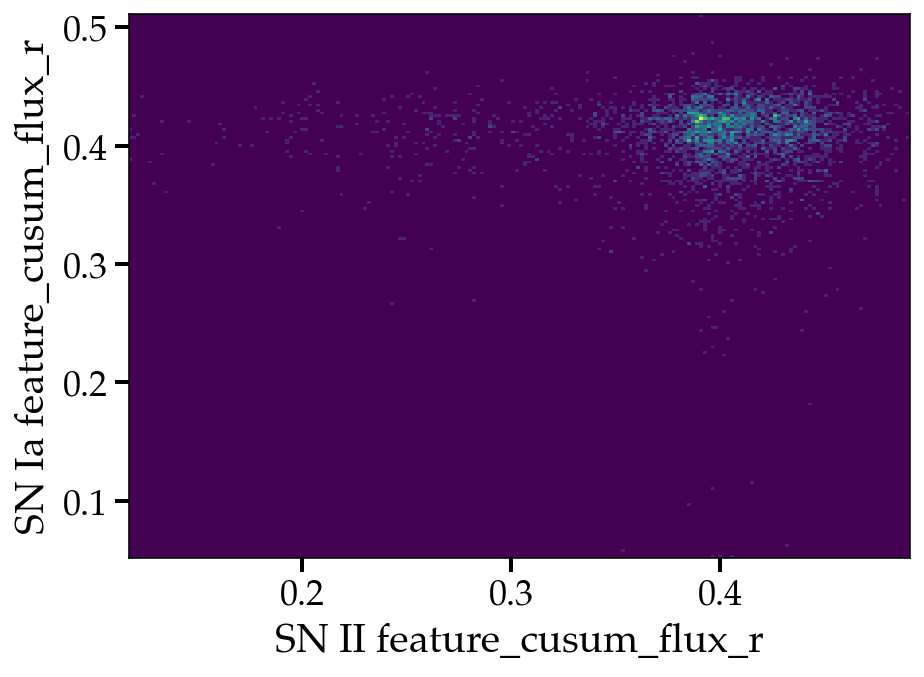

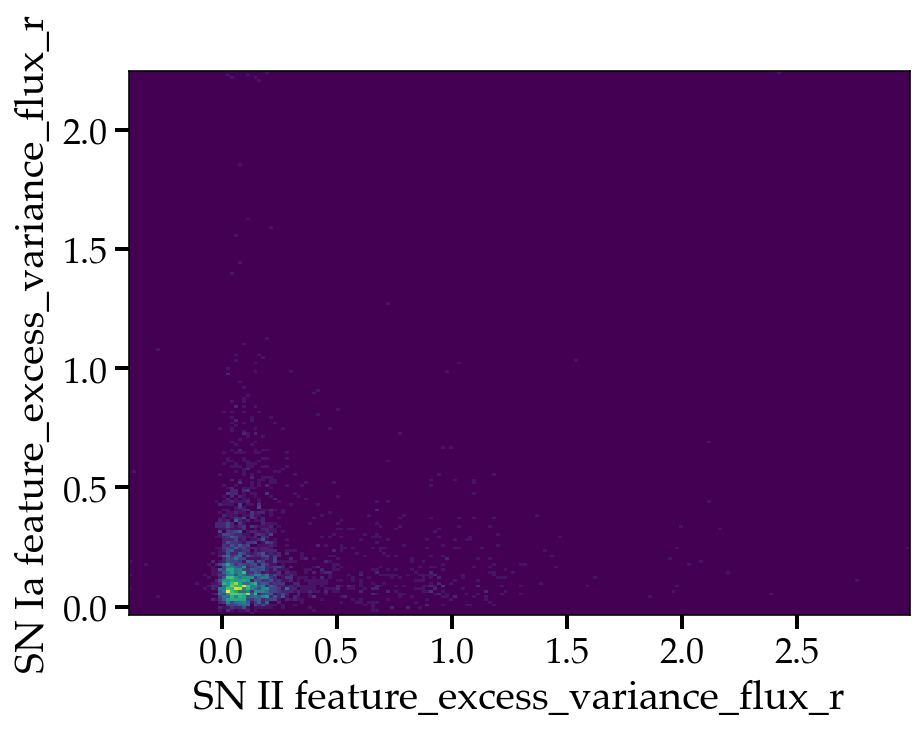

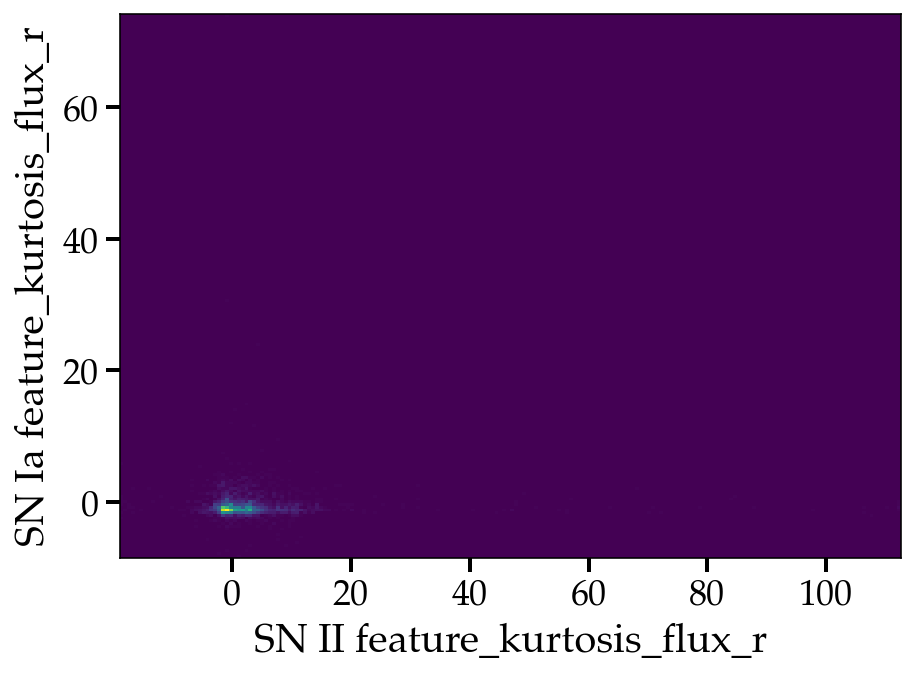

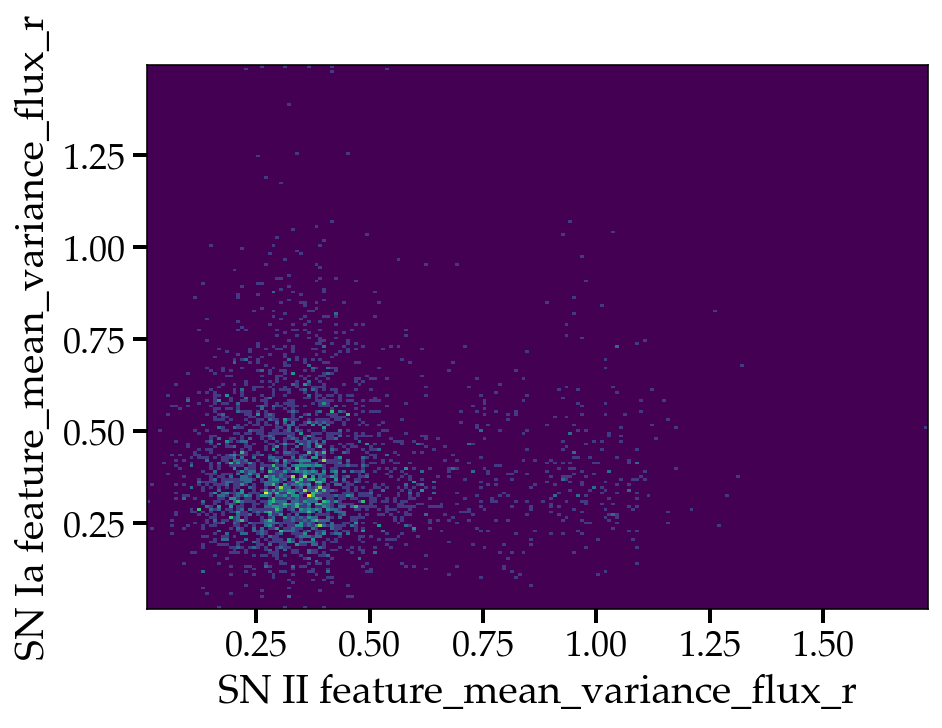

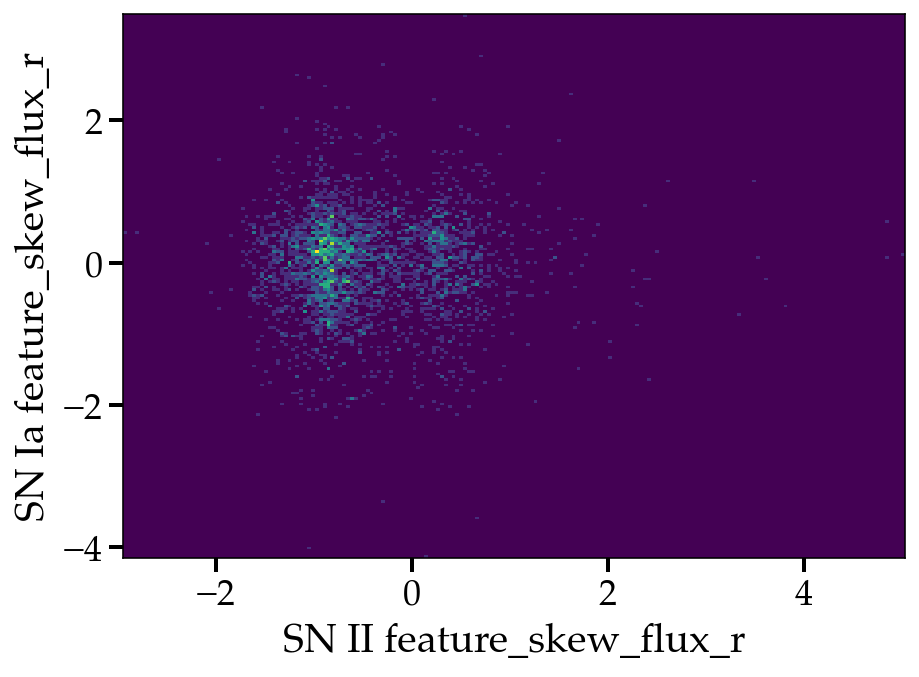

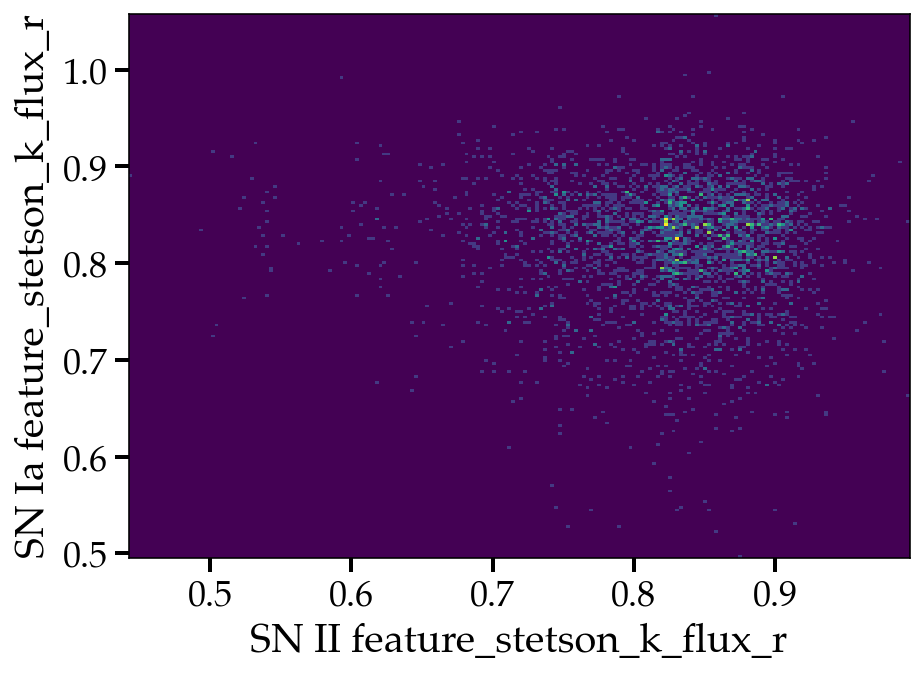

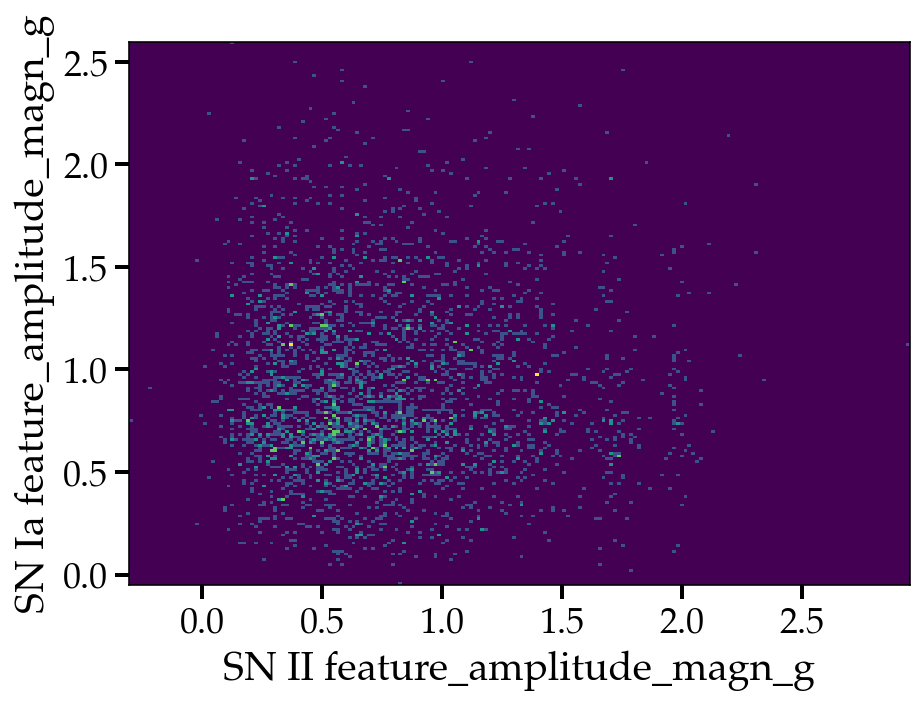

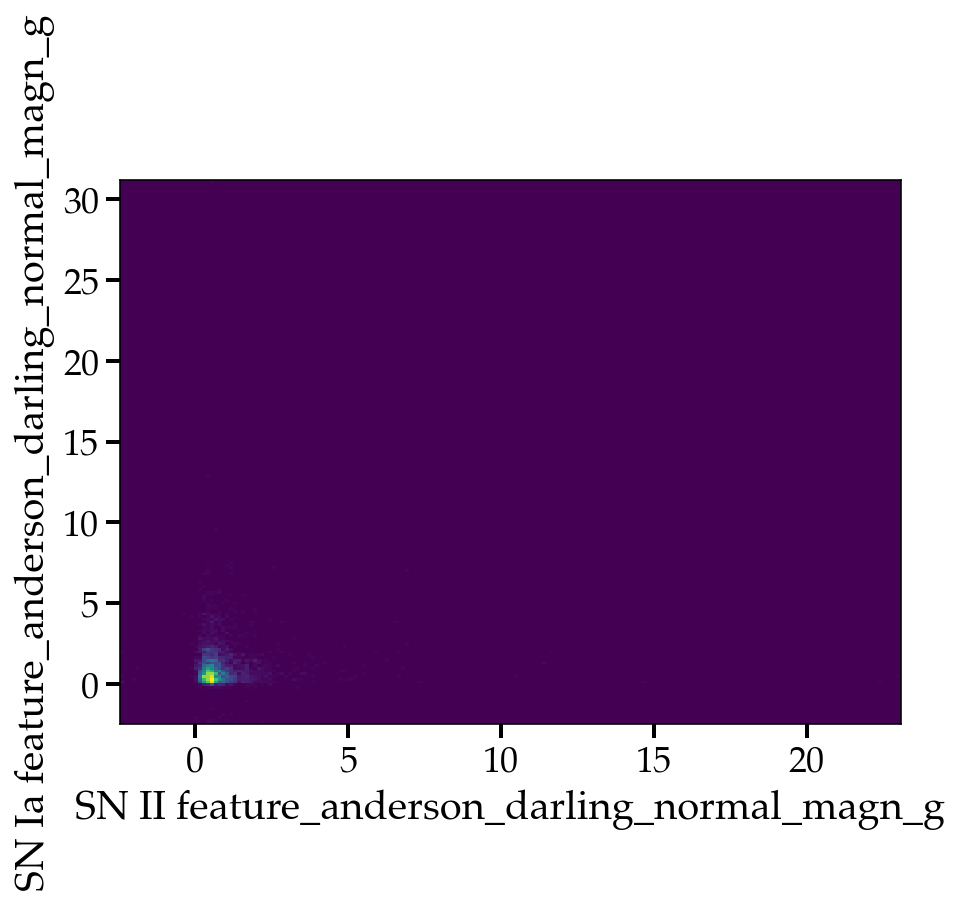

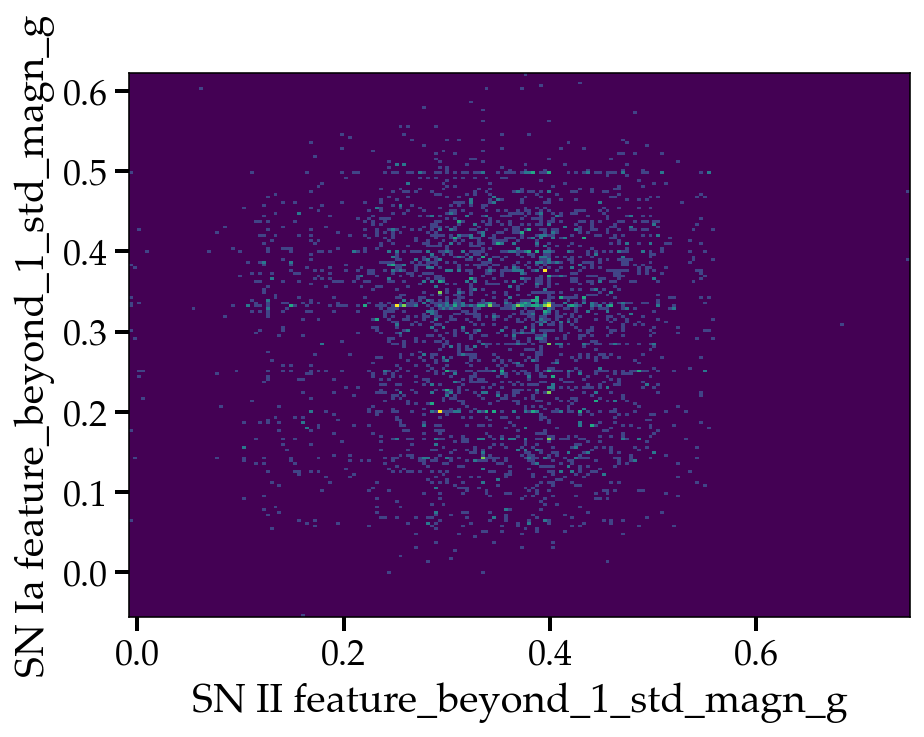

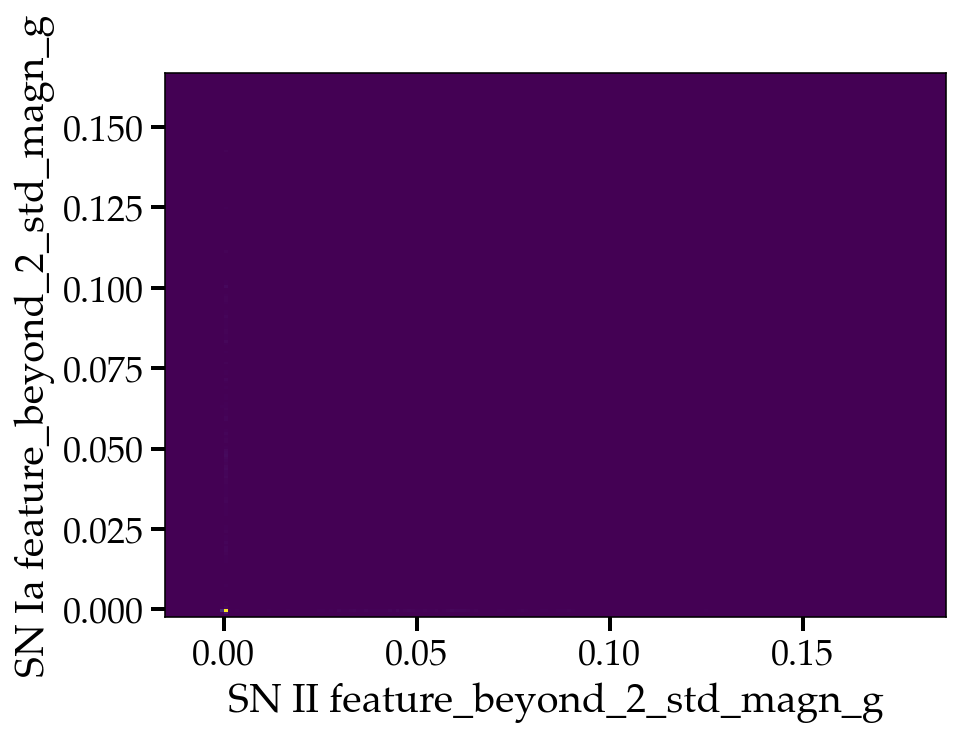

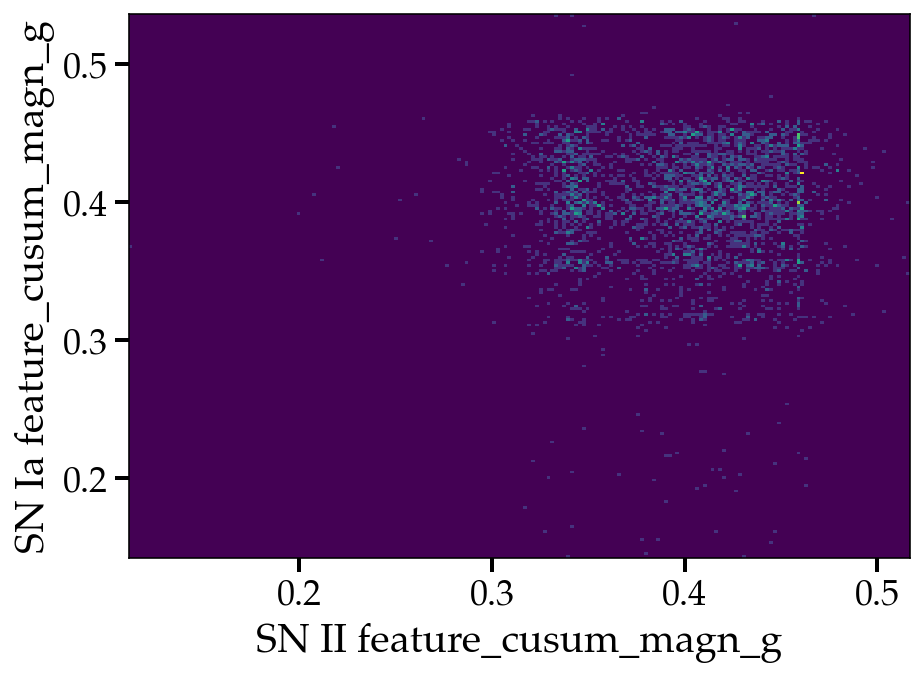

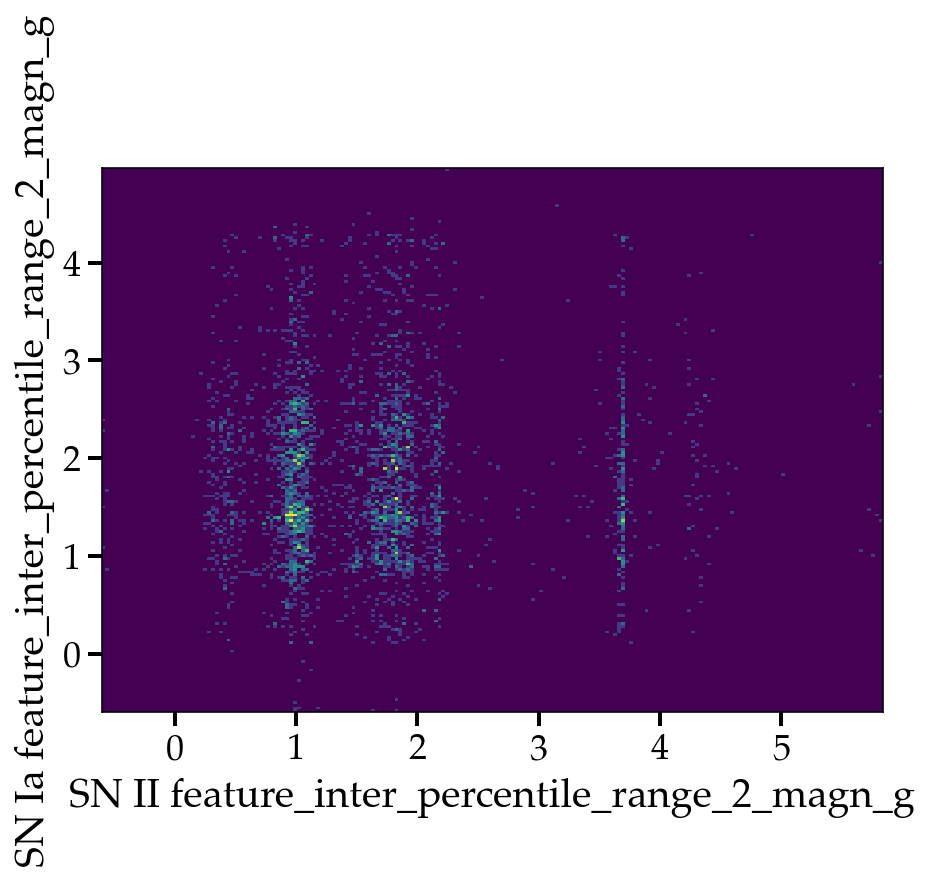

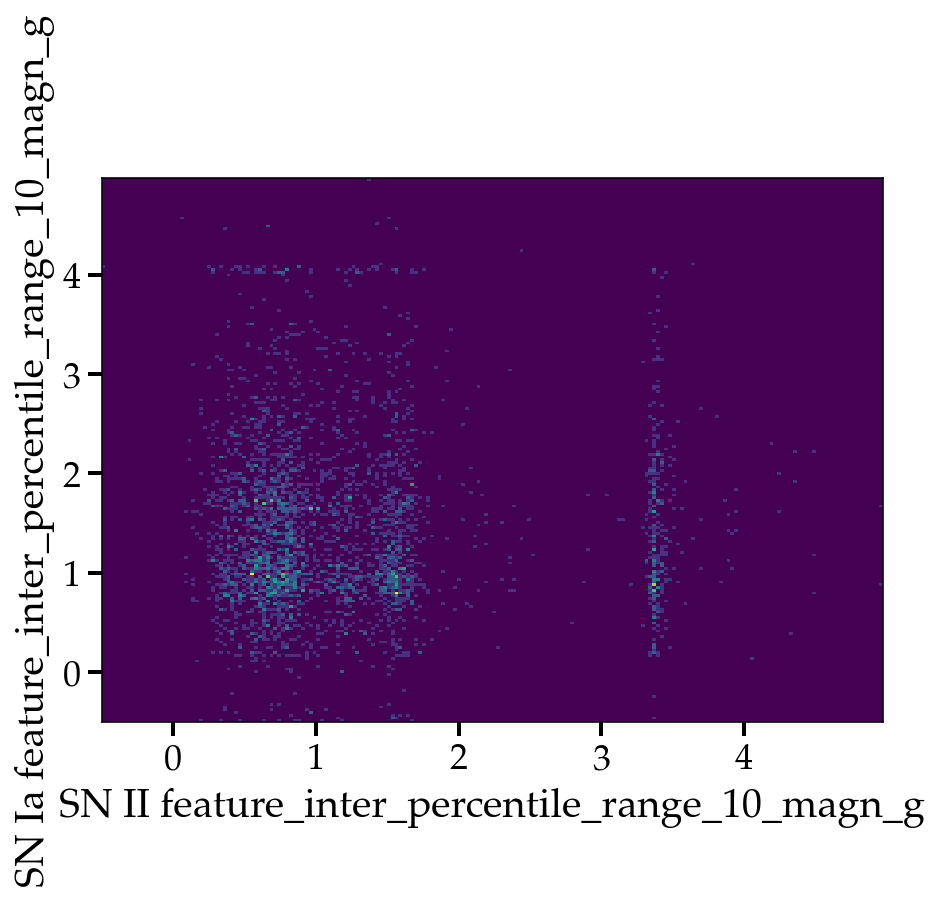

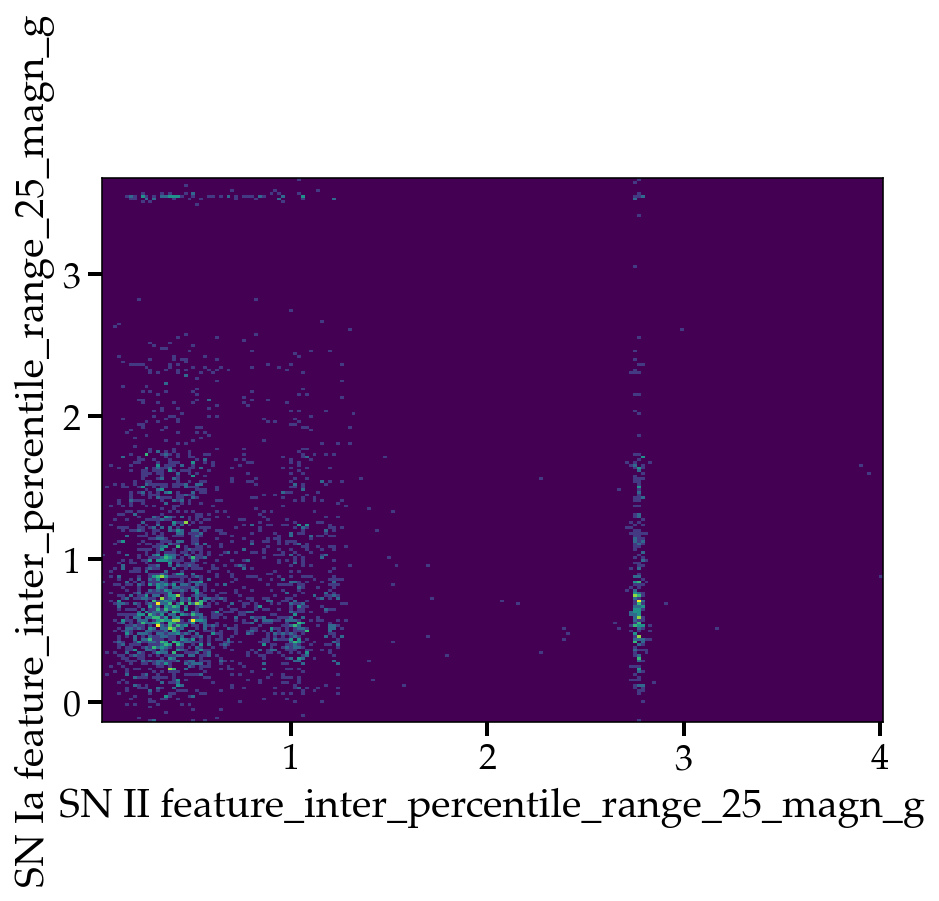

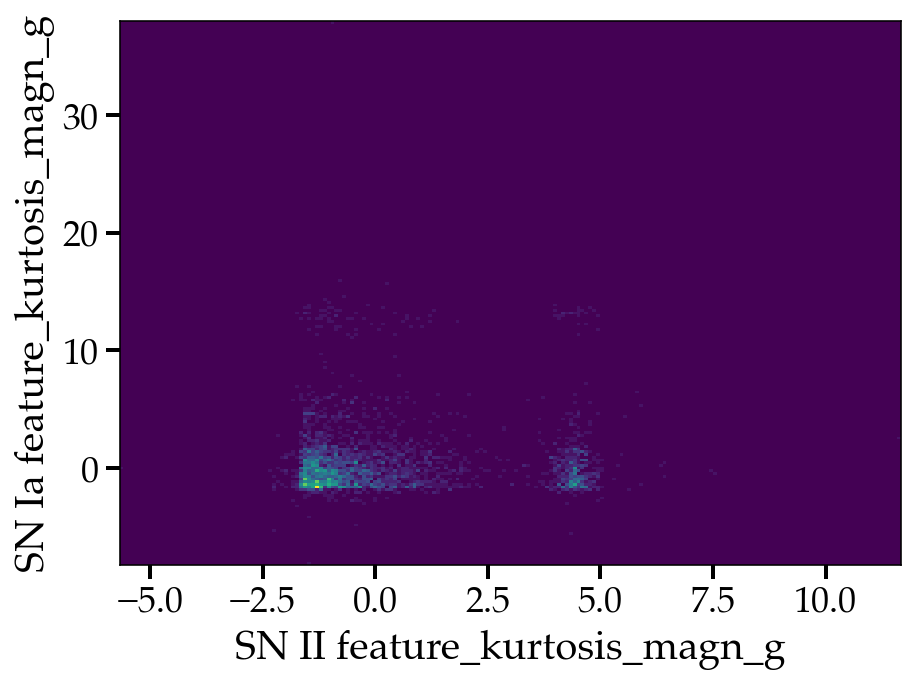

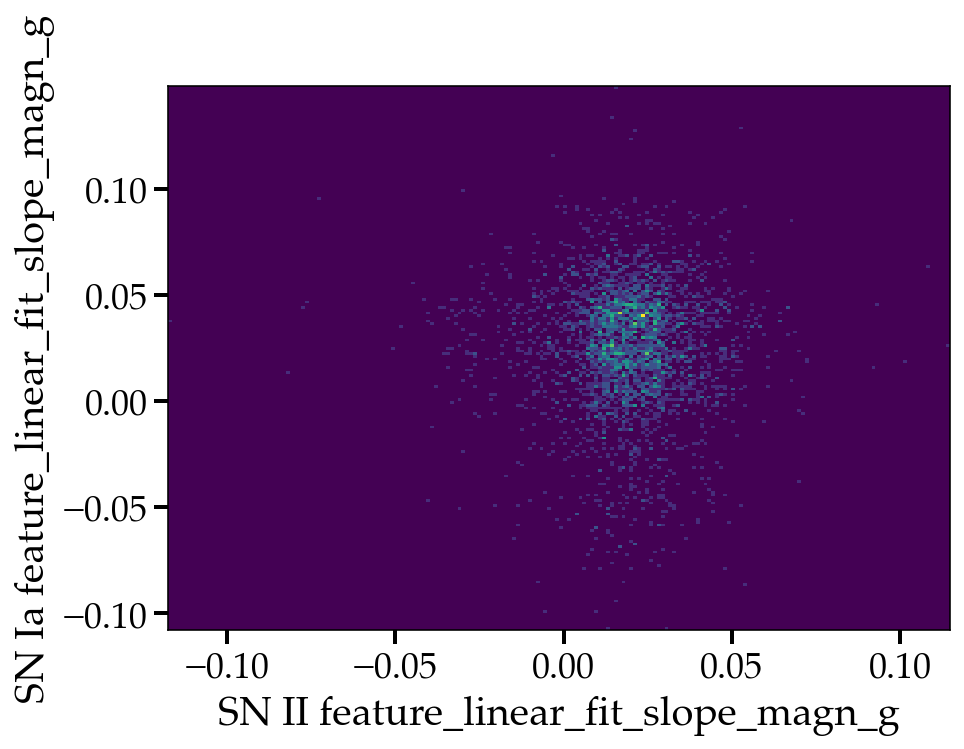

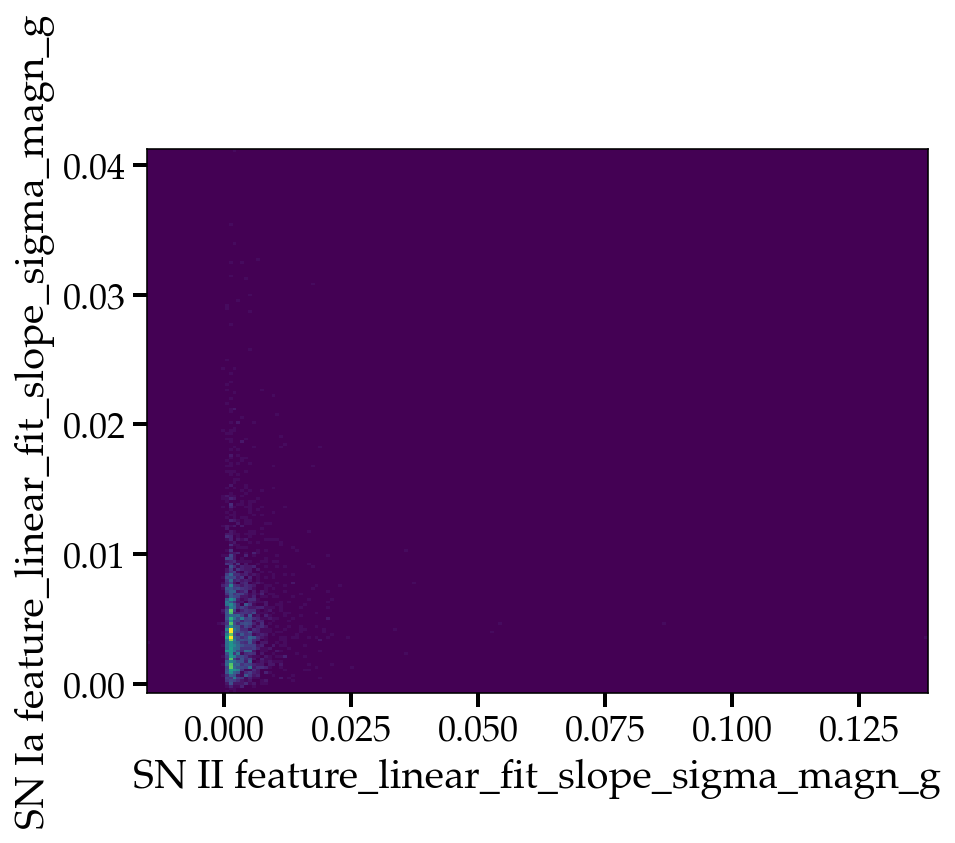

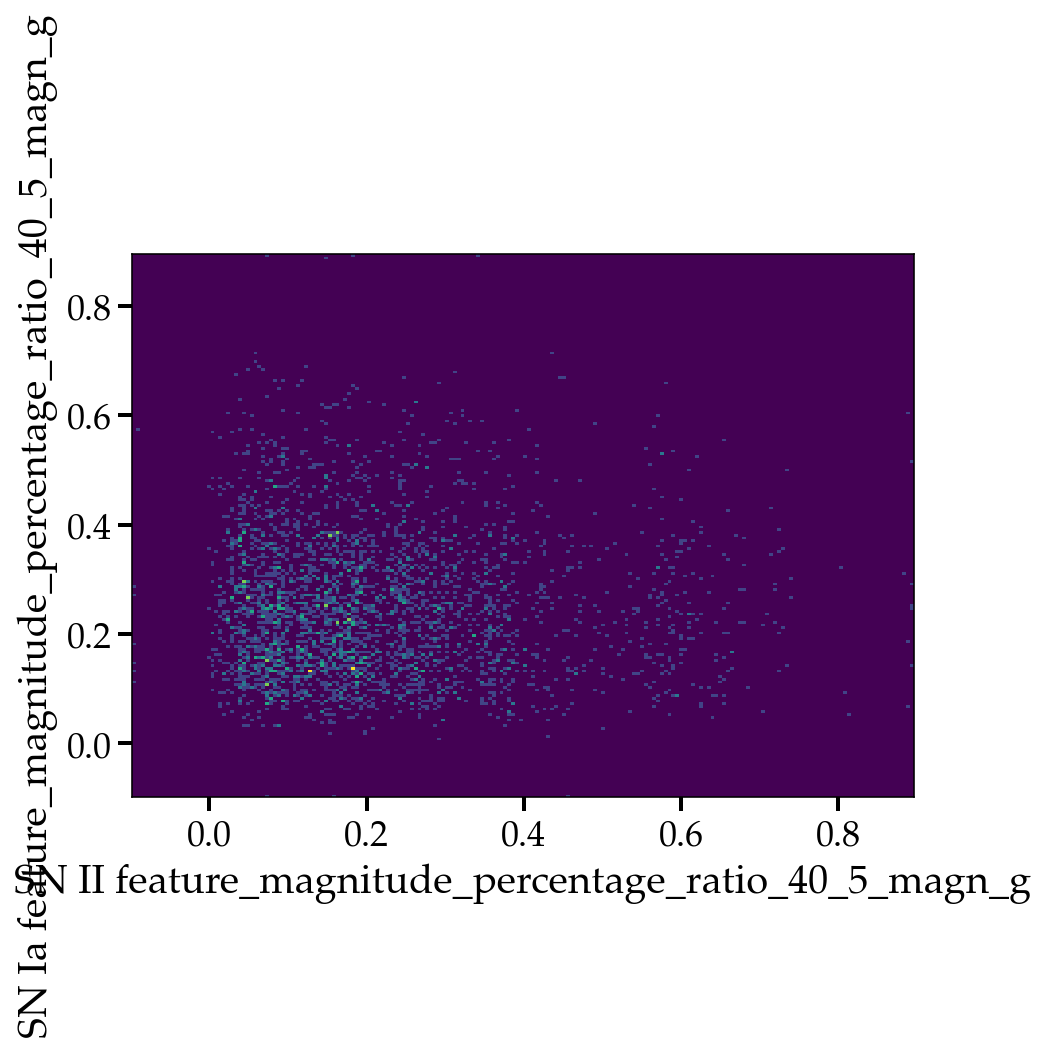

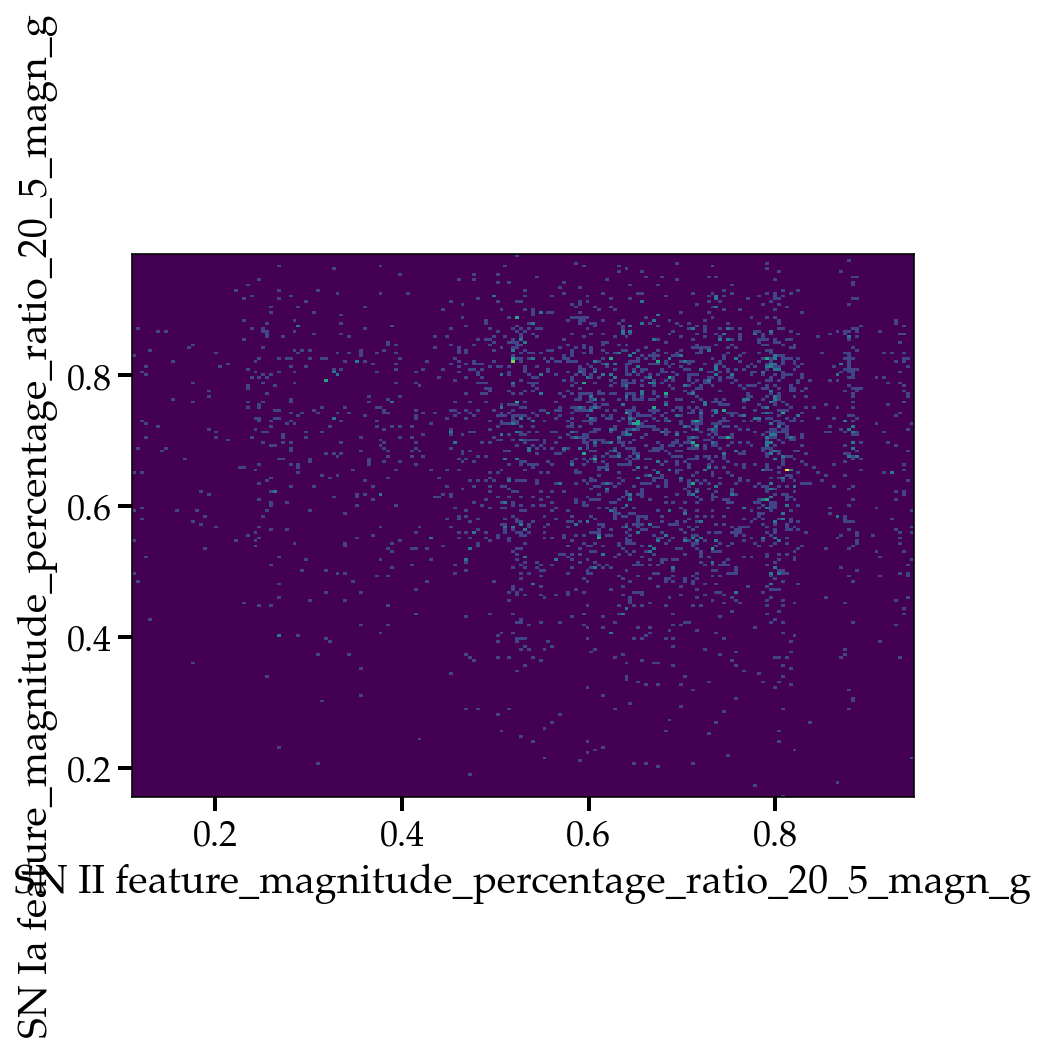

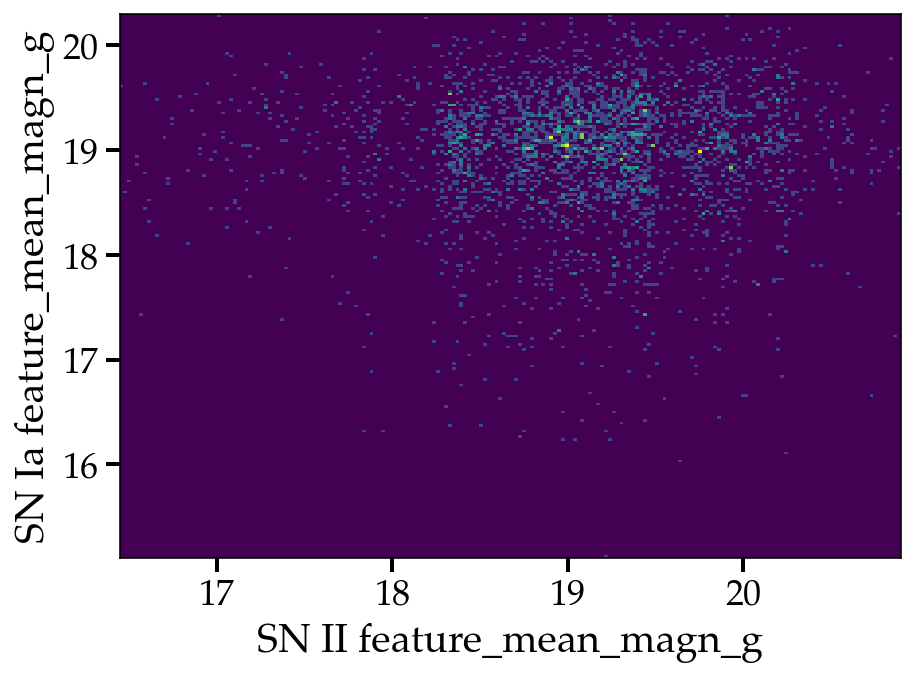

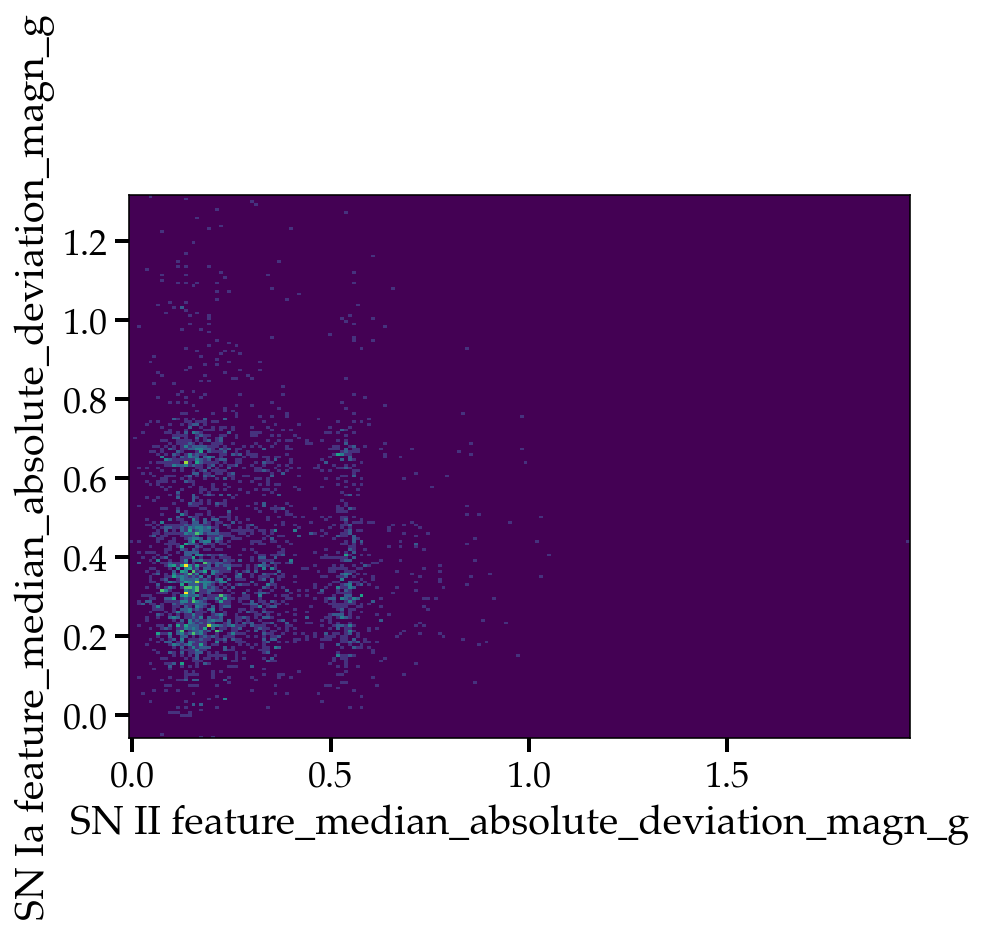

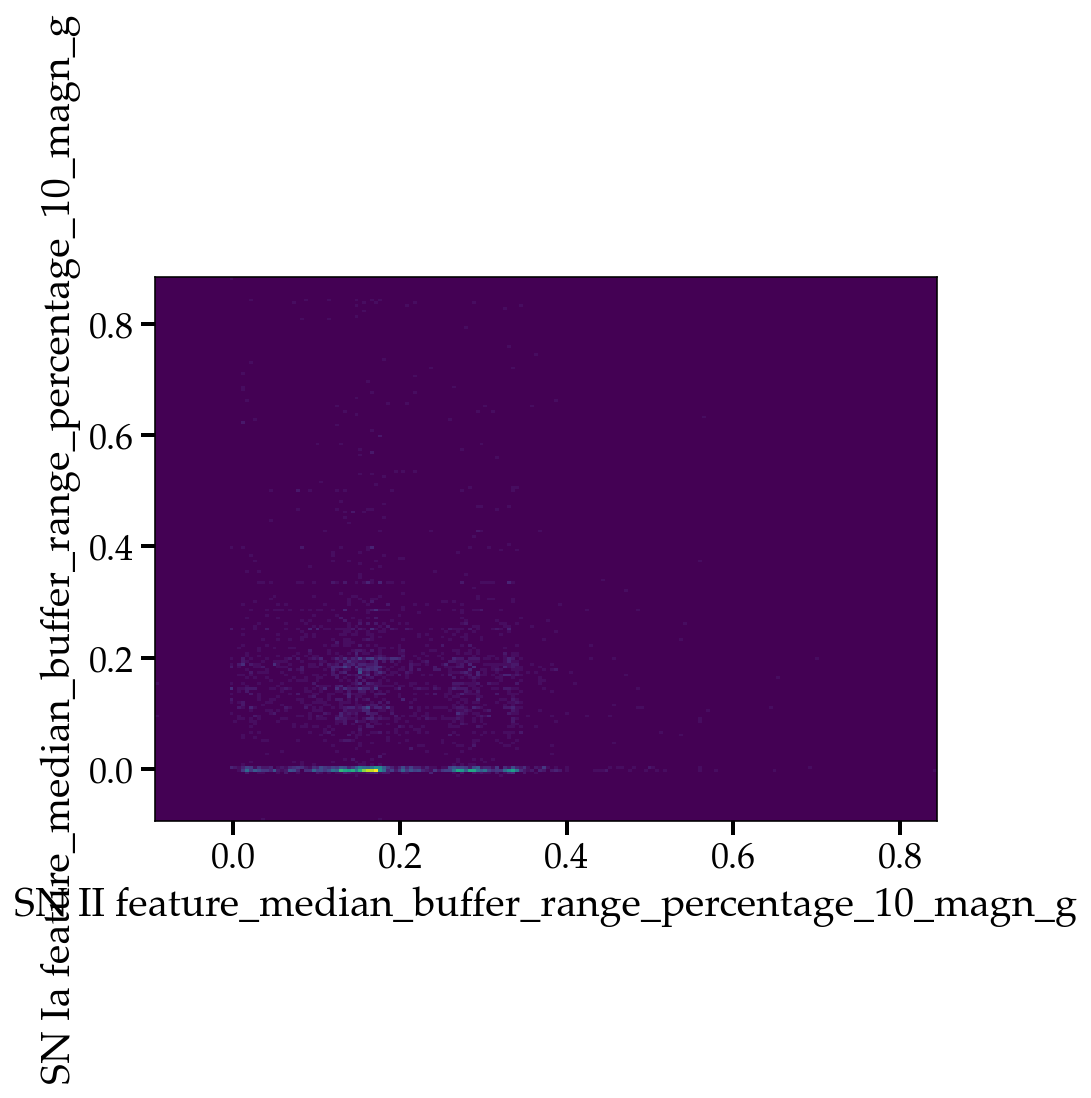

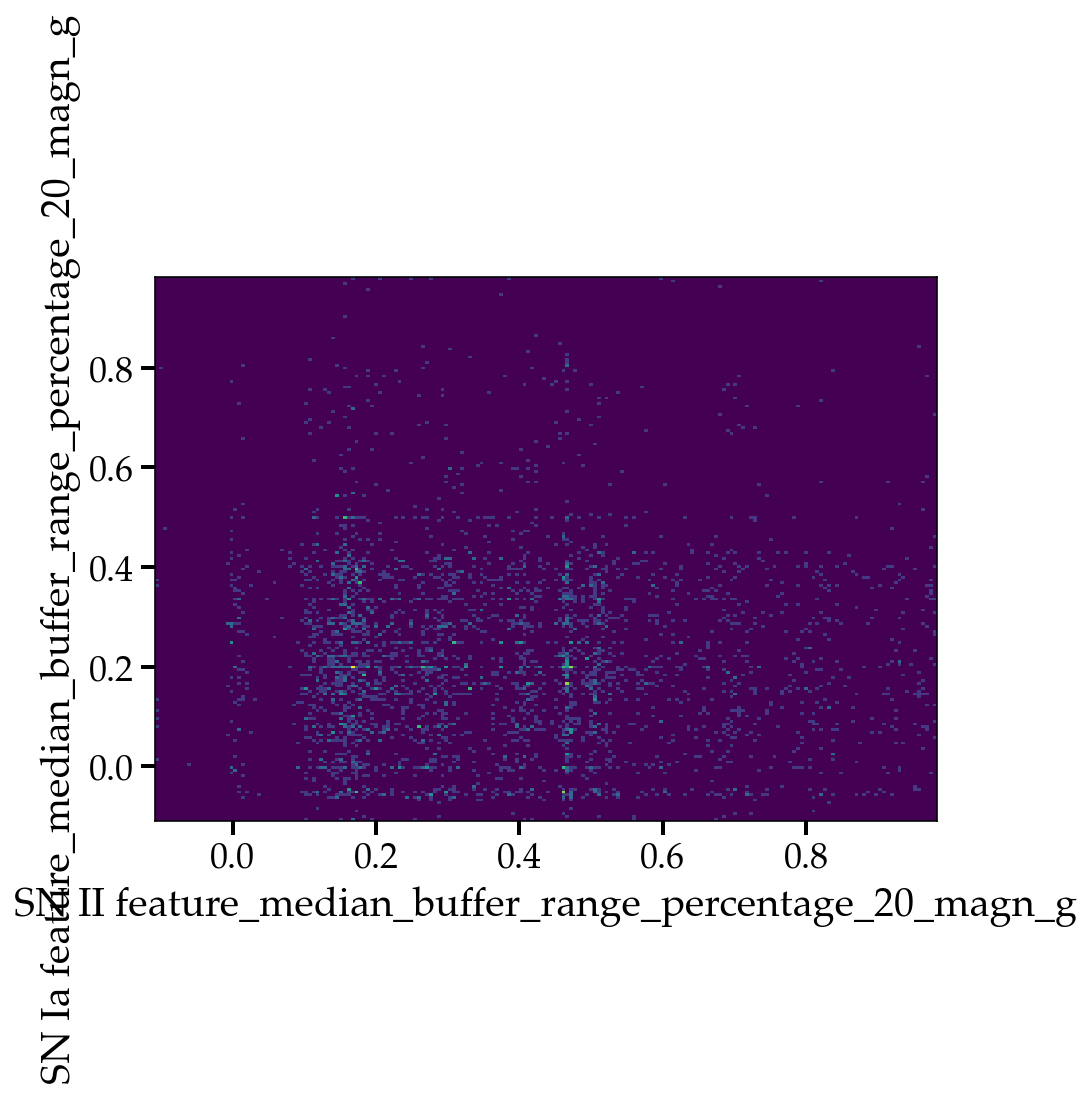

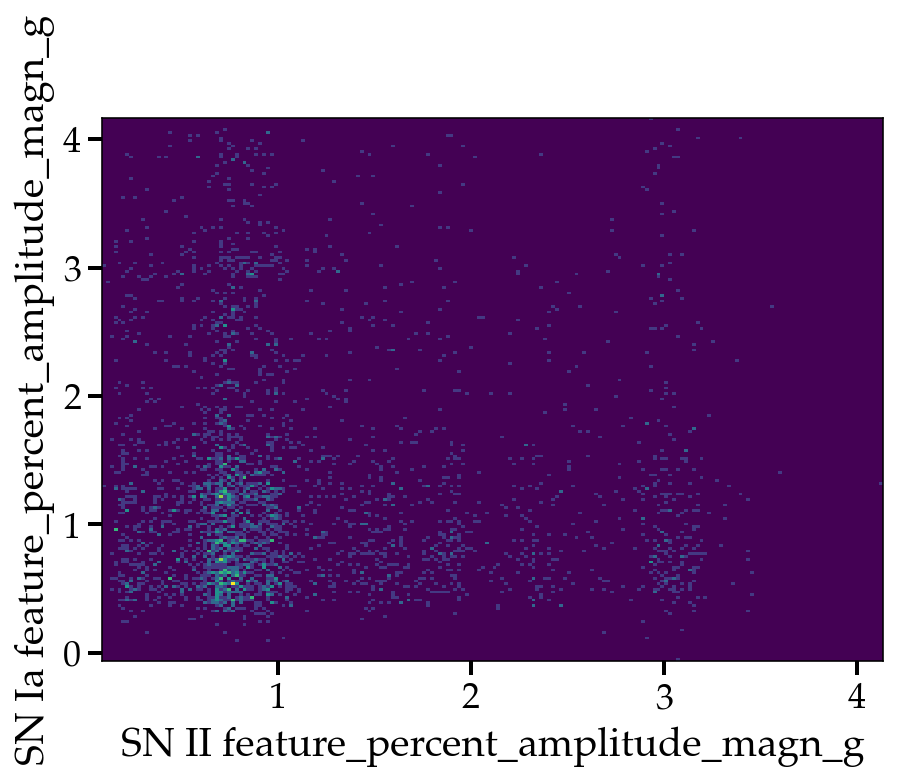

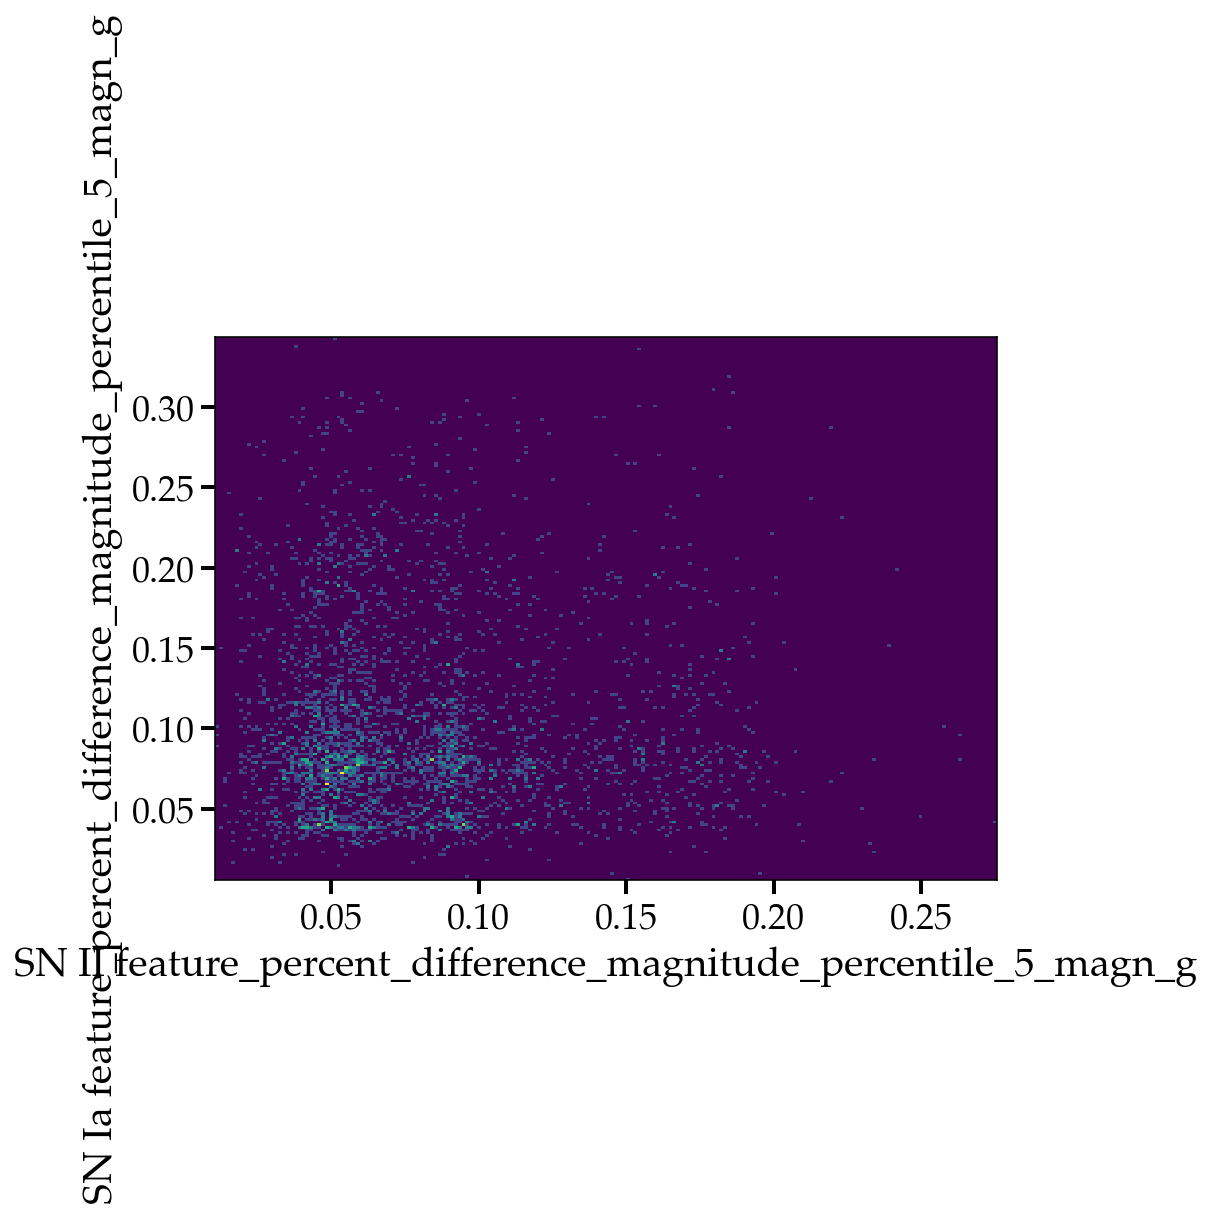

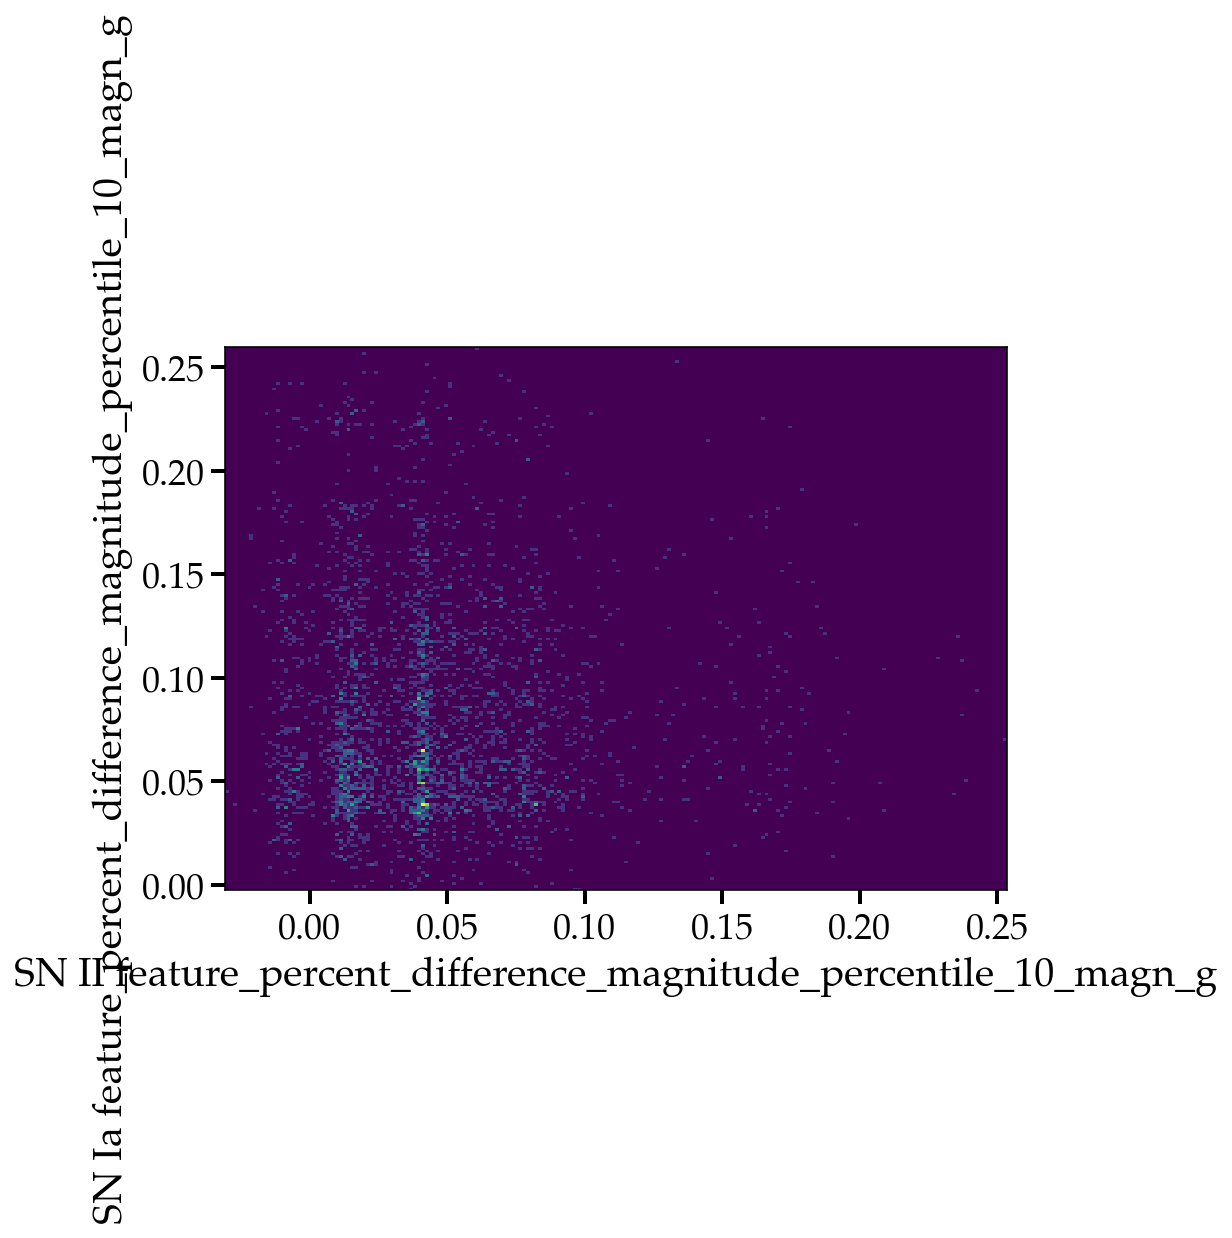

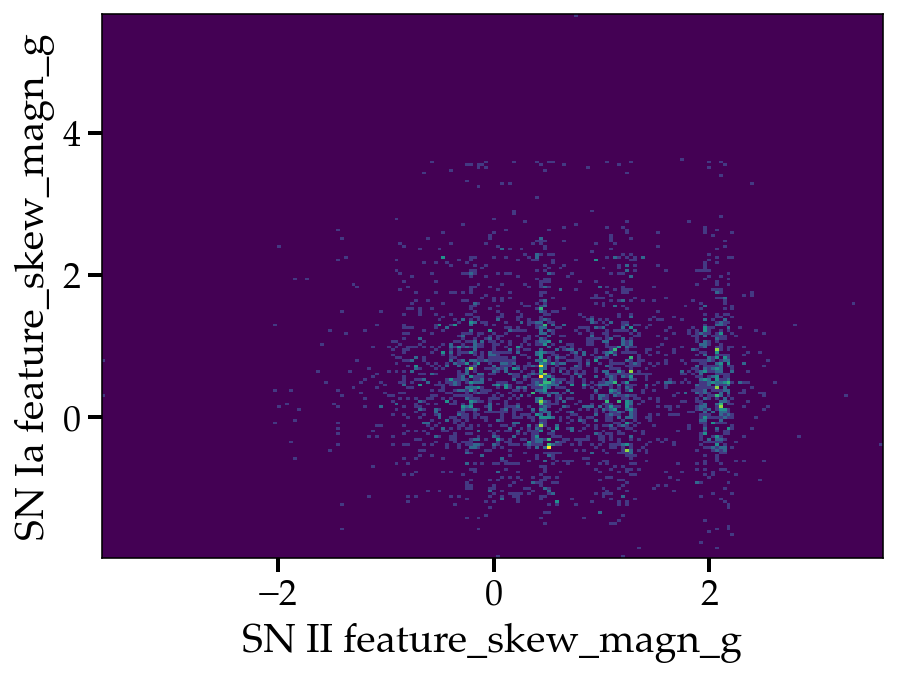

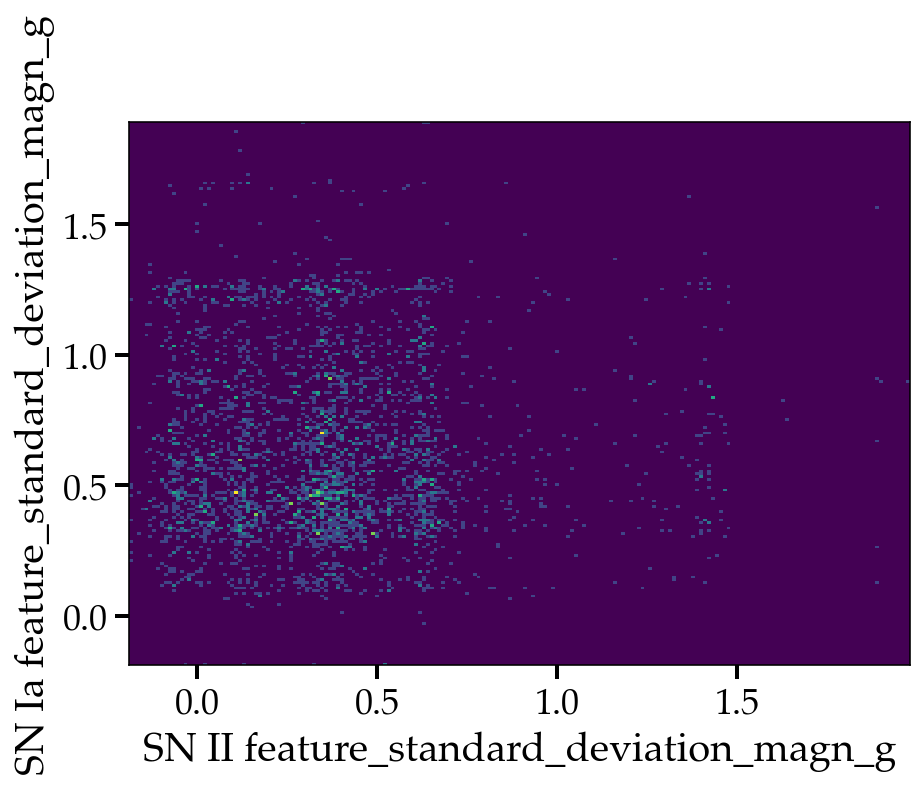

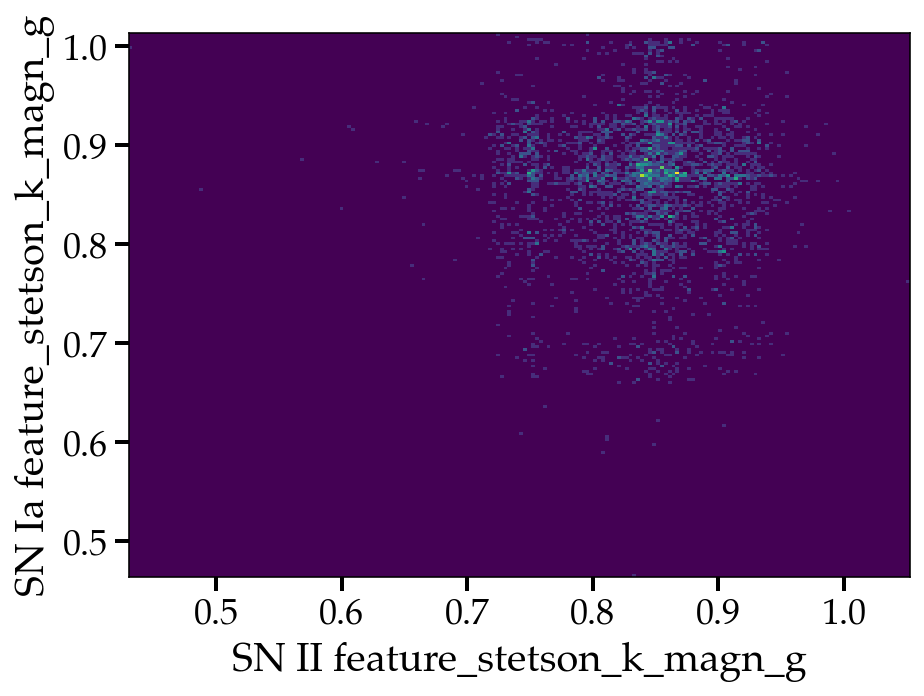

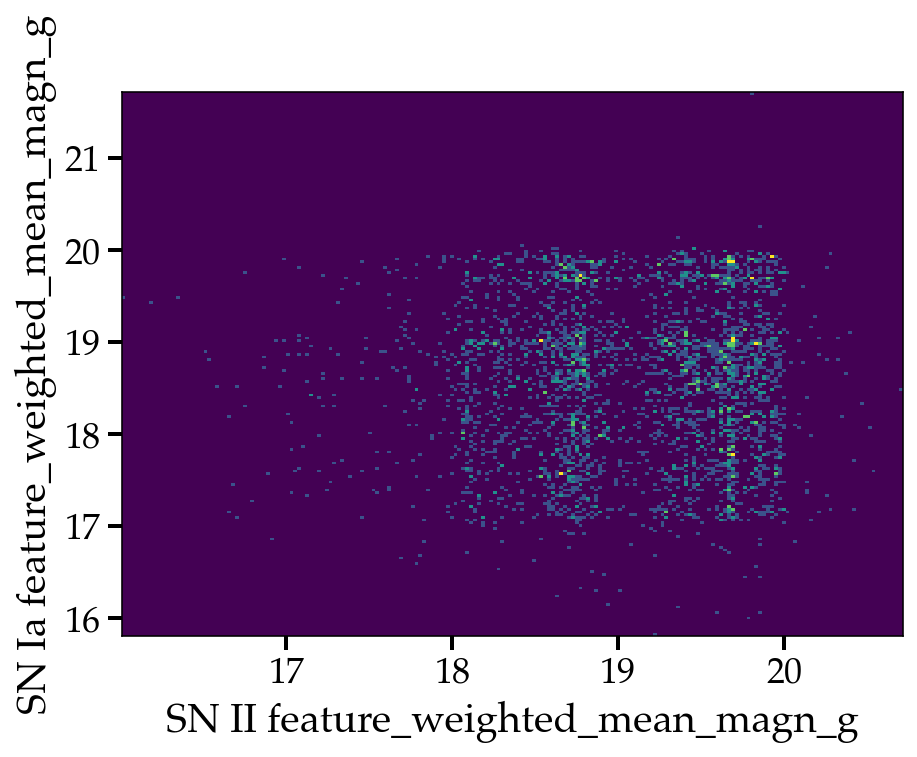

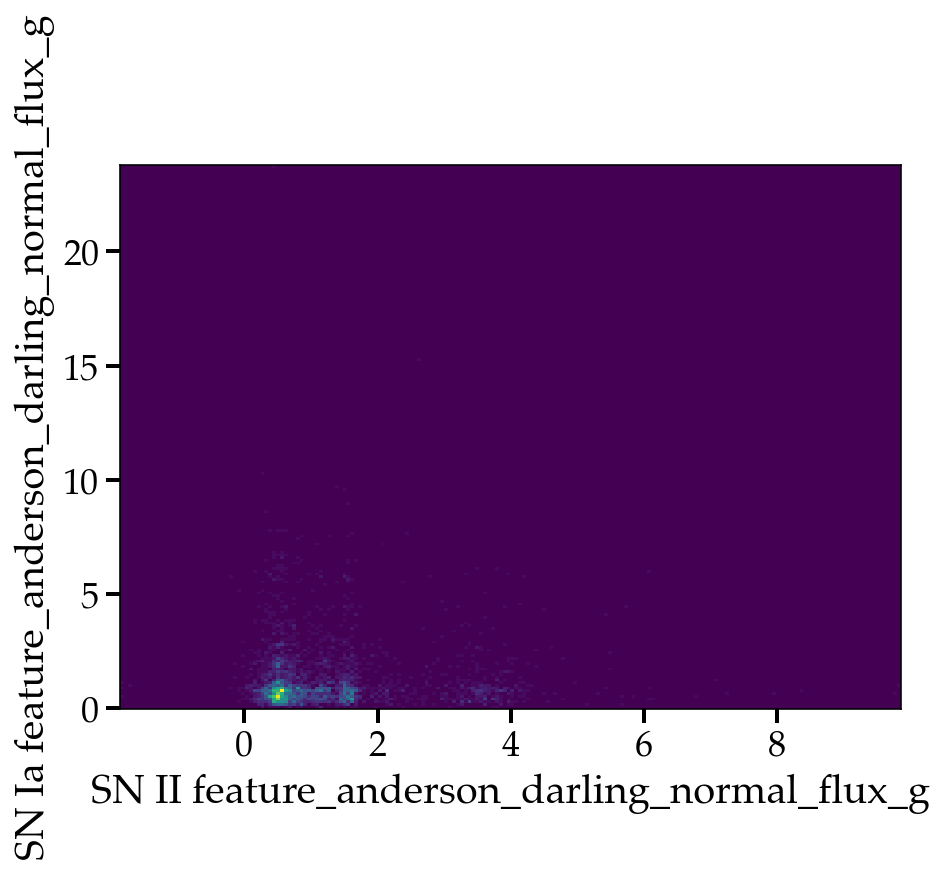

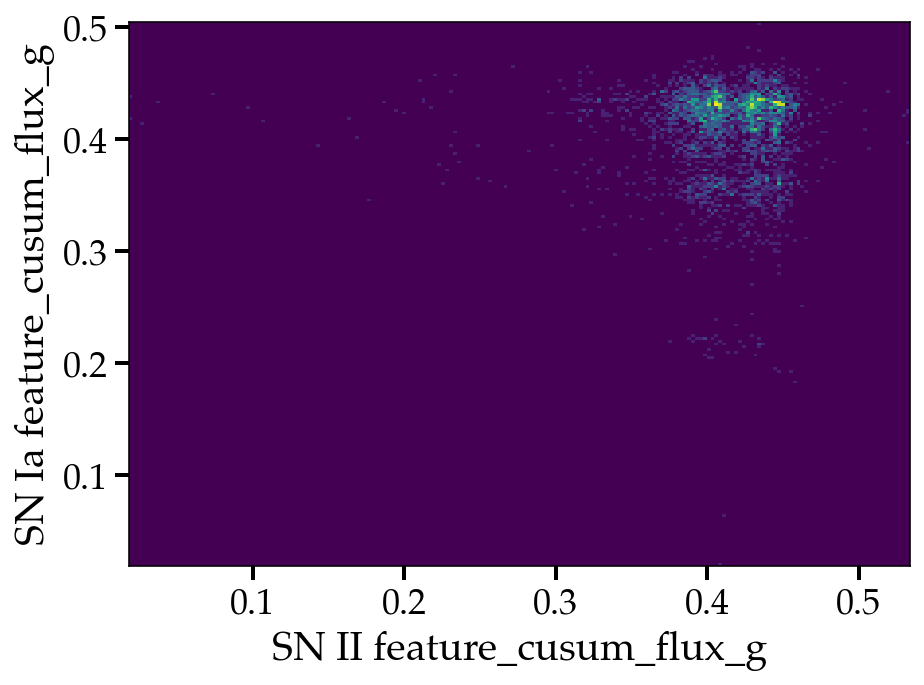

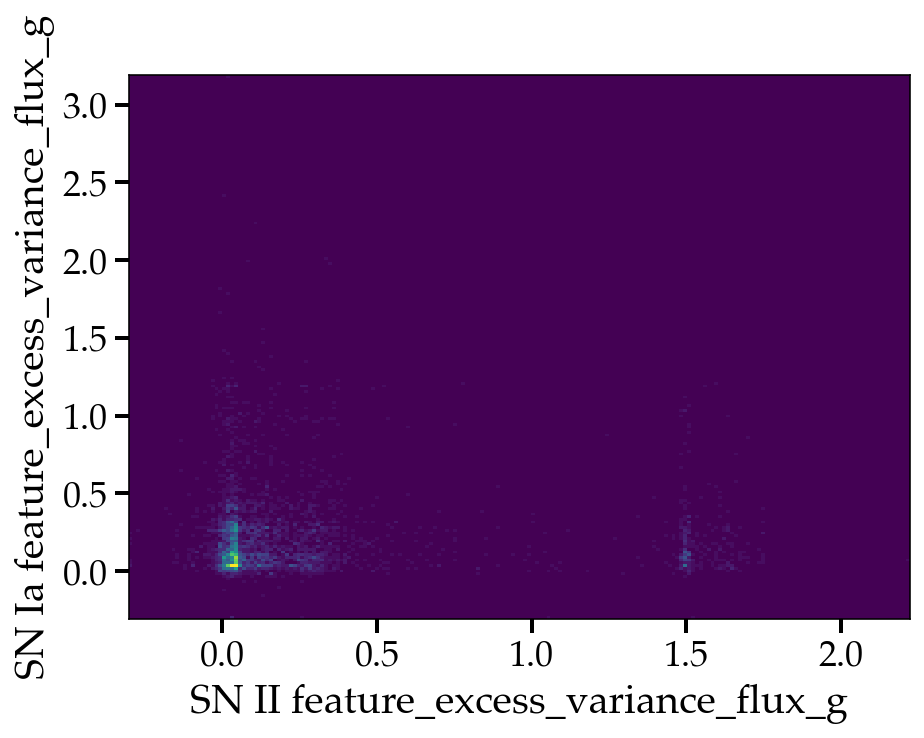

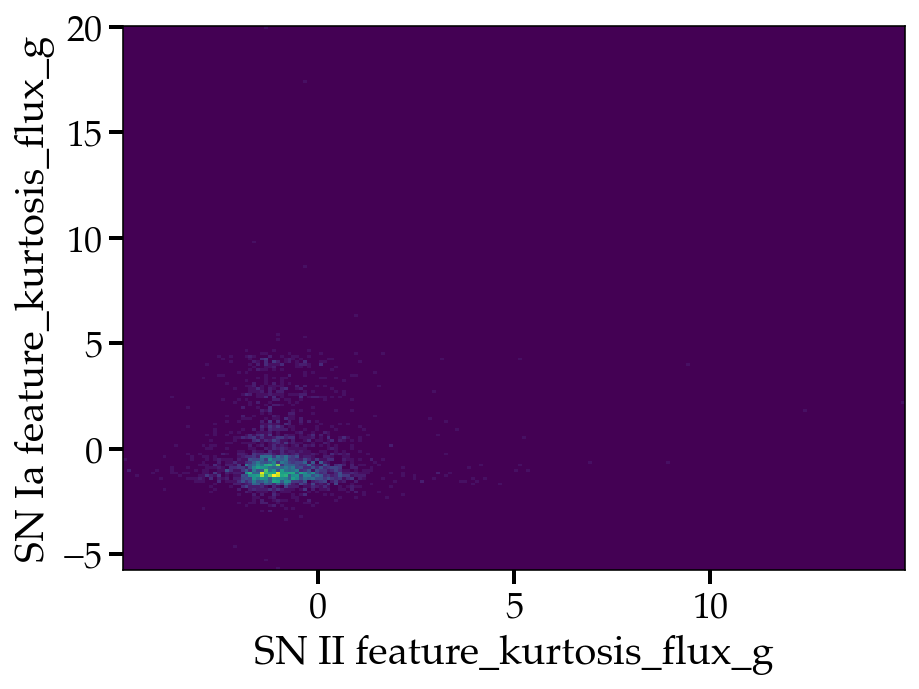

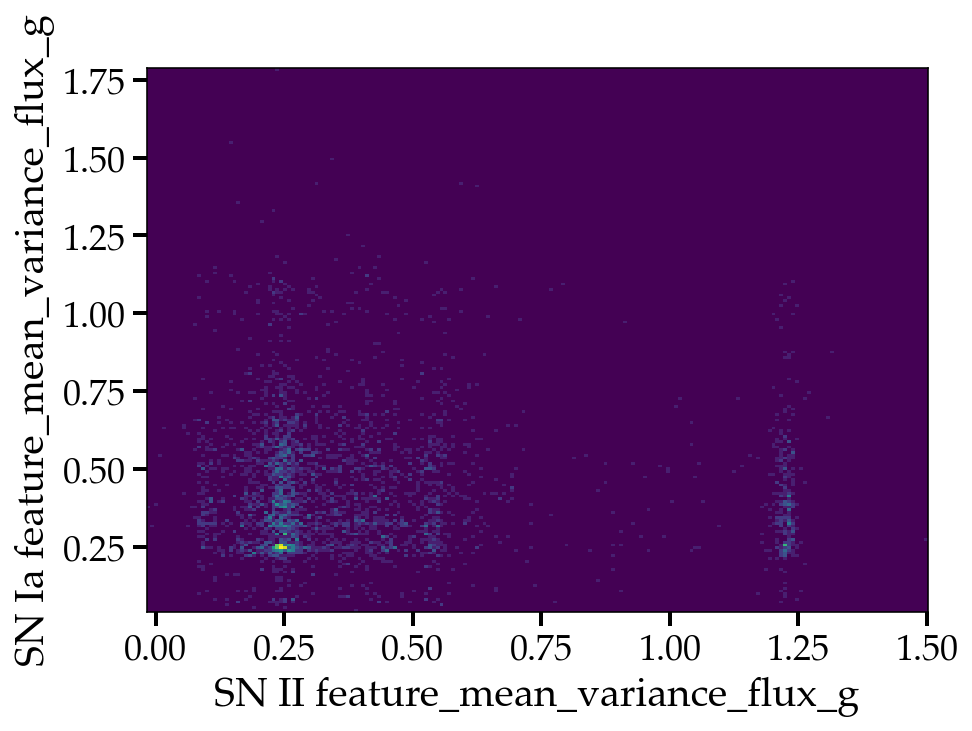

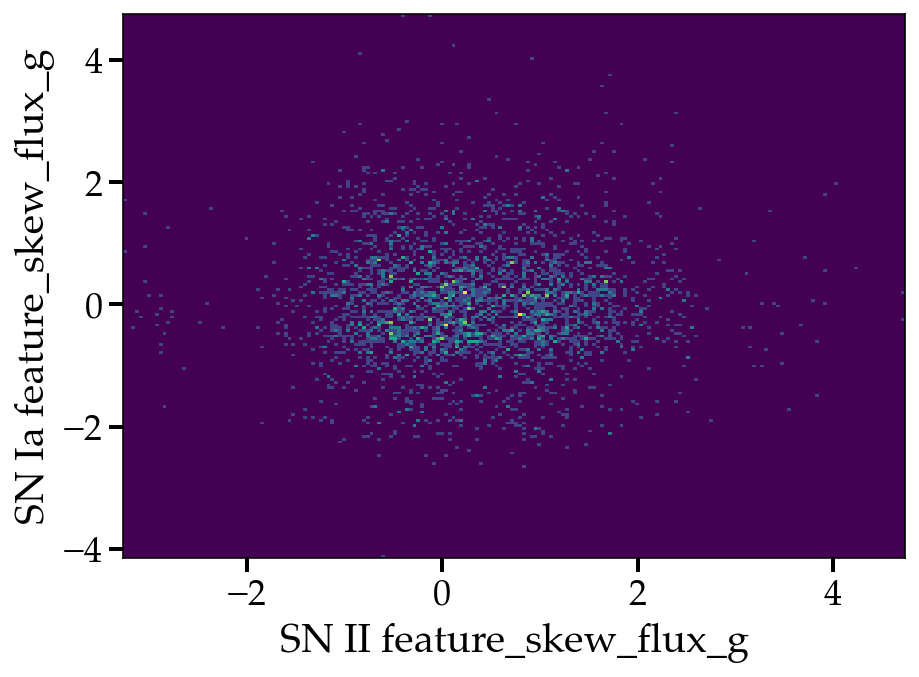

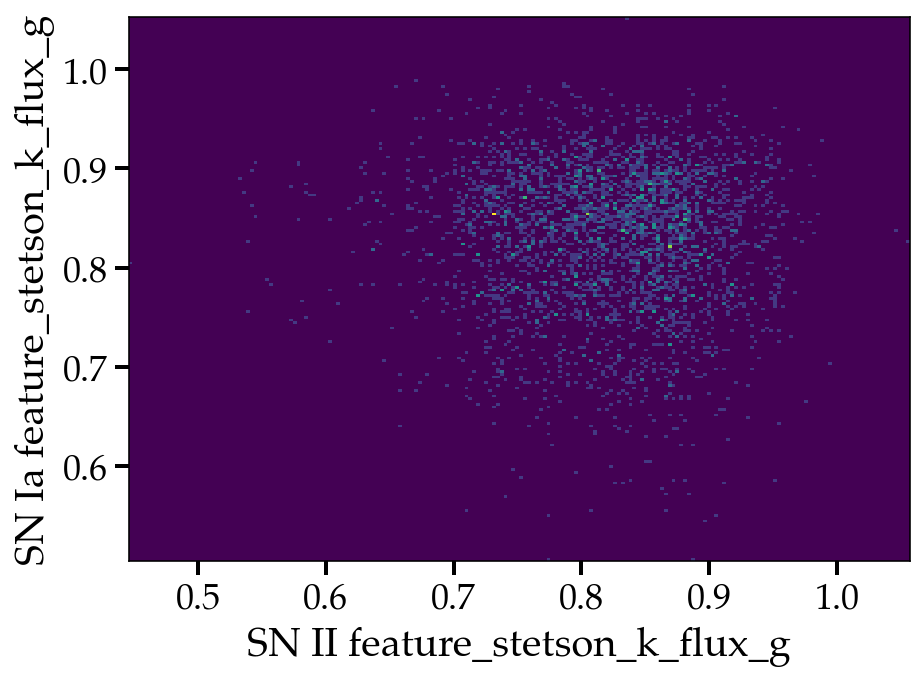

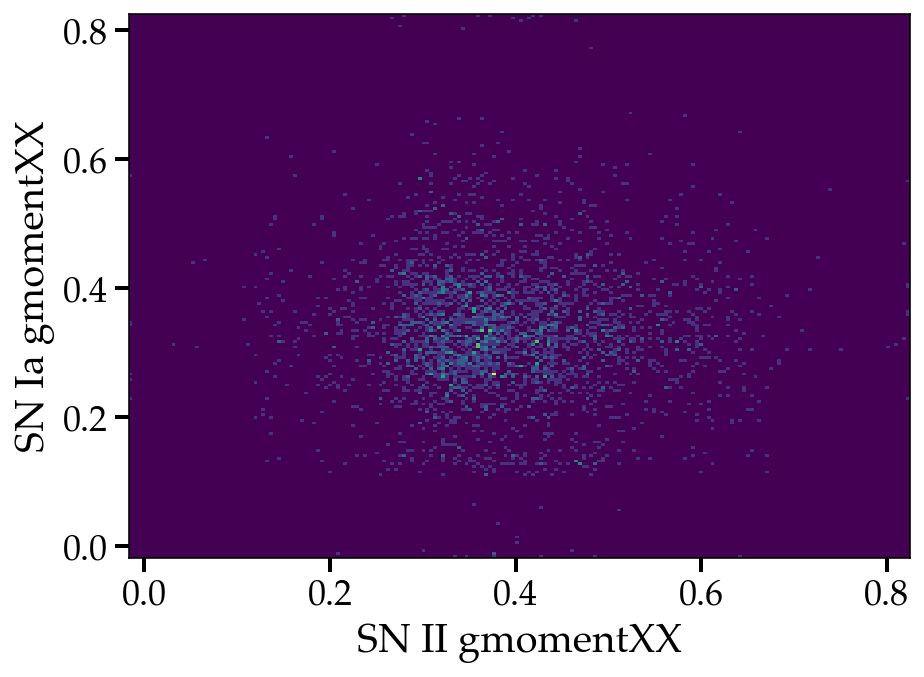

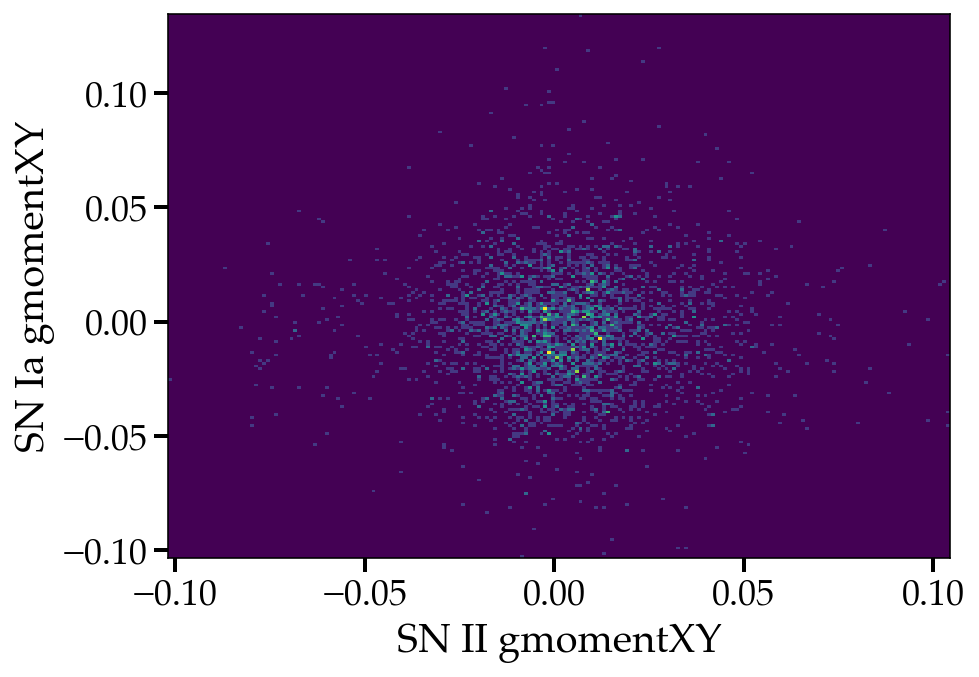

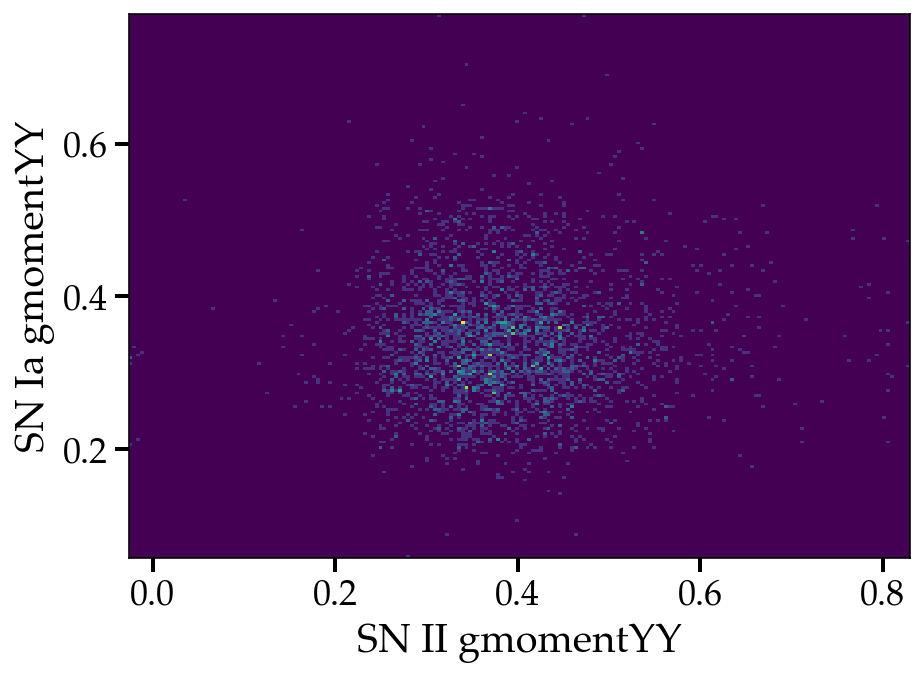

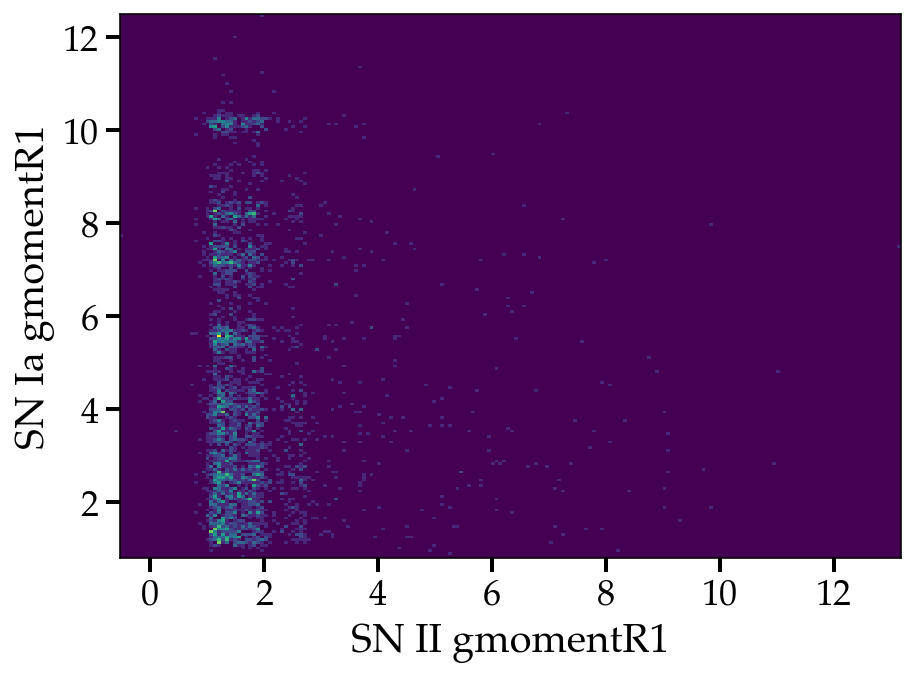

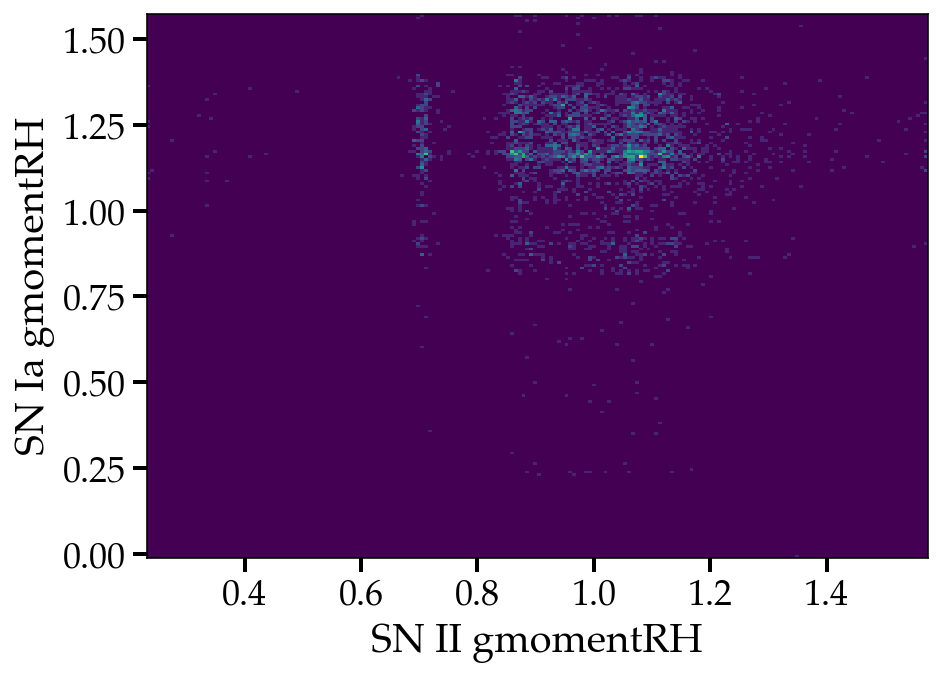

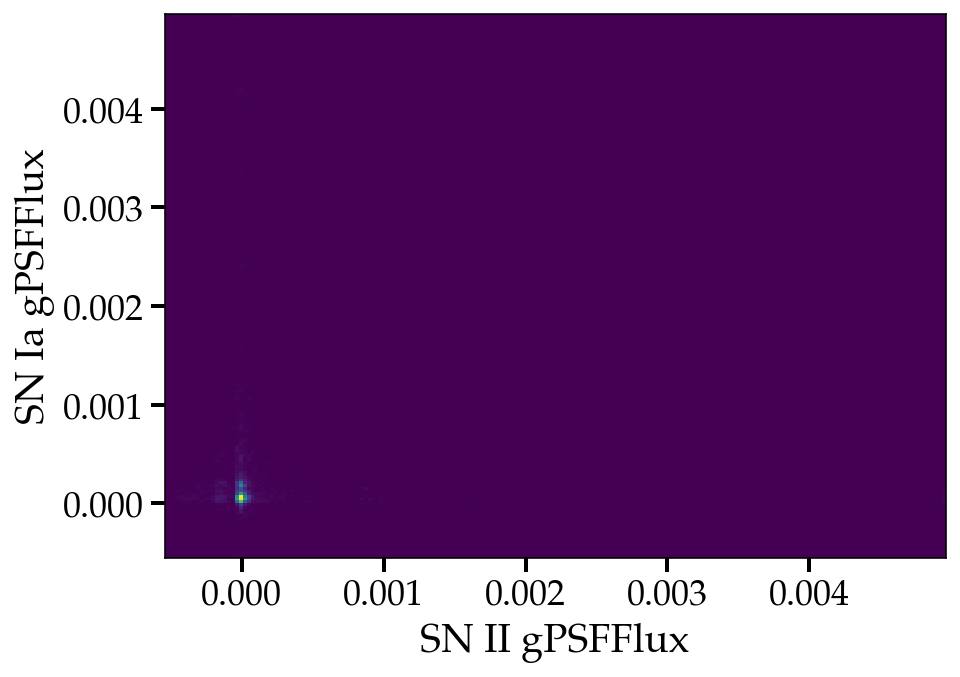

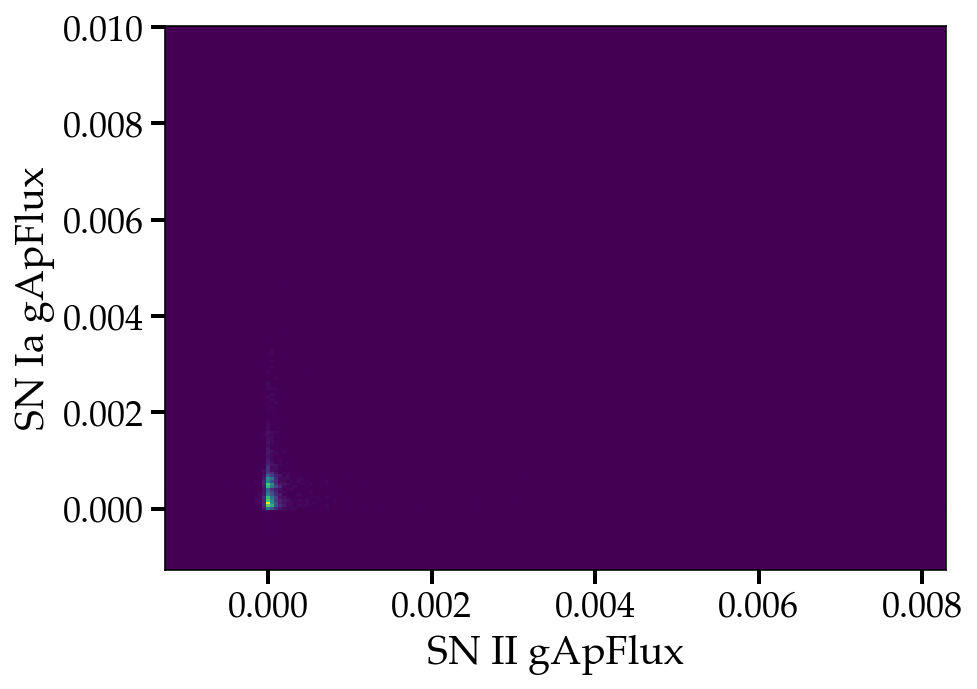

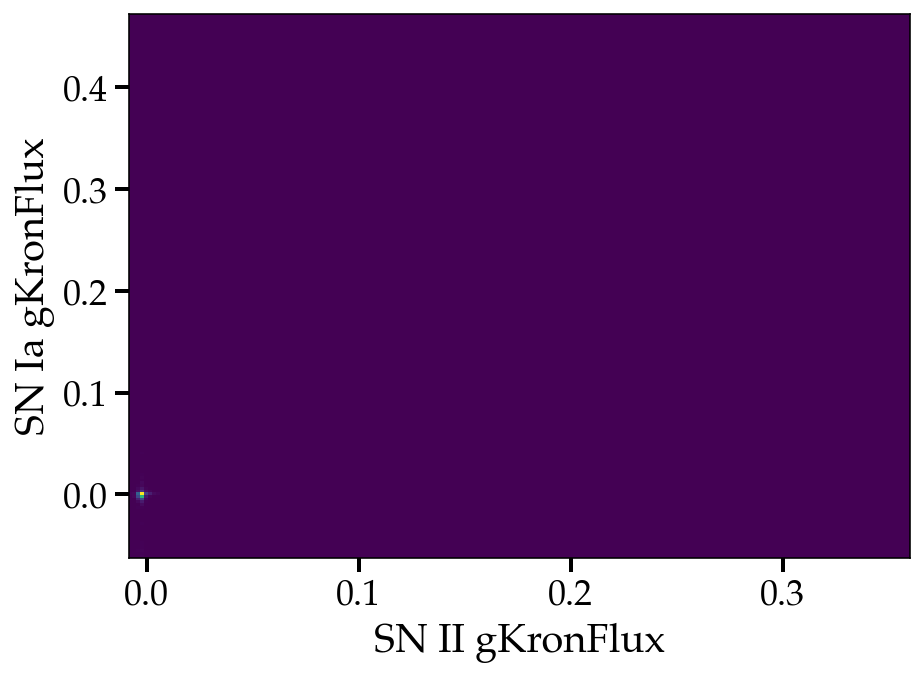

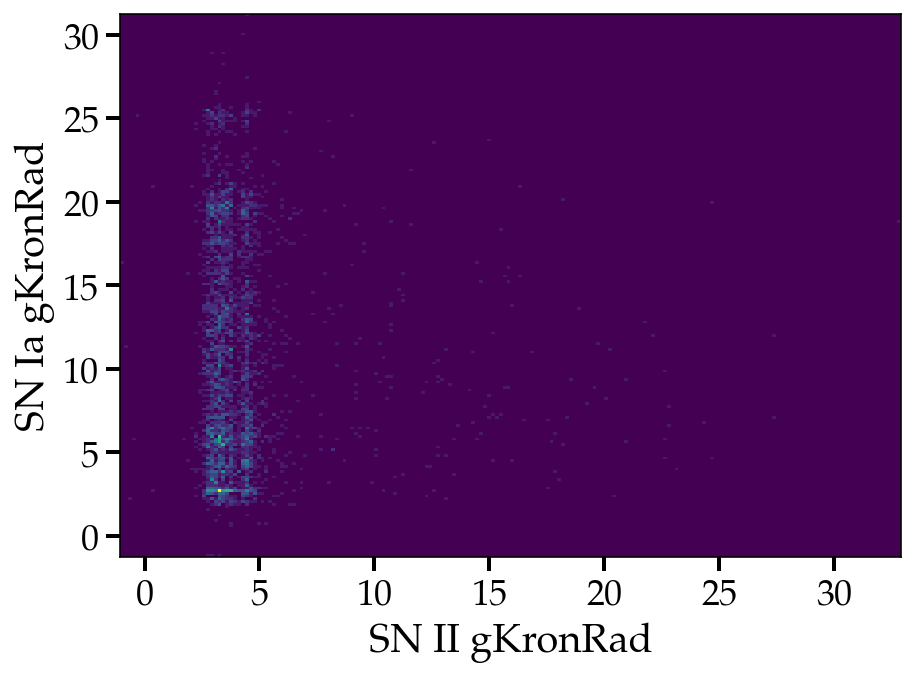

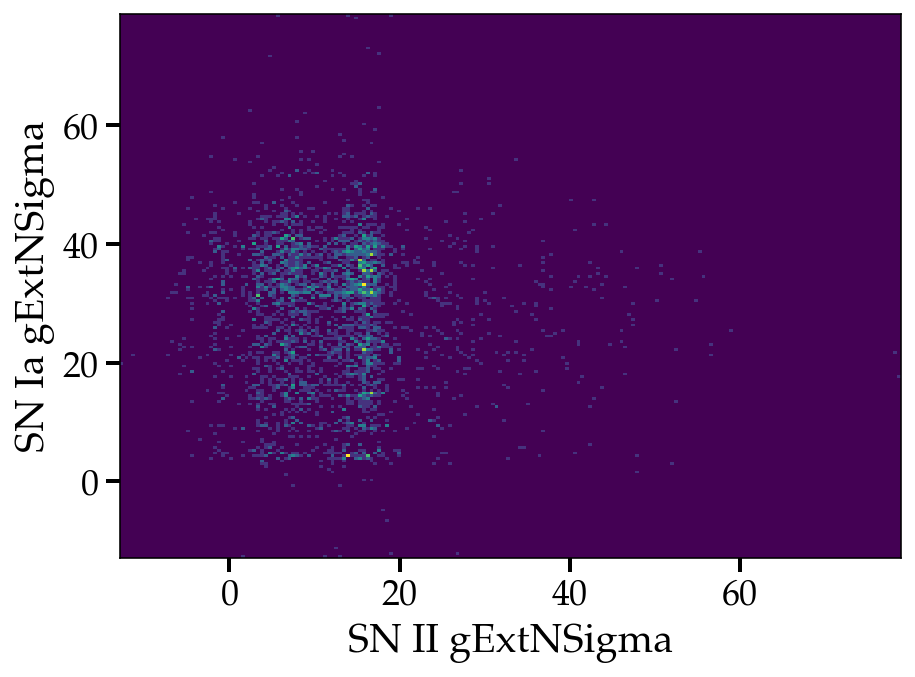

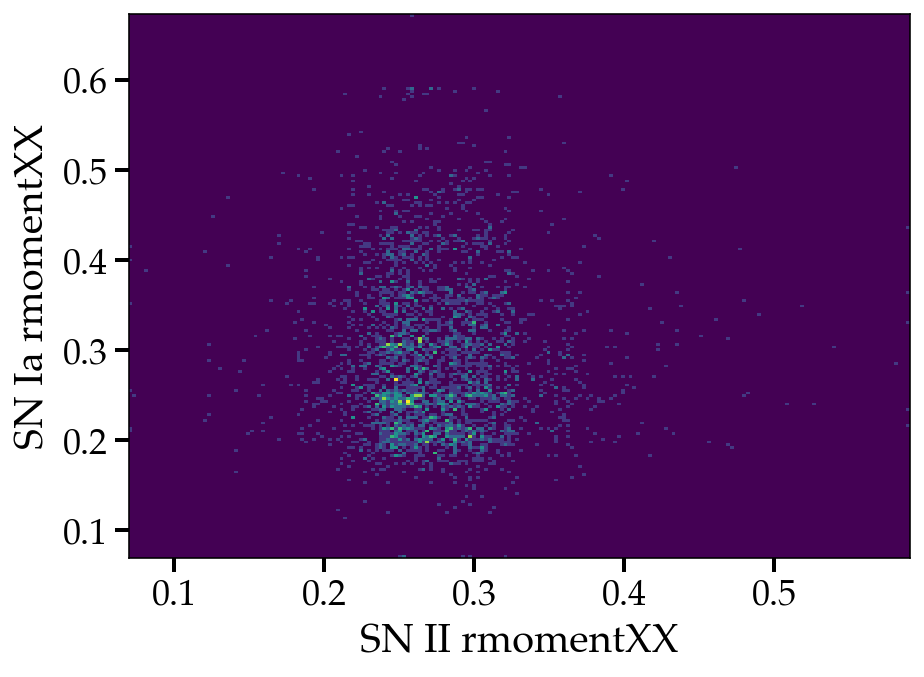

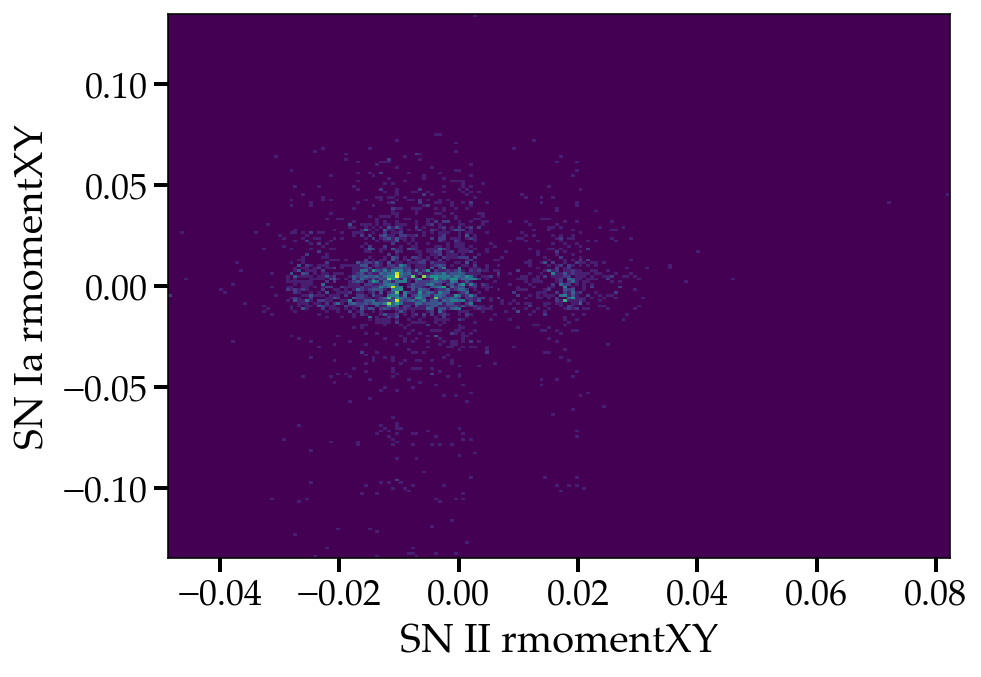

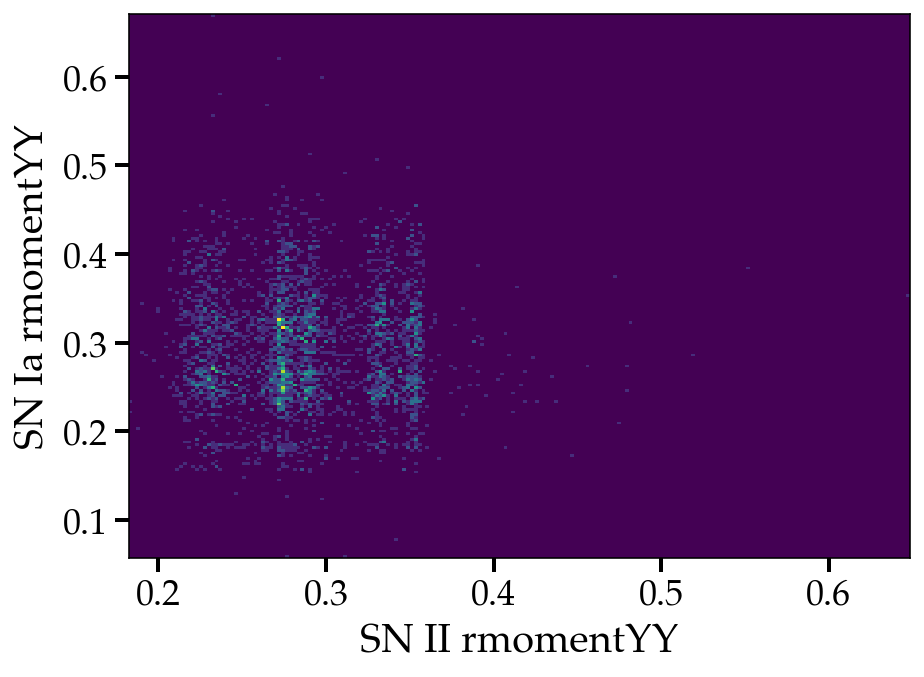

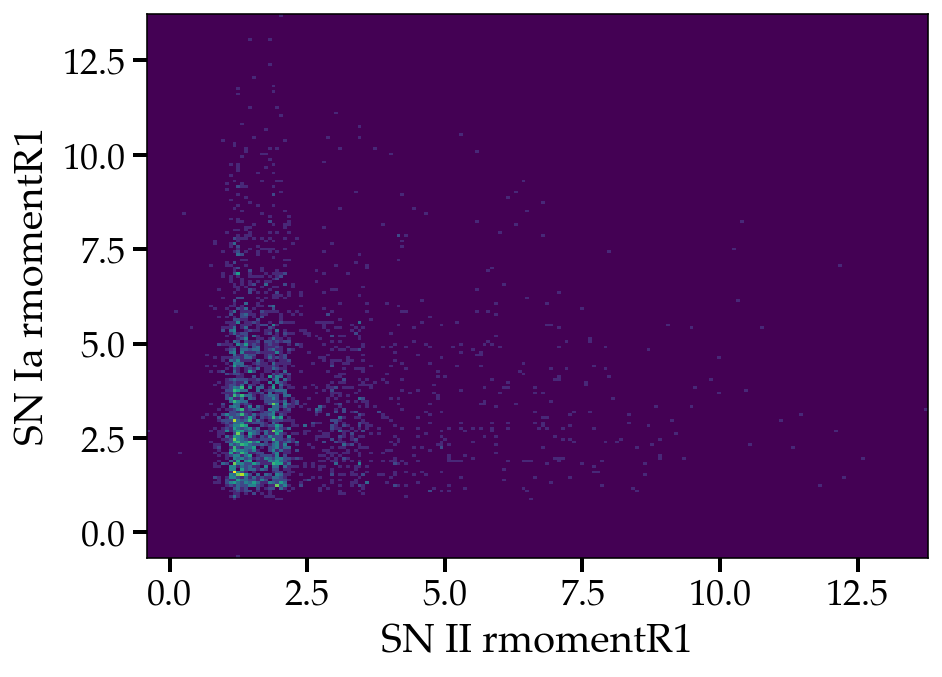

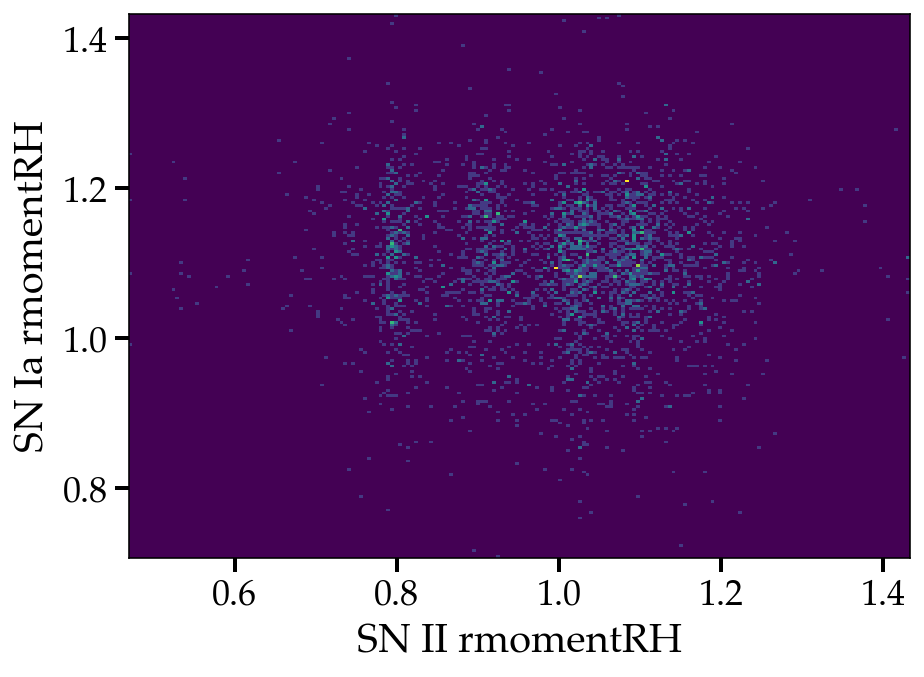

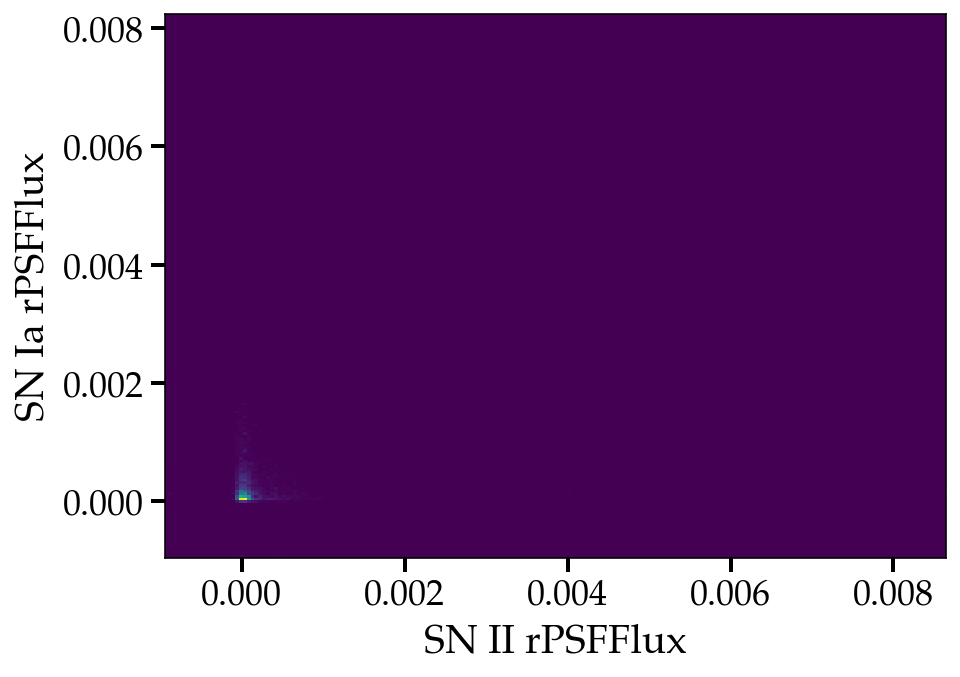

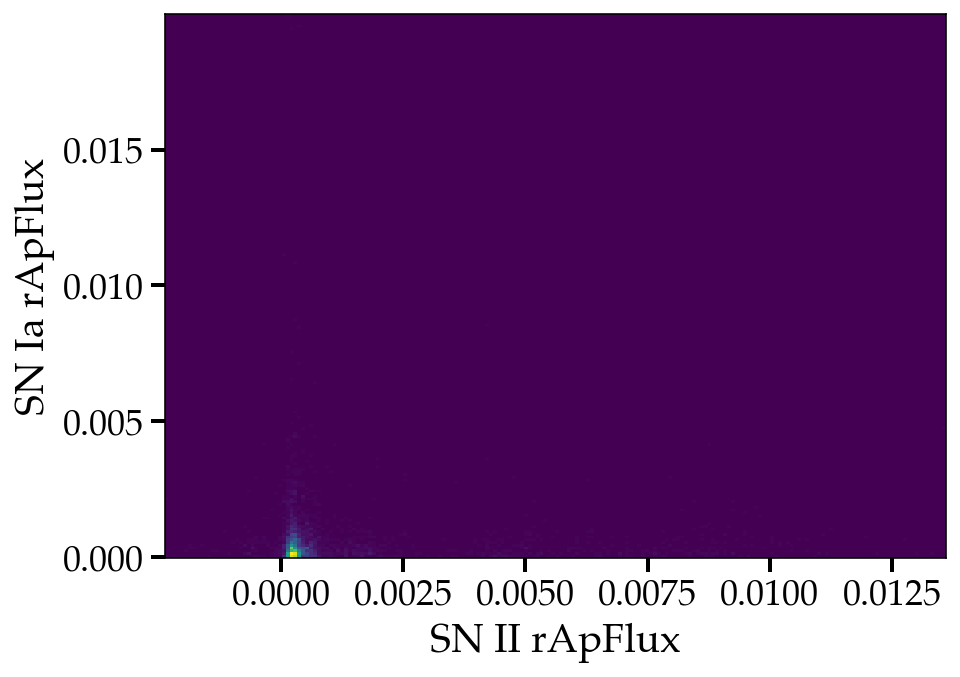

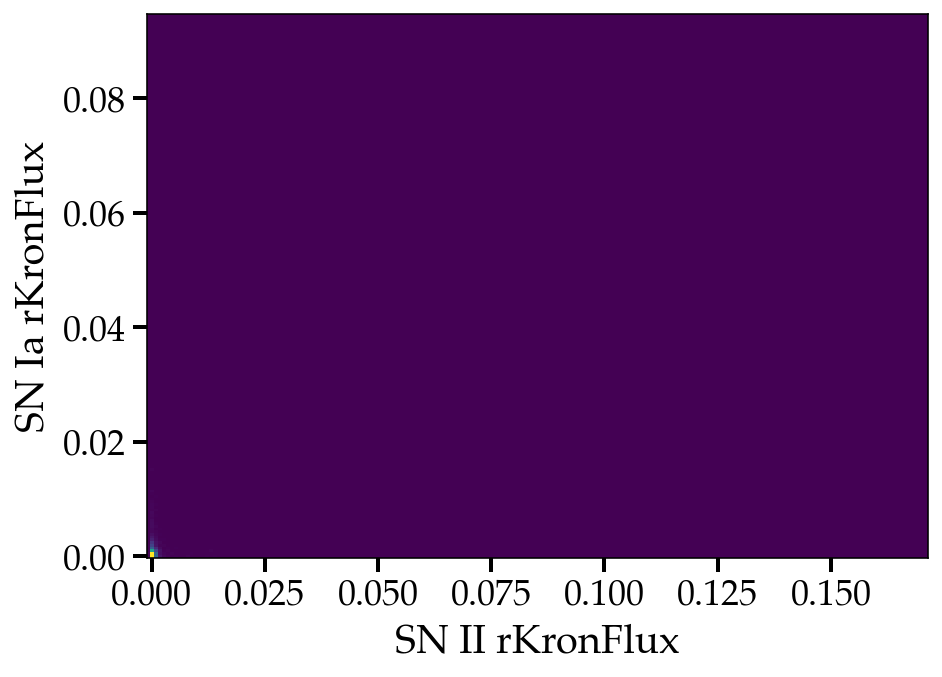

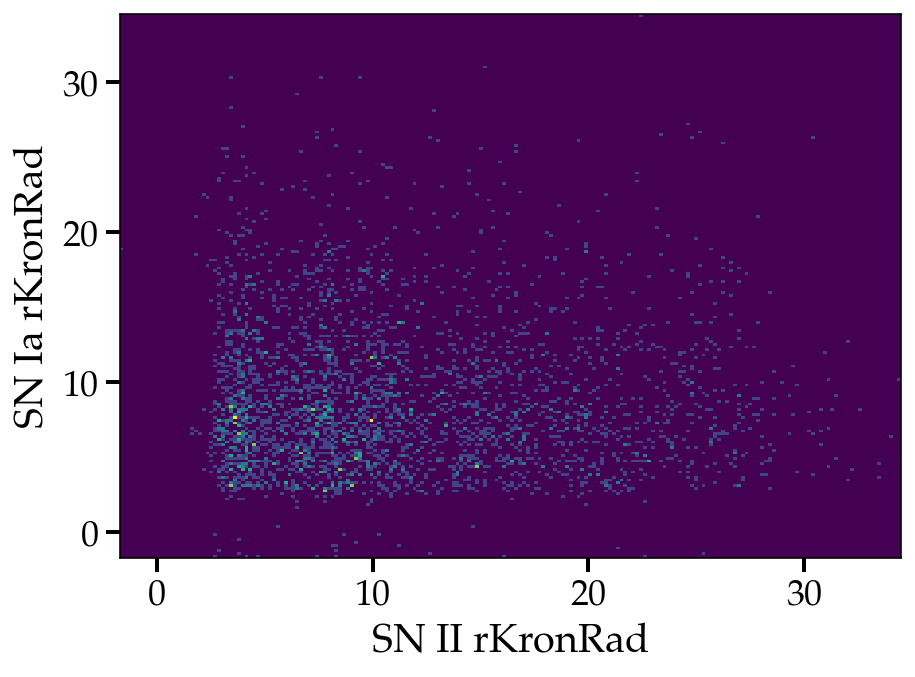

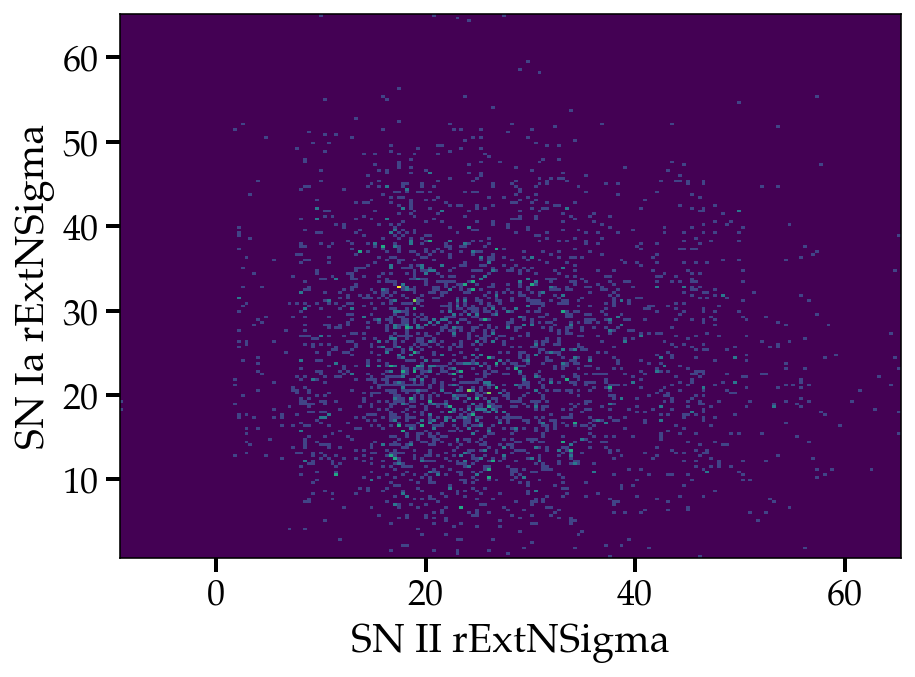

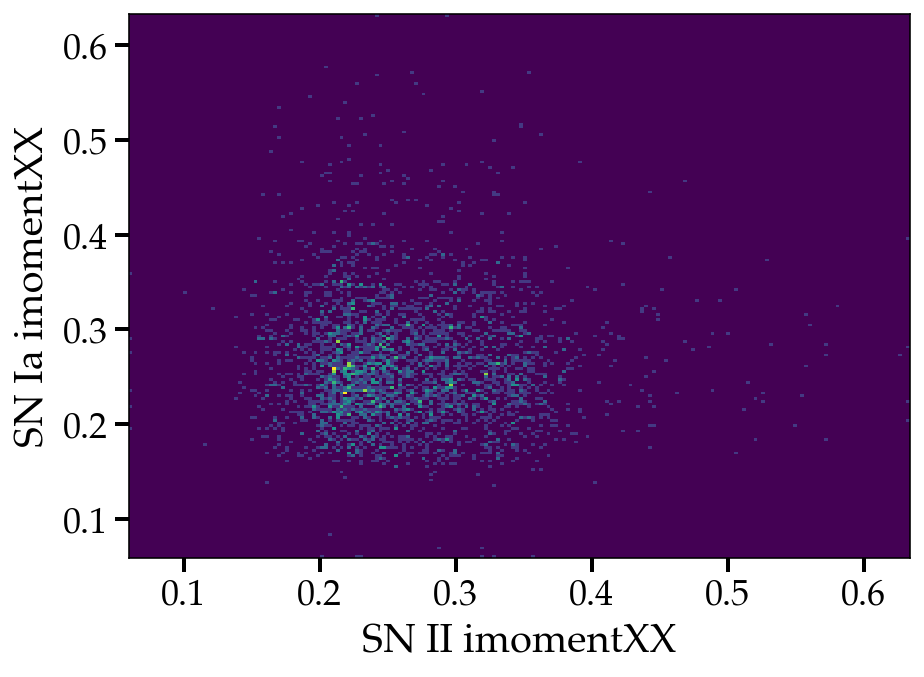

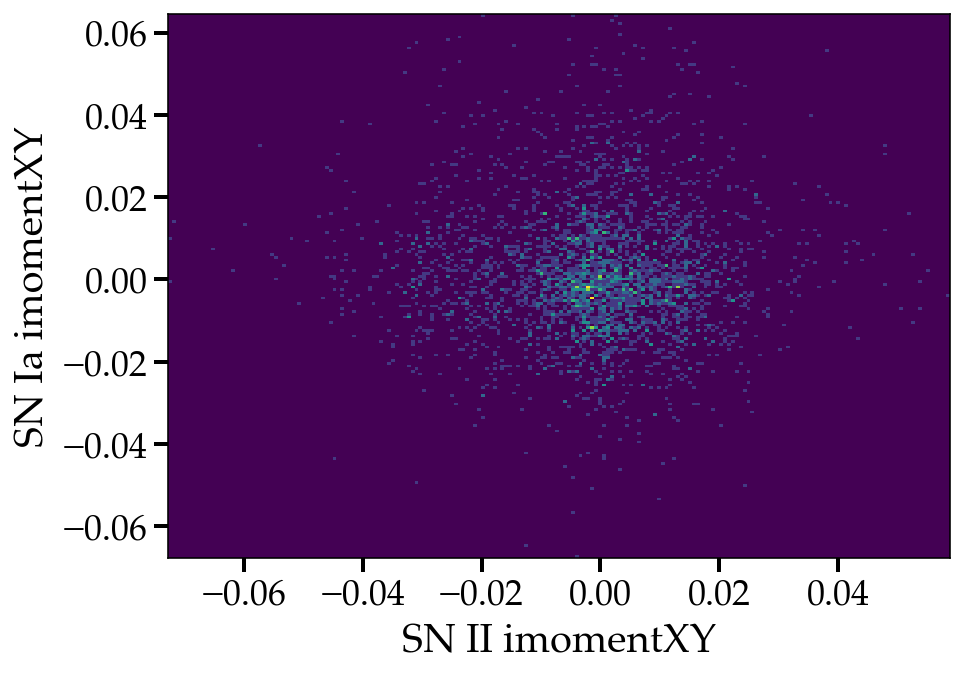

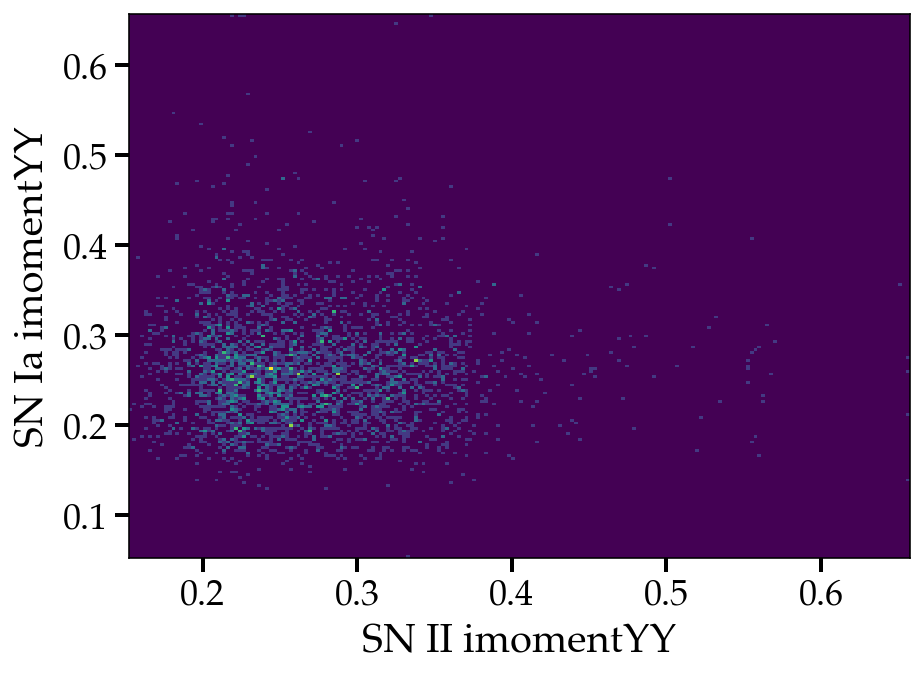

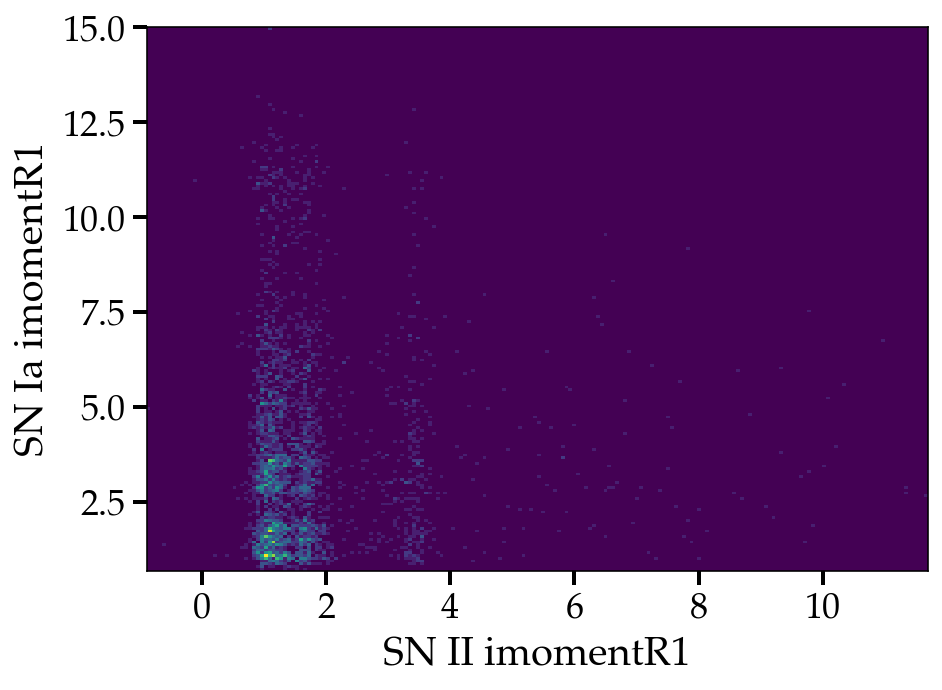

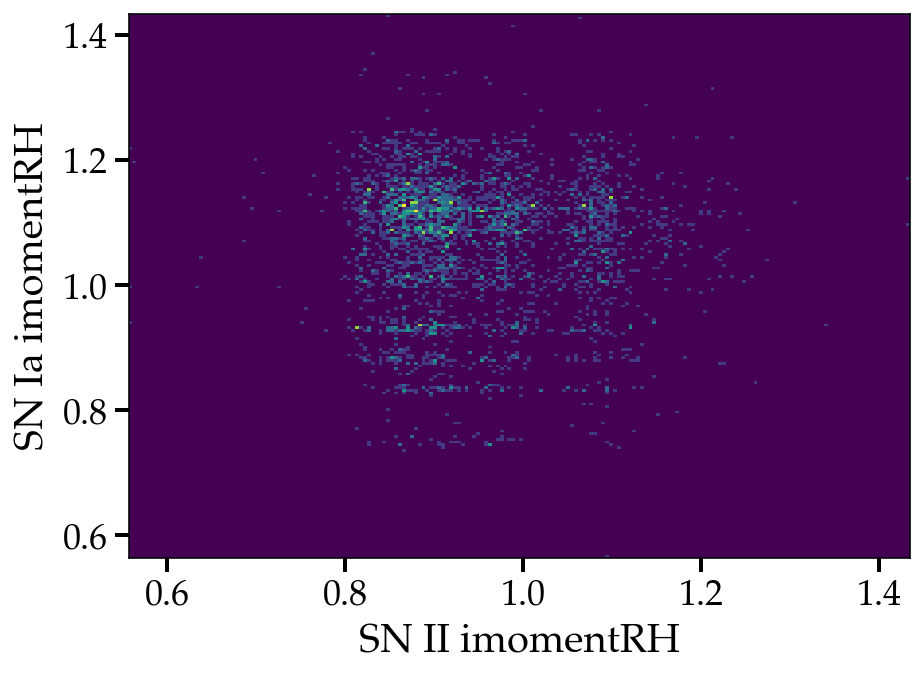

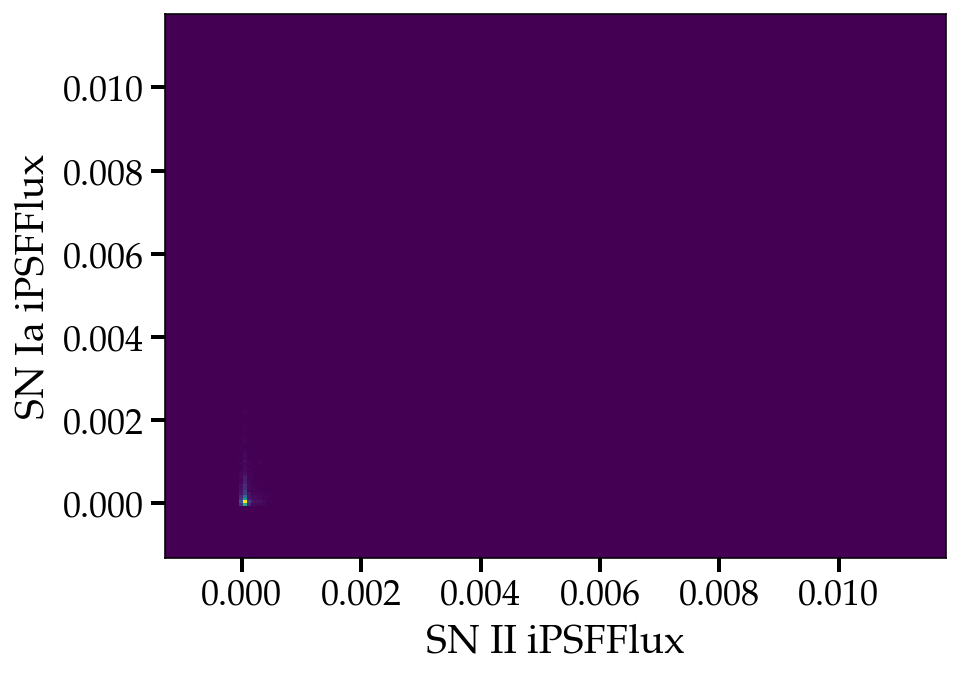

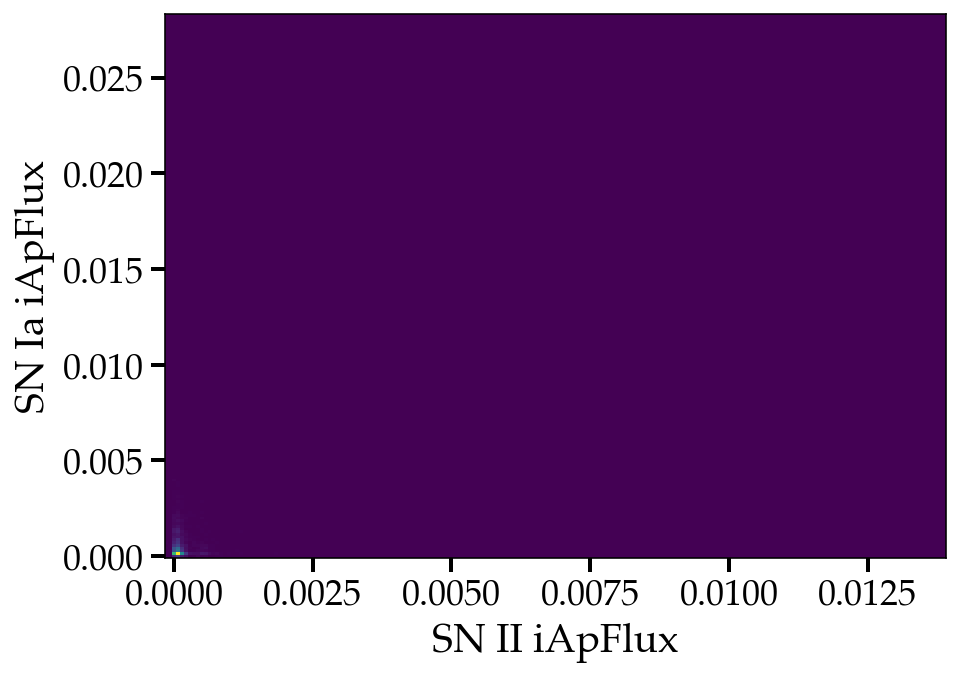

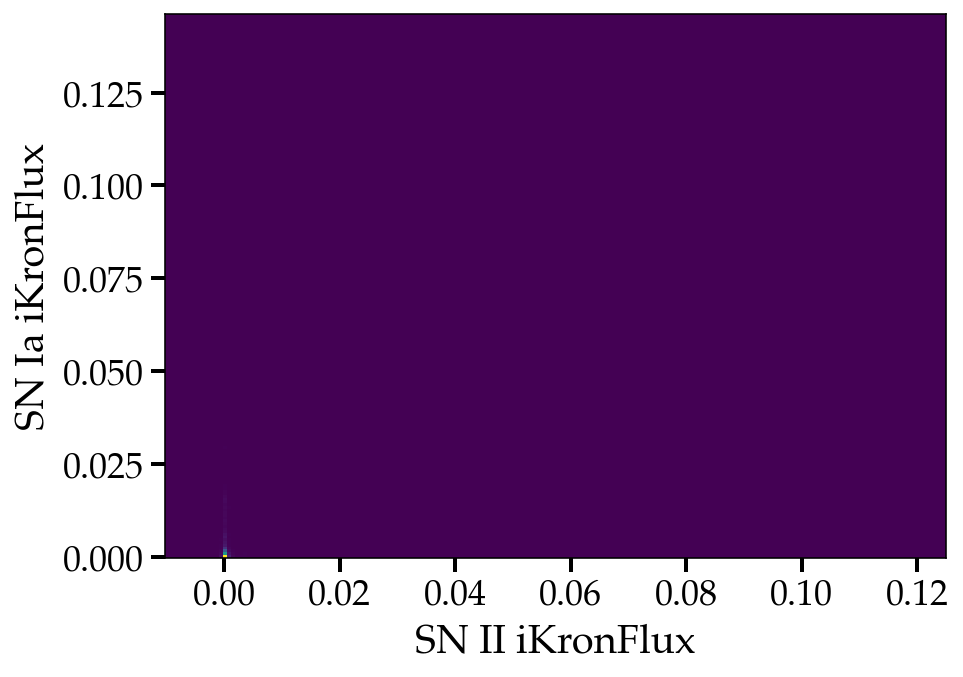

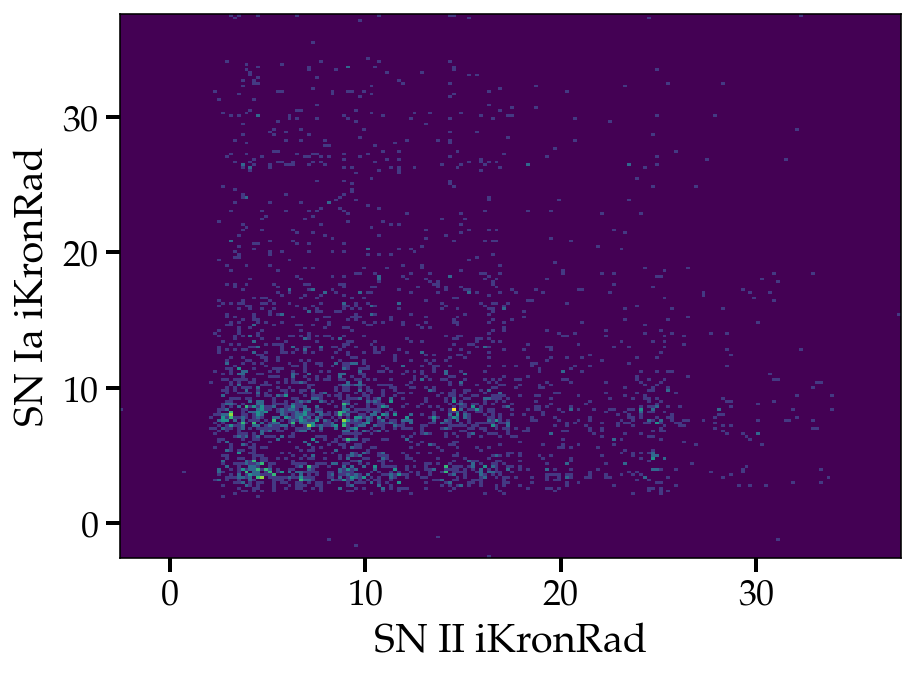

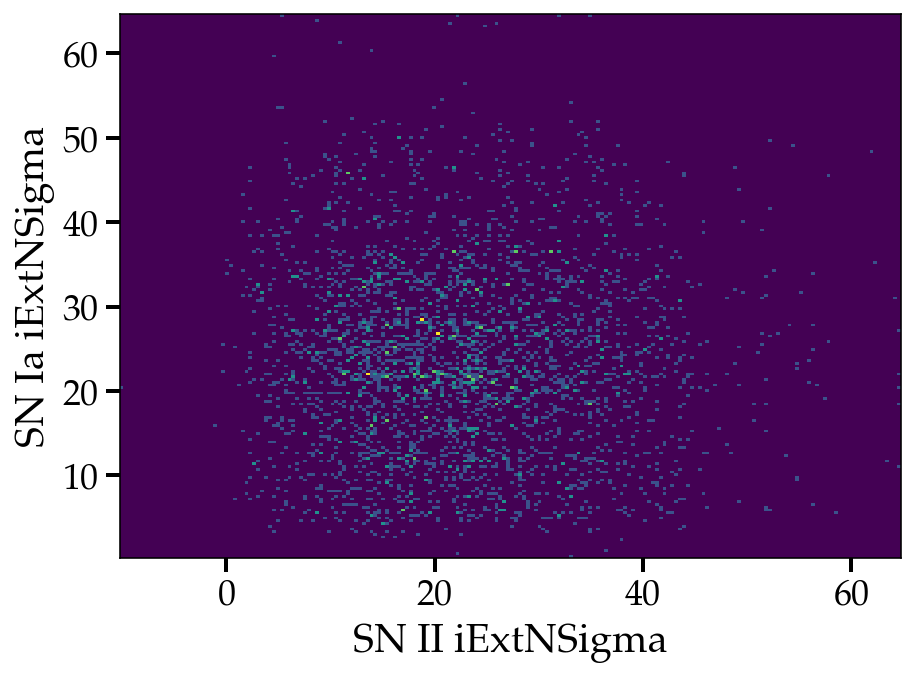

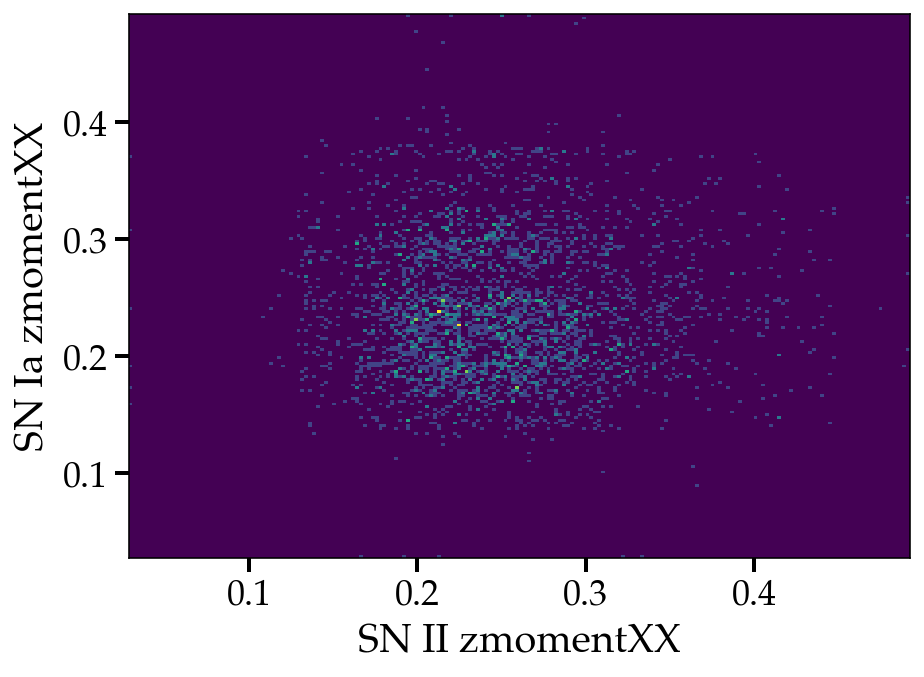

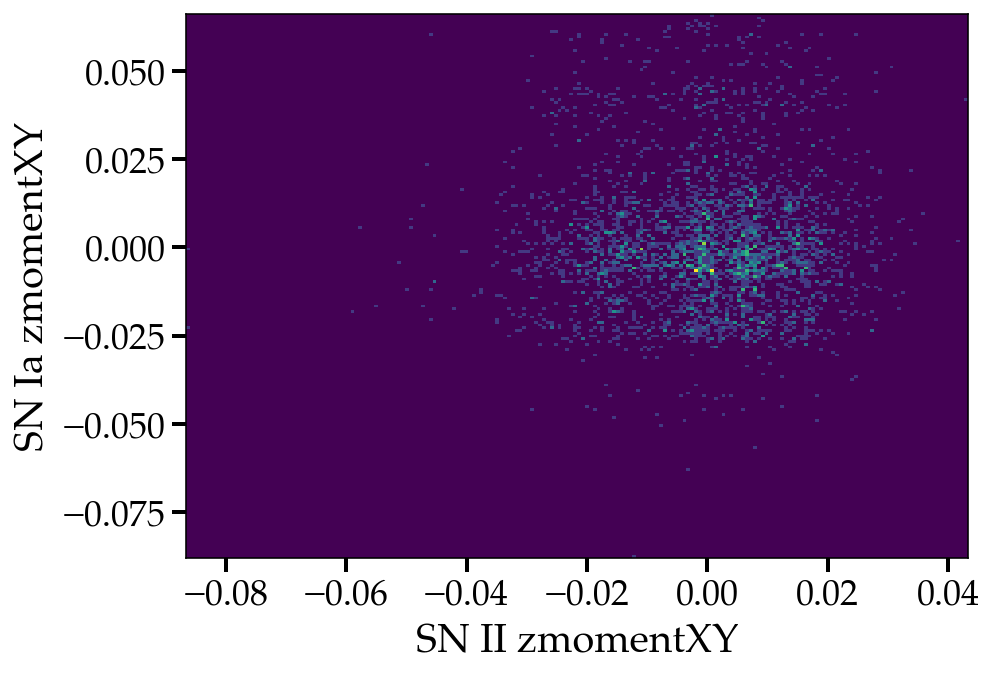

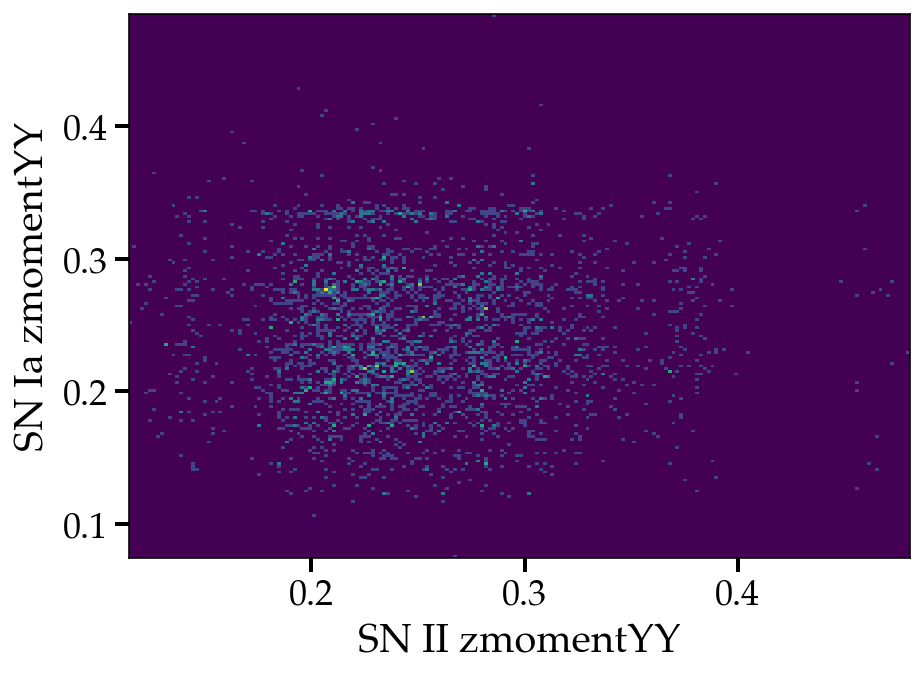

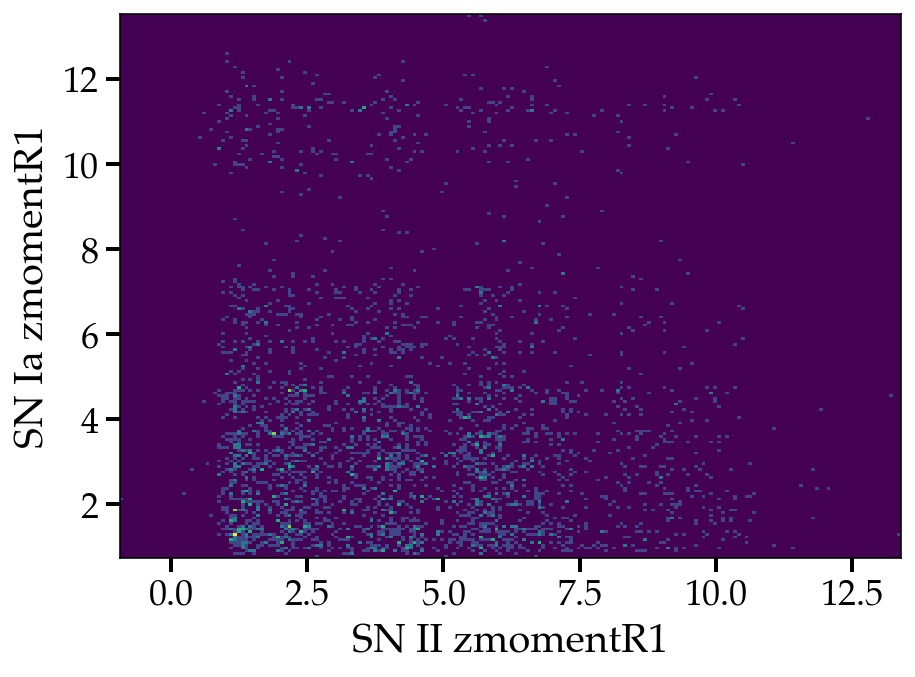

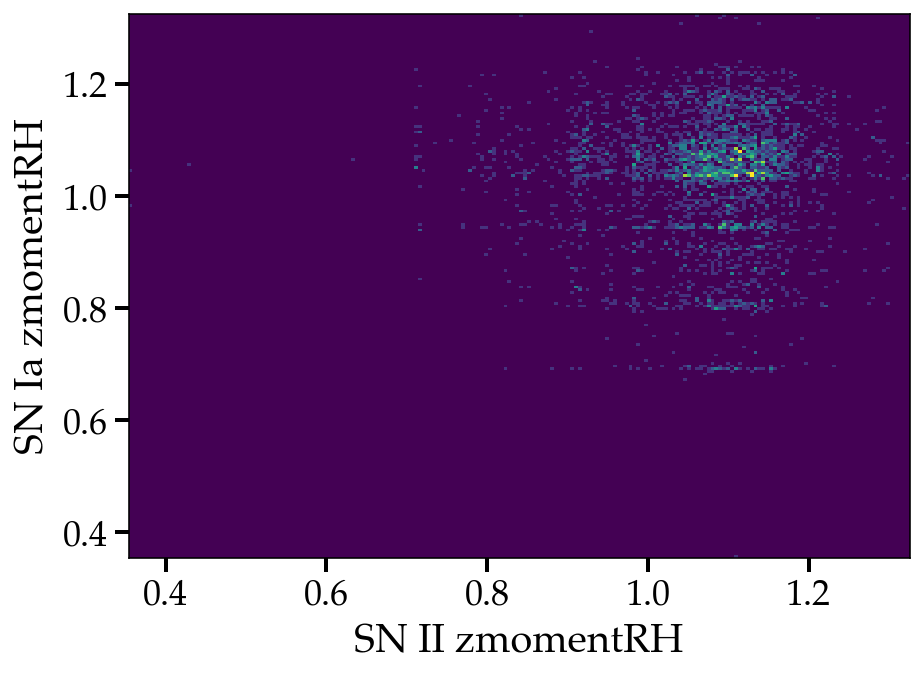

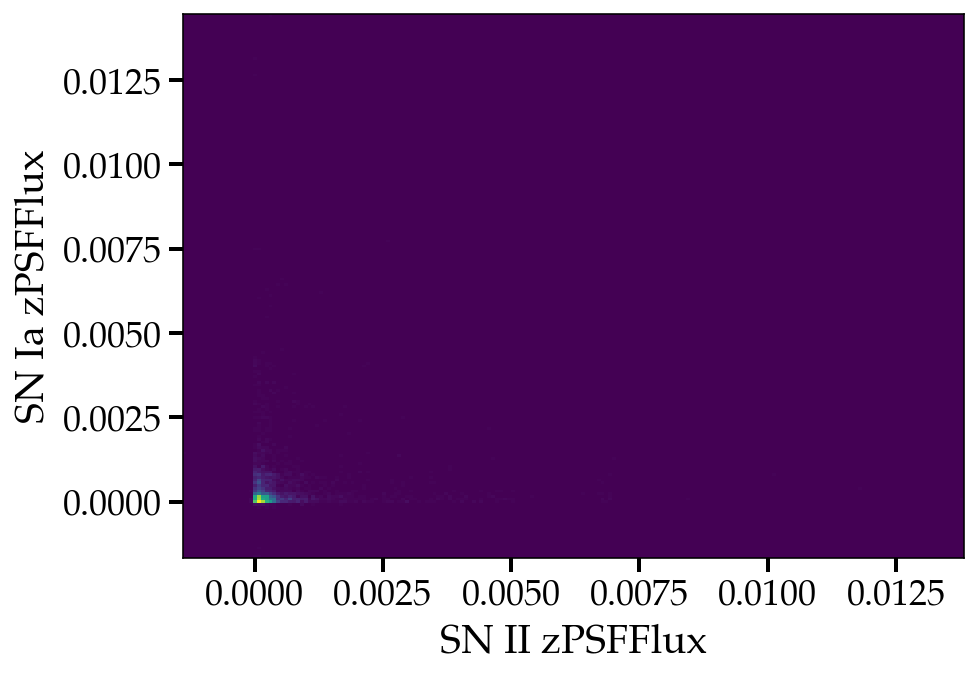

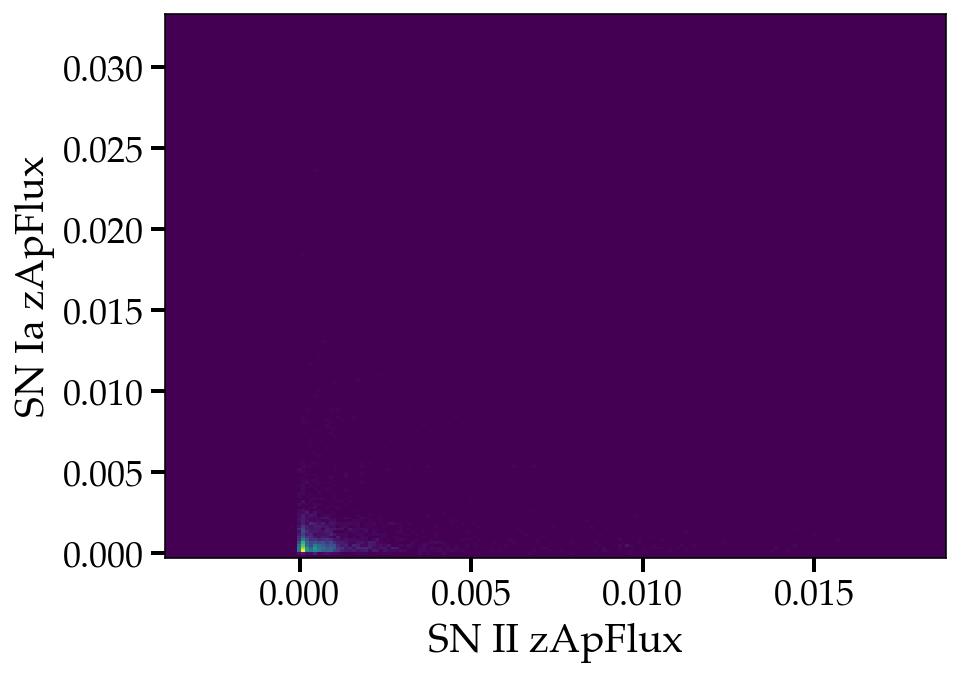

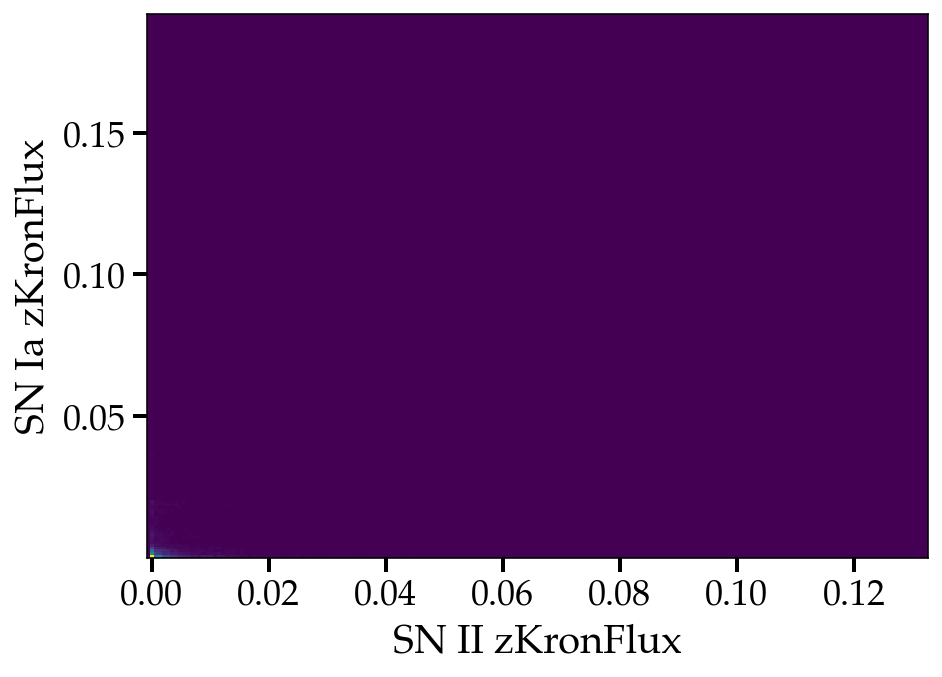

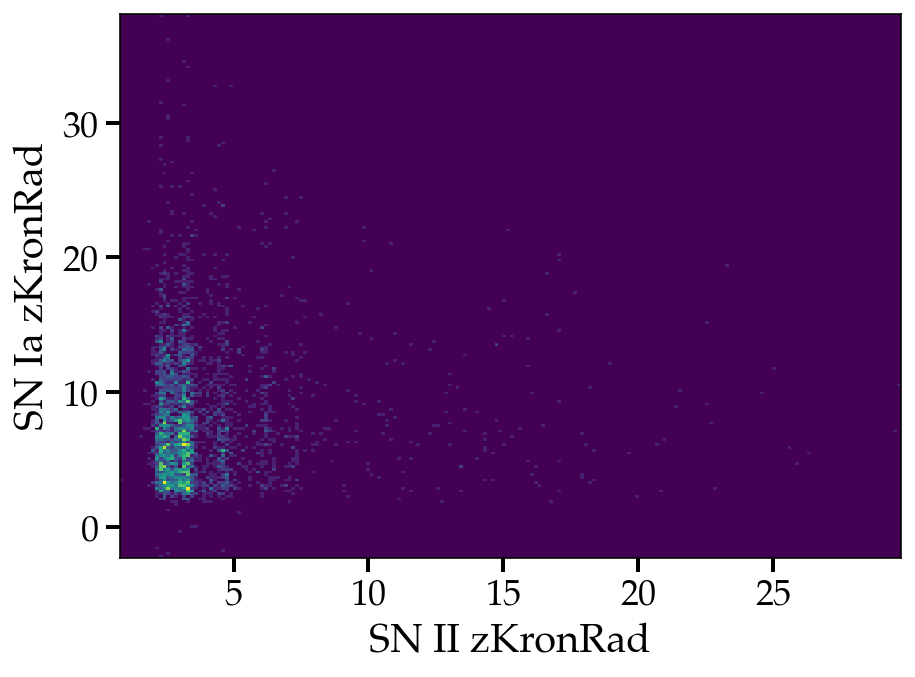

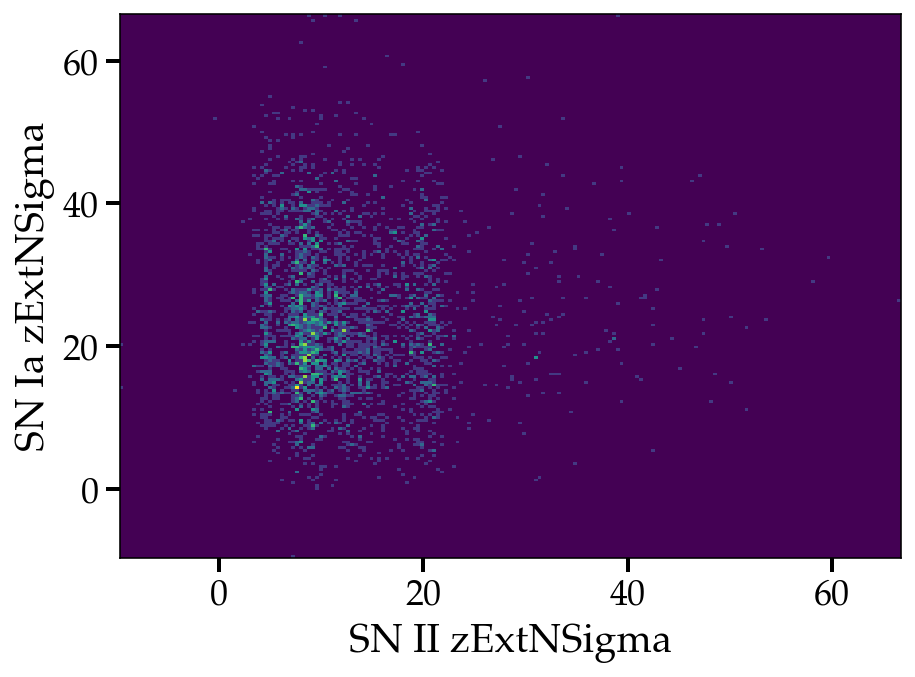

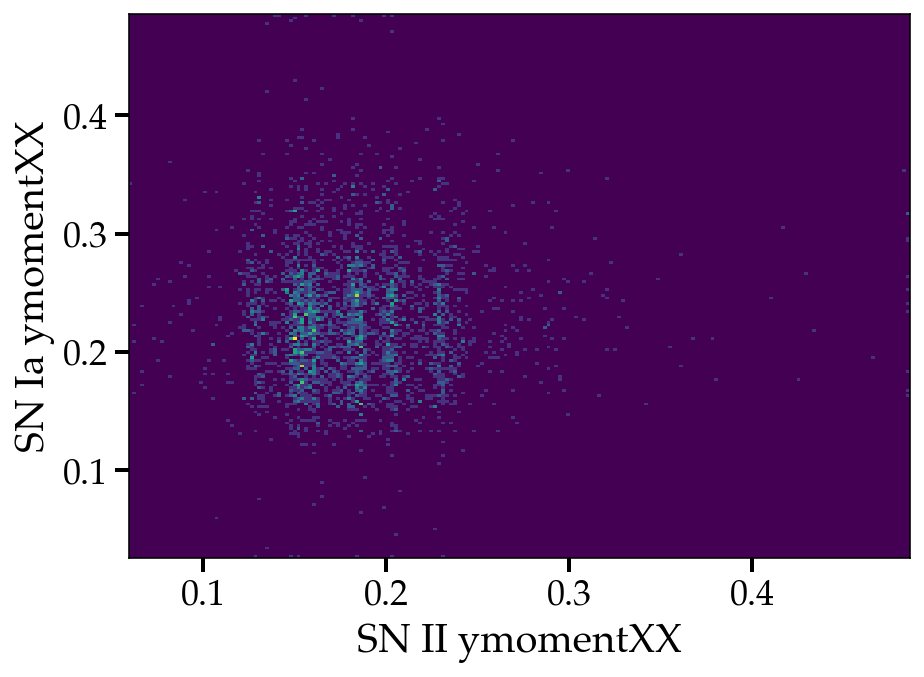

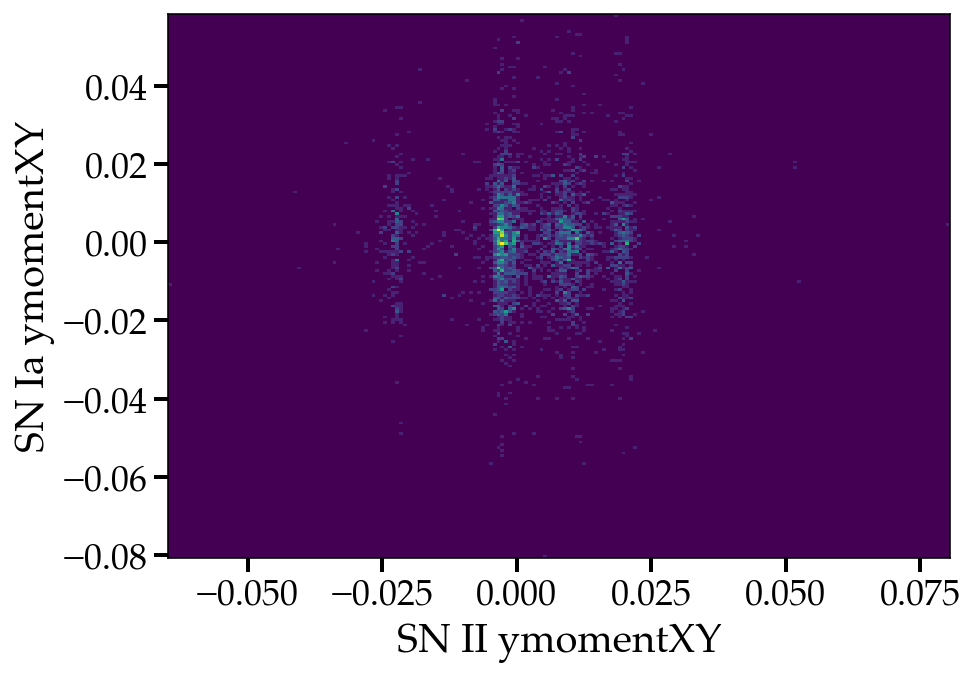

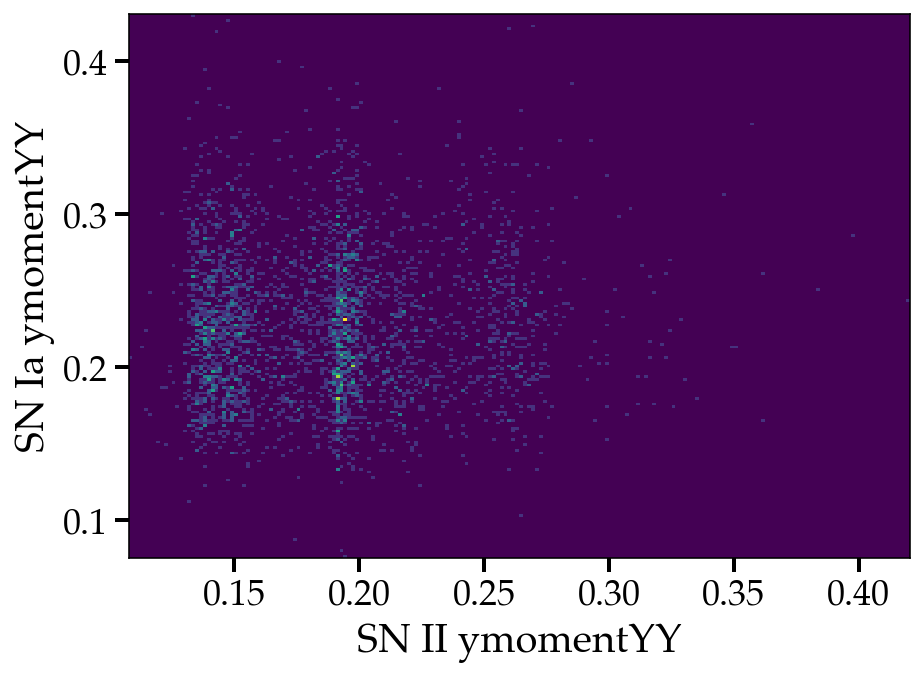

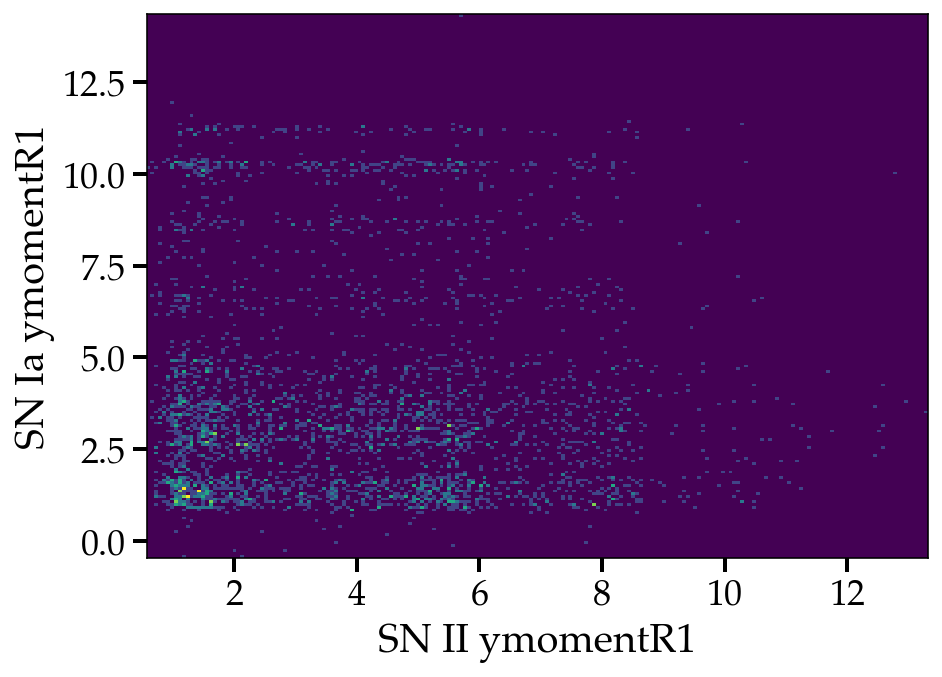

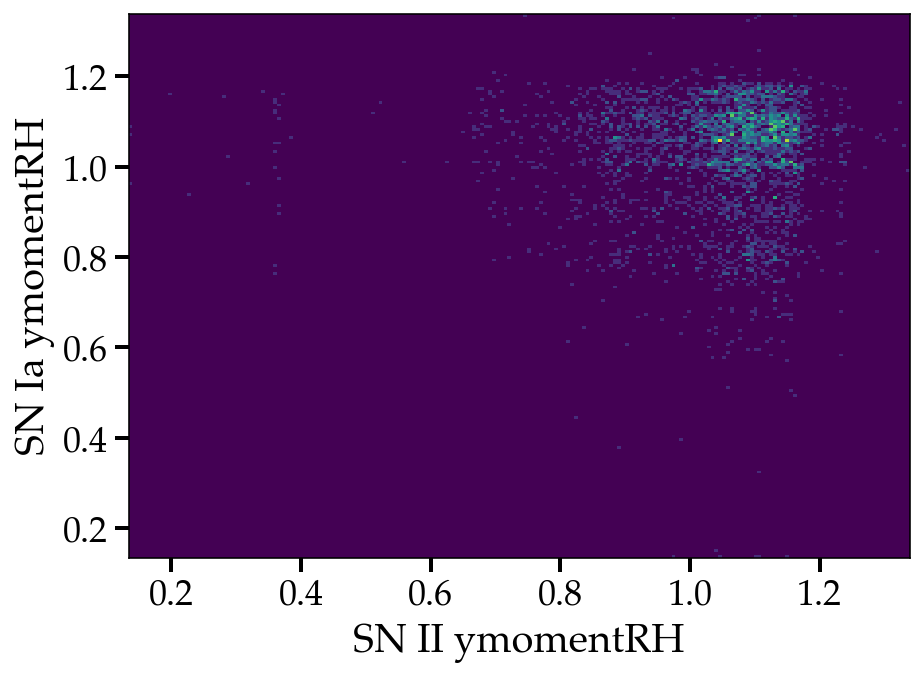

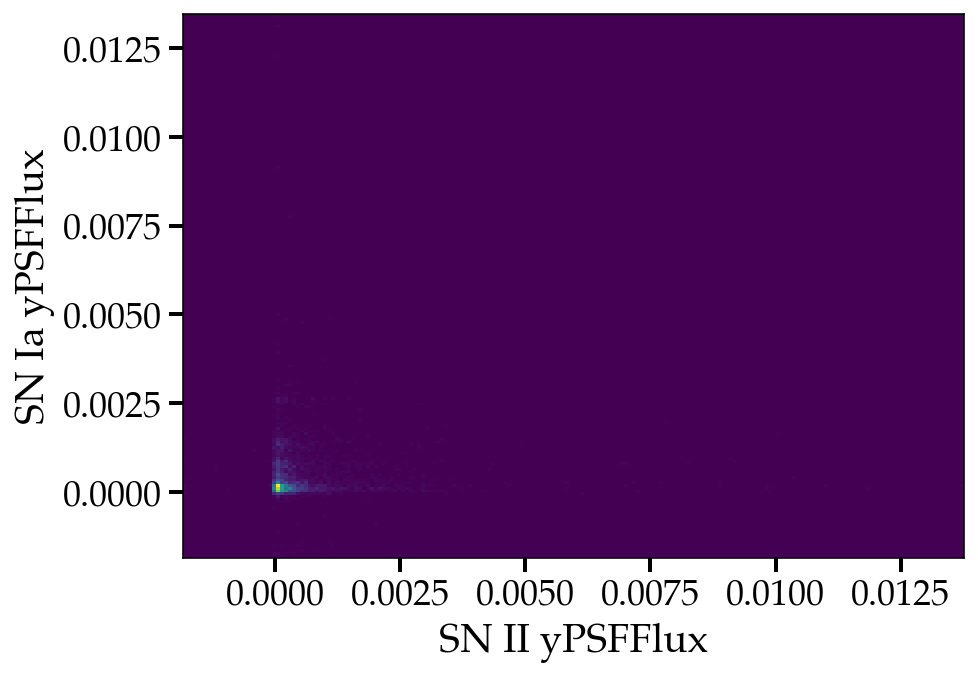

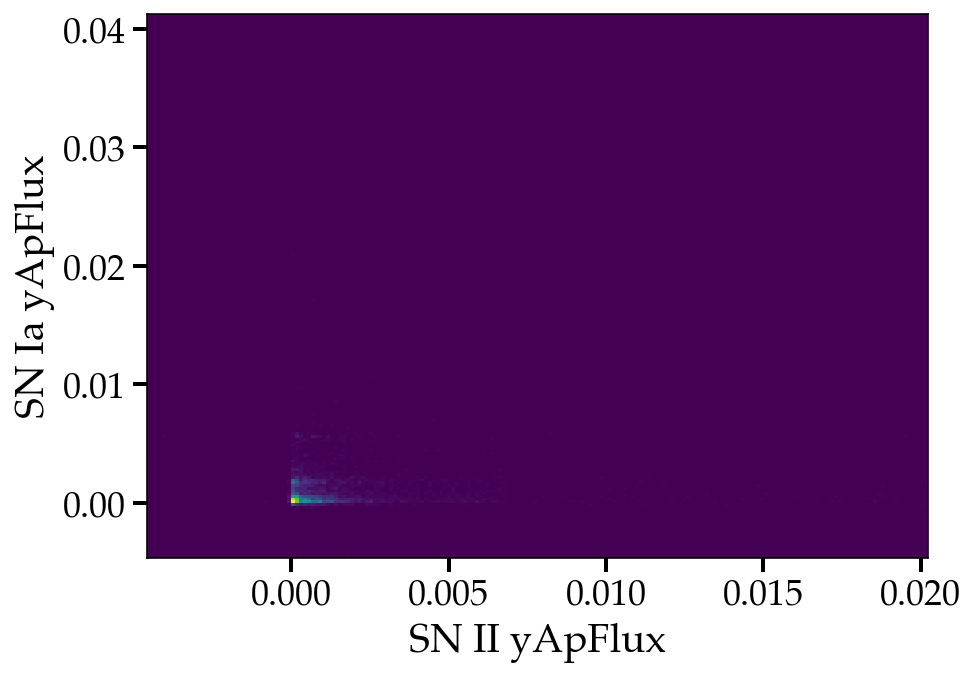

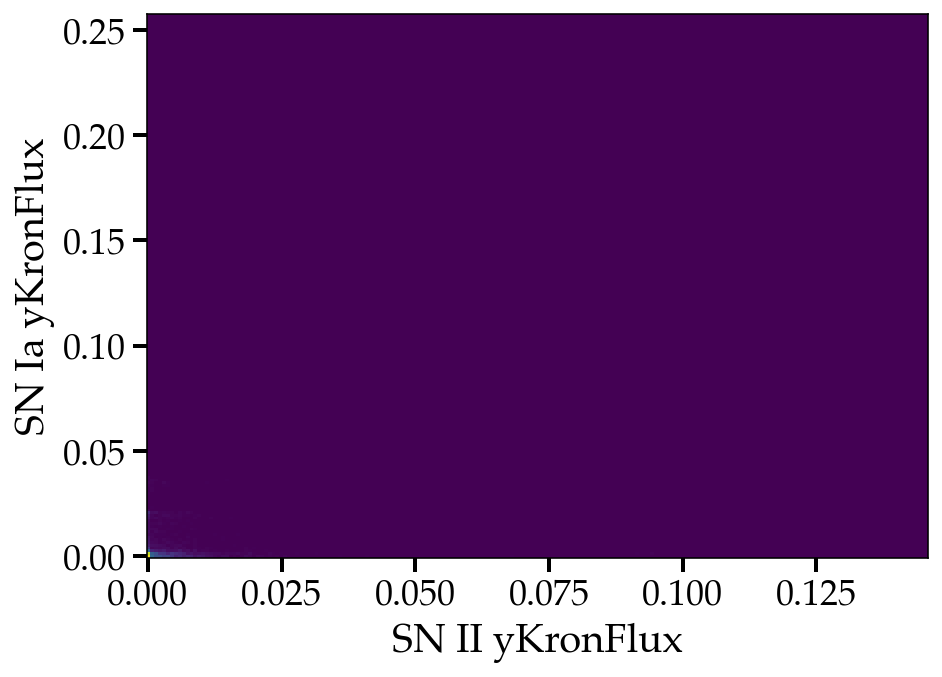

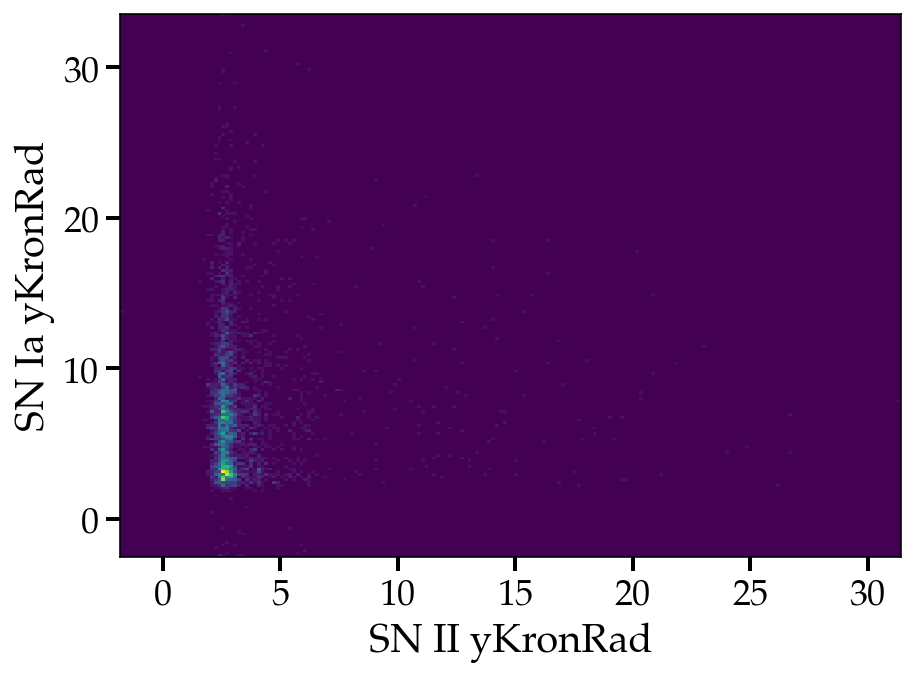

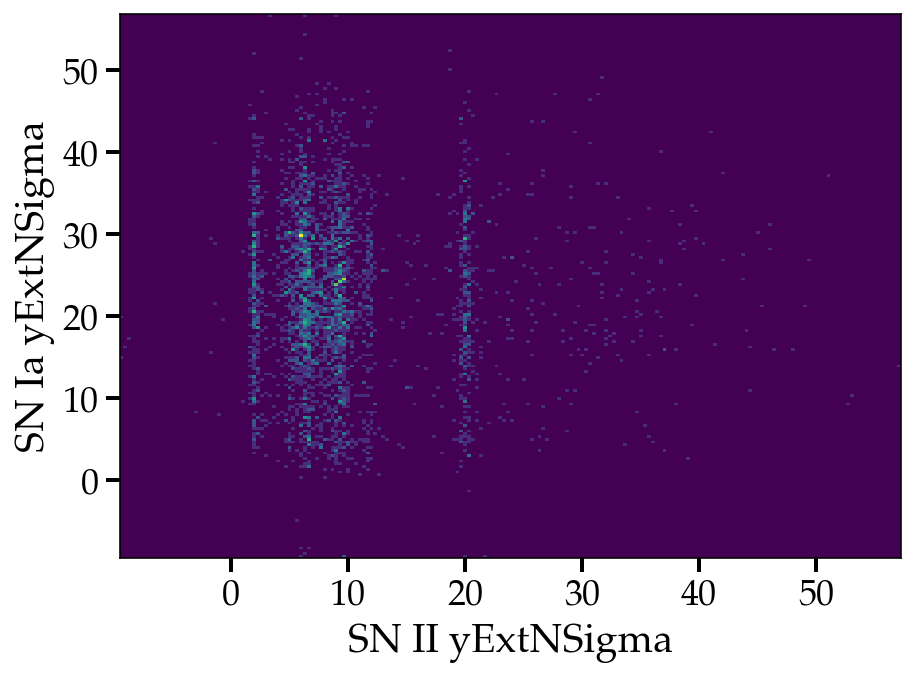

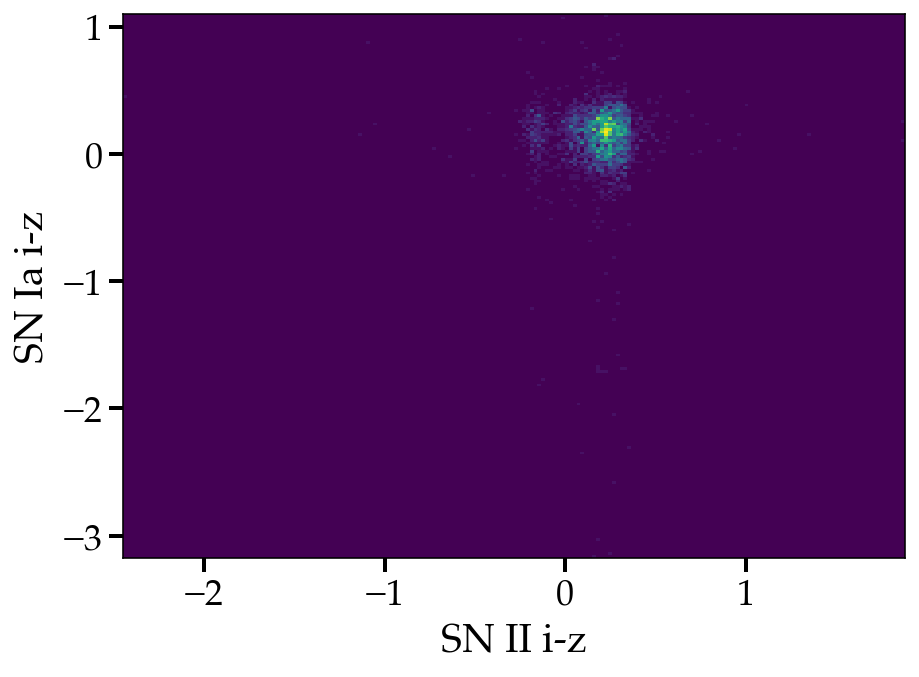

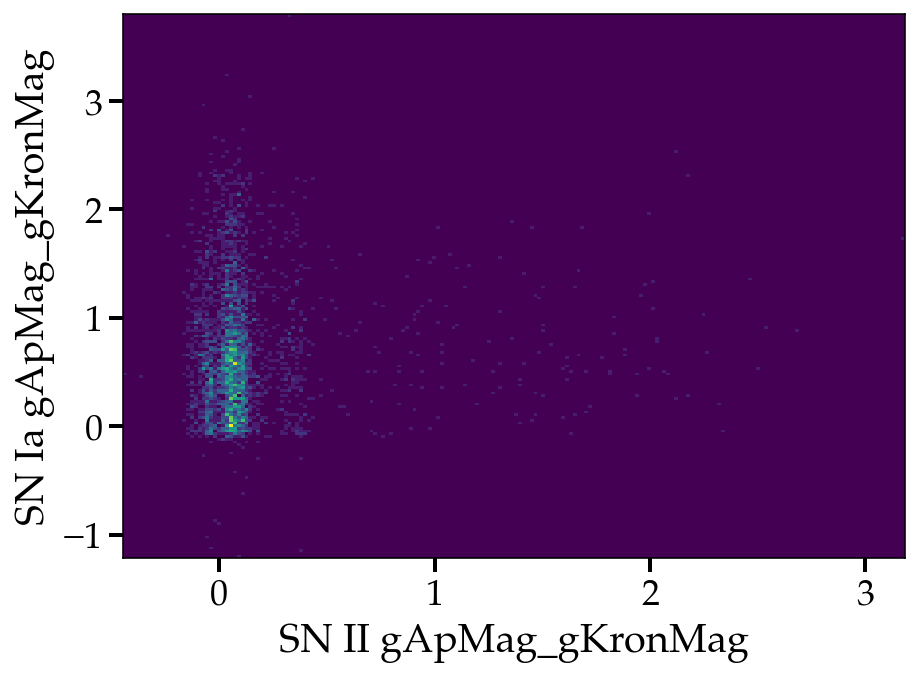

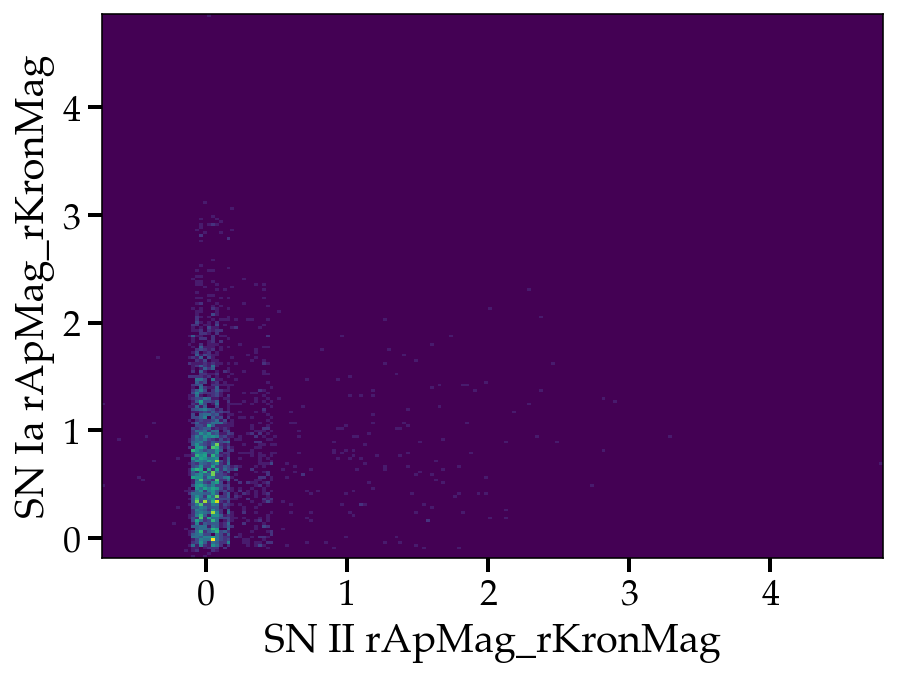

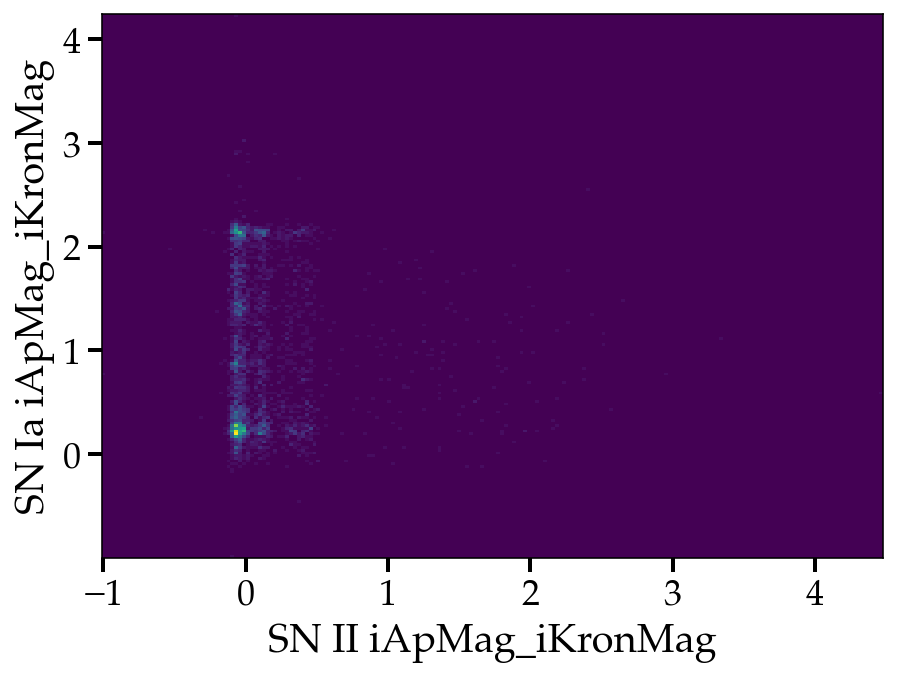

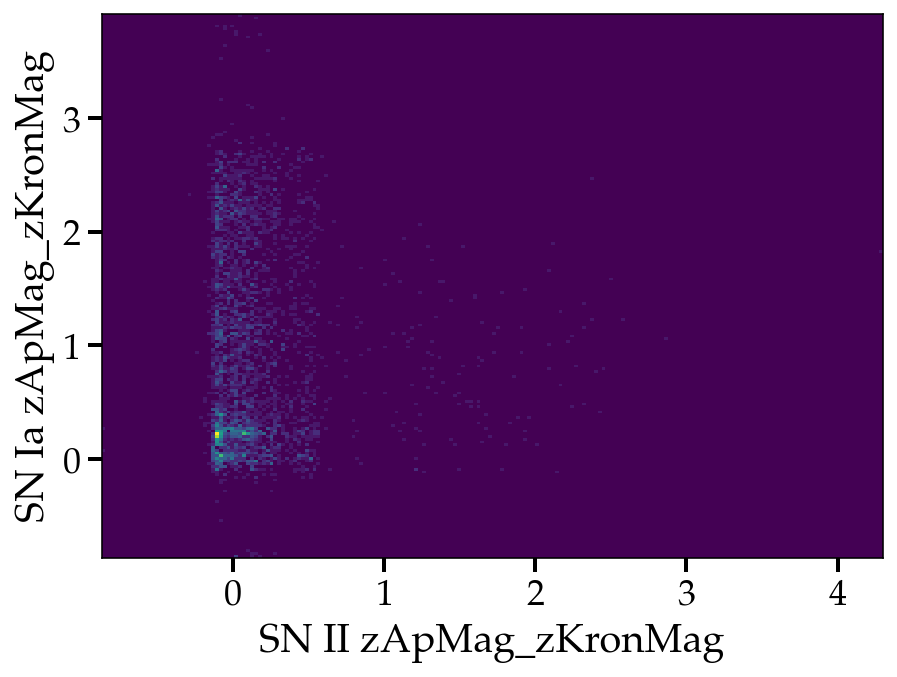

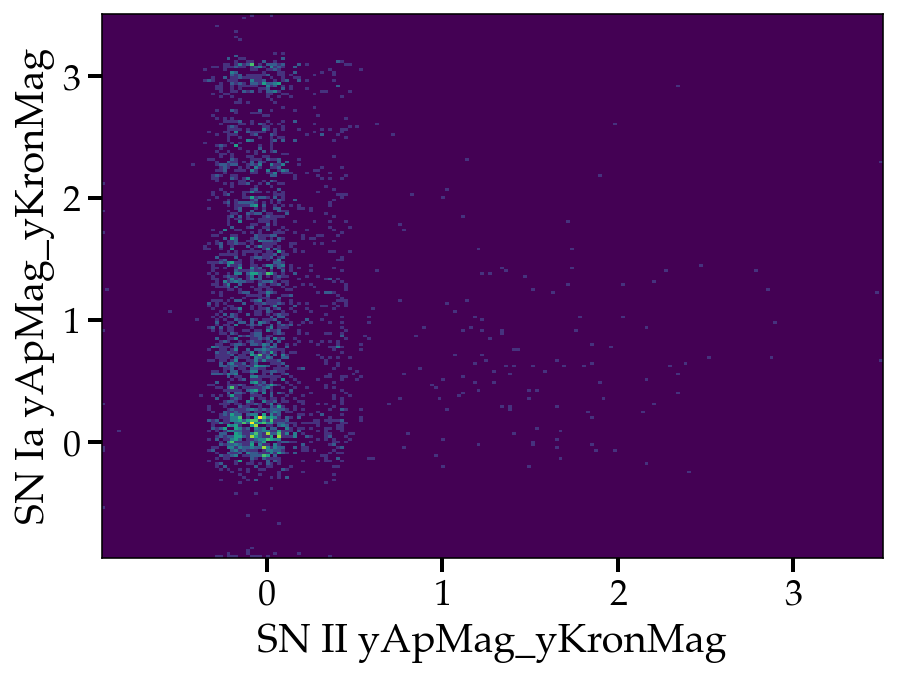

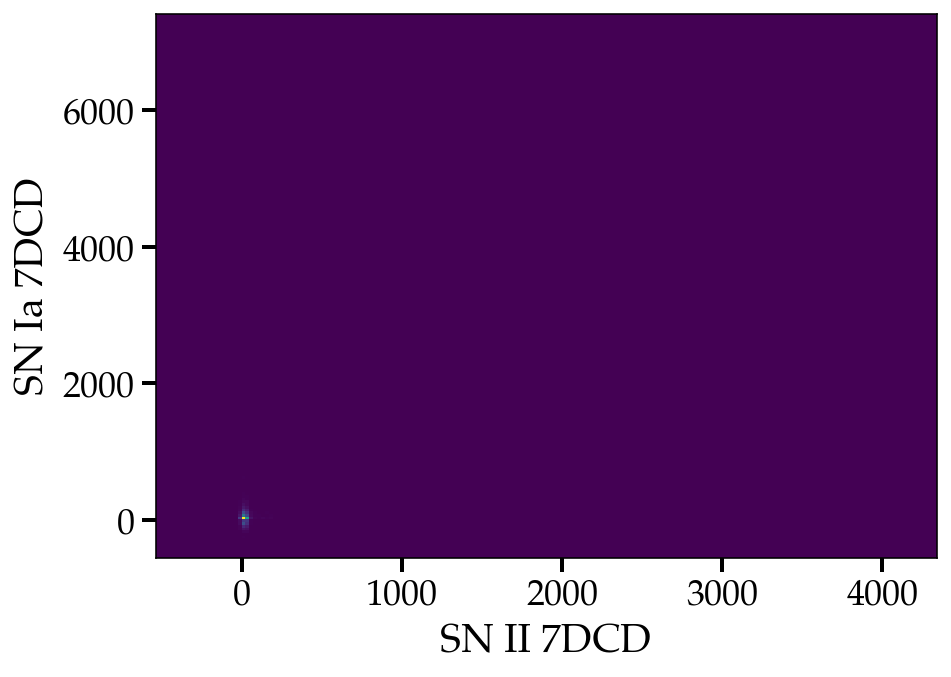

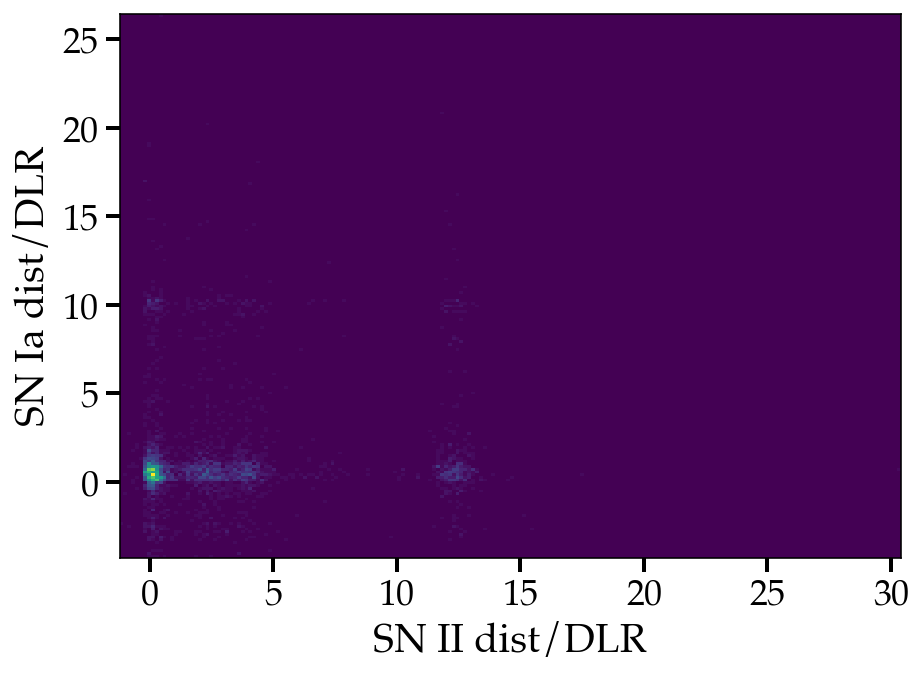

In [36]:
snii_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.tns_cls == "SN II"]
snia_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.tns_cls == "SN Ia"]

for i in range(0, 120, 1):
    feat = lc_and_host_features[0:120][i]
    plt.hist2d(snii_df[feat], snia_df[feat], bins=200)
    plt.xlabel(f"SN II {feat}")
    plt.ylabel(f"SN Ia {feat}")
    plt.show()